## 1. Import required libraries

In [1]:
# Vanilla GAN with Multi GPUs + Naming Layers using OrderedDict
# Code by GunhoChoi and TaeyoungKim

import torch
import torch.nn as nn
import torch.utils as utils
import torch.nn.init as init
from torch.autograd import Variable
import torchvision.utils as v_utils
import torchvision.datasets as dset
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
from collections import OrderedDict

## 2. Hyperparameter setting

In [2]:
# Set Hyperparameters
# change num_gpu to the number of gpus you want to use

epoch = 50
batch_size = 512
learning_rate = 0.0002
num_gpus = 1

## 3. Data Setting

In [3]:
# Download Data
mnist_train = dset.MNIST("./", train=True, 
                         transform=transforms.Compose([
                             transforms.ToTensor(),
                             #transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
                             transforms.Normalize((0.5,), (0.5,)),
                        ]),
                        target_transform=None,
                        download=True)


# Set Data Loader(input pipeline)
train_loader = torch.utils.data.DataLoader(dataset=mnist_train,batch_size=batch_size,shuffle=True,drop_last=True)

## 4. Generator

In [4]:
# Generator receives random noise z and create 1x28x28 image
# we can name each layer using OrderedDict

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()
        self.layer1 = nn.Sequential(
            nn.Linear(100,7*7*256),
            nn.BatchNorm1d(7*7*256),
            nn.ReLU(),
        )
        
        self.layer2 = nn.Sequential(OrderedDict([
            ('conv1', nn.ConvTranspose2d(256,128,3,2,1,1)),
            ('bn1', nn.BatchNorm2d(128)),
            ('relu1', nn.LeakyReLU()),
            ('conv2', nn.ConvTranspose2d(128,64,3,1,1)),
            ('bn2', nn.BatchNorm2d(64)),
            ('relu2', nn.LeakyReLU()),
        ]))
        
        self.layer3 = nn.Sequential(OrderedDict([
            ('conv3', nn.ConvTranspose2d(64,16,3,1,1)),
            ('bn3', nn.BatchNorm2d(16)),
            ('relu3', nn.LeakyReLU()),
            ('conv4', nn.ConvTranspose2d(16,1,3,2,1,1)),
            ('relu4', nn.Tanh()),
        ]))
    
    def forward(self,z):
        out = self.layer1(z)
        out = out.view(batch_size//num_gpus,256,7,7)
        out = self.layer2(out)
        out = self.layer3(out)
        
        return out
        

## 5. Discriminator

In [5]:
# Discriminator receives 1x28x28 image and returns a float number 0~1
# we can name each layer using OrderedDict

class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator,self).__init__()
        self.layer1 = nn.Sequential(OrderedDict([
                        ('conv1', nn.Conv2d(1,8,3,padding=1)),
                        # batch * 16 * 28 * 28
                        #('bn1',nn.BatchNorm2d(8)), 
                        ('relu1', nn.LeakyReLU()),
                        ('conv2', nn.Conv2d(8,16,3,padding=1)),
                        ('bn2', nn.BatchNorm2d(16)),
                        ('relu2', nn.LeakyReLU()),
                        ('max1', nn.MaxPool2d(2,2))
                        # batch * 32 * 14 * 14
        ]))
        
        self.layer2 = nn.Sequential(OrderedDict([
                        ('conv3', nn.Conv2d(16,32,3,padding=1)),
                        # batch * 64 * 14 * 14
                        ('bn3', nn.BatchNorm2d(32)),
                        ('relu3', nn.LeakyReLU()),
                        ('max2', nn.MaxPool2d(2,2)),
                        ('conv4', nn.Conv2d(32,64,3,padding=1)),
                        # batch * 128 * 7 * 7
                        ('bn4', nn.BatchNorm2d(64)),
                        ('relu4', nn.LeakyReLU())
        ]))
        
        self.fc = nn.Sequential(
                        nn.Linear(64 * 7 * 7,1),
                        nn.Sigmoid()
        )
        
    def forward(self,x):
        out = self.layer1(x)
        out = self.layer2(out)
        out = out.view(batch_size//num_gpus,-1)
        out = self.fc(out)
        
        return out

## 6.  Put instances on Multi-gpu

In [6]:
# Put class objects on Multiple GPUs using 
# torch.nn.DataParallel(module, device_ids=None, output_device=None, dim=0)
# device_ids: default all devices / output_device: default device 0 
# along with .cuda()

generator = nn.DataParallel(Generator()).cuda()
discriminator = nn.DataParallel(Discriminator()).cuda()

## 7. Check layers

In [7]:
# Get parameter list by using class.state_dict().keys()

gen_params = generator.state_dict().keys()
dis_params = discriminator.state_dict().keys()

for i in gen_params:
    print(i)

module.layer1.0.weight
module.layer1.0.bias
module.layer1.1.weight
module.layer1.1.bias
module.layer1.1.running_mean
module.layer1.1.running_var
module.layer1.1.num_batches_tracked
module.layer2.conv1.weight
module.layer2.conv1.bias
module.layer2.bn1.weight
module.layer2.bn1.bias
module.layer2.bn1.running_mean
module.layer2.bn1.running_var
module.layer2.bn1.num_batches_tracked
module.layer2.conv2.weight
module.layer2.conv2.bias
module.layer2.bn2.weight
module.layer2.bn2.bias
module.layer2.bn2.running_mean
module.layer2.bn2.running_var
module.layer2.bn2.num_batches_tracked
module.layer3.conv3.weight
module.layer3.conv3.bias
module.layer3.bn3.weight
module.layer3.bn3.bias
module.layer3.bn3.running_mean
module.layer3.bn3.running_var
module.layer3.bn3.num_batches_tracked
module.layer3.conv4.weight
module.layer3.conv4.bias


## 8. Set Loss function & Optimizer

In [8]:
# loss function, optimizers, and labels for training

loss_func = nn.MSELoss()
gen_optim = torch.optim.Adam(generator.parameters(), lr= 5*learning_rate,betas=(0.5,0.999))
dis_optim = torch.optim.Adam(discriminator.parameters(), lr=learning_rate,betas=(0.5,0.999))

ones_label = Variable(torch.ones(batch_size,1)).cuda()
zeros_label = Variable(torch.zeros(batch_size,1)).cuda()

def image_check(gen_fake):
    img = gen_fake.data.numpy()
    for i in range(10):
        plt.imshow(img[i][0],cmap='gray')
        plt.show()

## 9. Restore Model

In [9]:
# model restore if any

try:
    generator, discriminator = torch.load('./model/dcgan.pkl')
    print("\n--------model restored--------\n")
except:
    print("\n--------model not restored--------\n")
    pass


--------model not restored--------



## 10. Train Model

tensor(0.1760, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.6238, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.17600245773792267 dis_loss: 0.6238473653793335


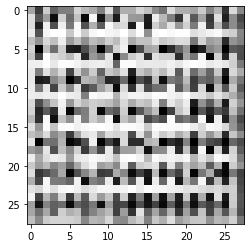

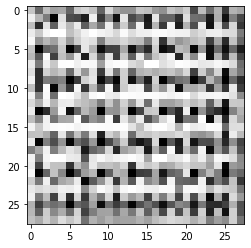

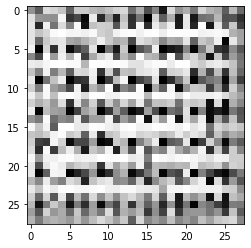

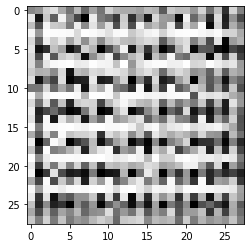

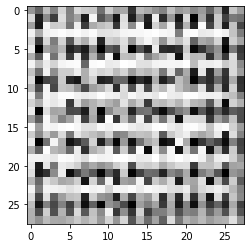

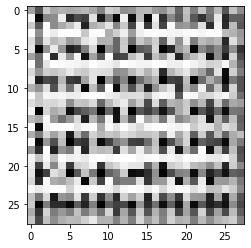

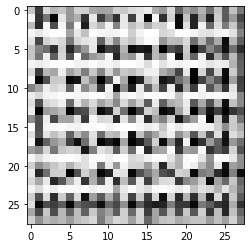

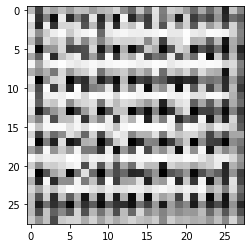

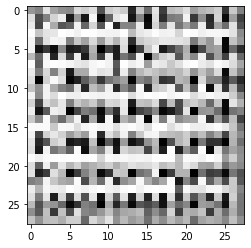

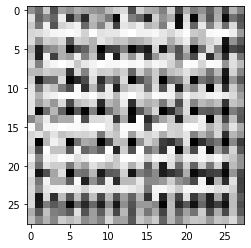

tensor(0.8683, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0135, device='cuda:0', grad_fn=<AddBackward0>)
0th iteration gen_loss: 0.8682593107223511 dis_loss: 0.01353747770190239


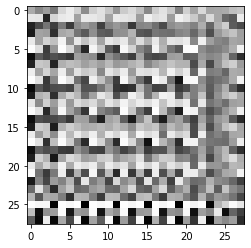

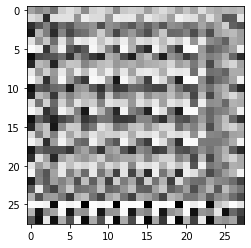

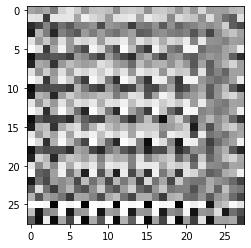

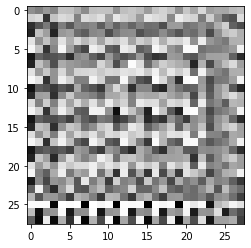

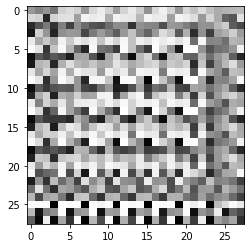

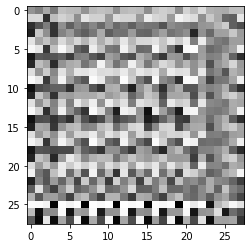

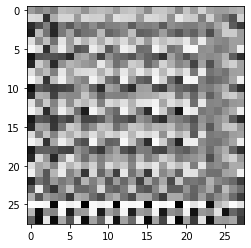

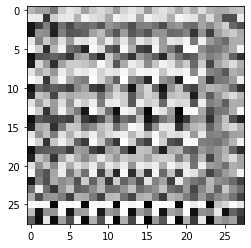

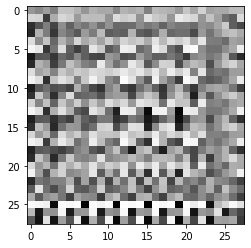

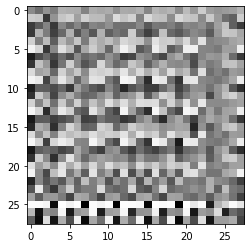

tensor(0.9036, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0064, device='cuda:0', grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.9035782814025879 dis_loss: 0.006370853632688522


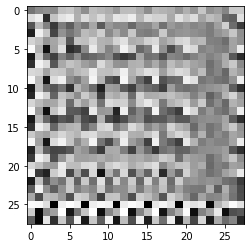

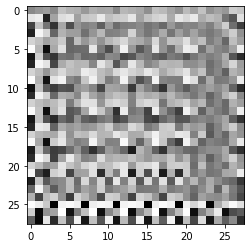

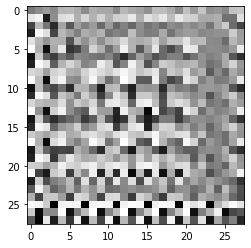

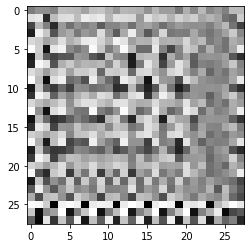

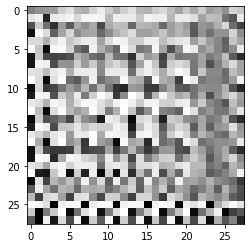

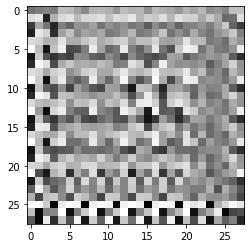

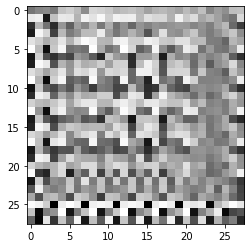

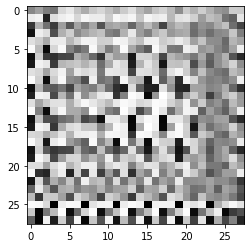

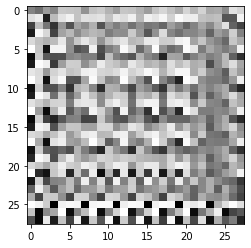

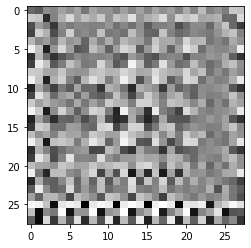

tensor(0.9120, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0104, device='cuda:0', grad_fn=<AddBackward0>)
1th iteration gen_loss: 0.9119594693183899 dis_loss: 0.010354867205023766


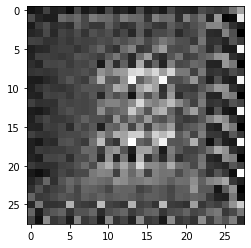

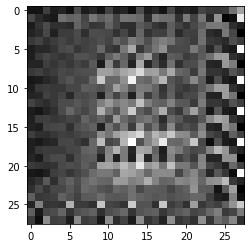

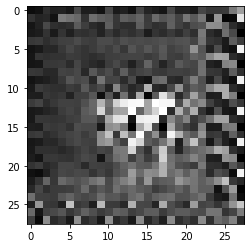

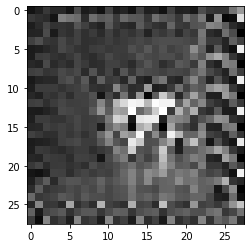

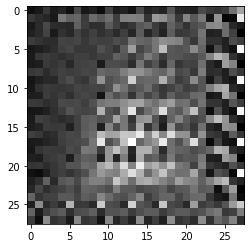

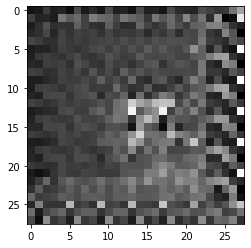

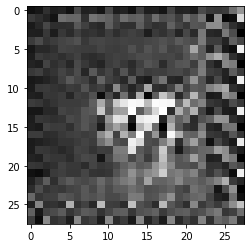

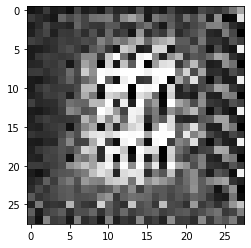

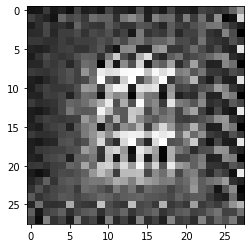

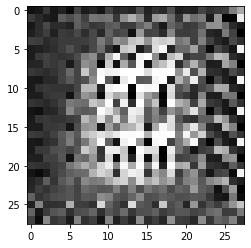

tensor(0.8989, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.0711, device='cuda:0', grad_fn=<AddBackward0>)
2th iteration gen_loss: 0.8988649249076843 dis_loss: 0.07107581198215485


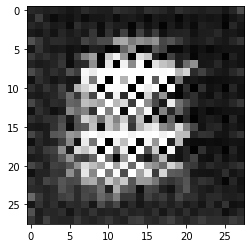

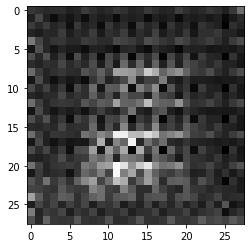

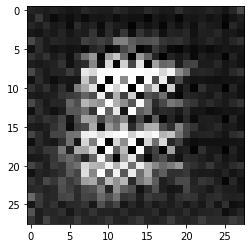

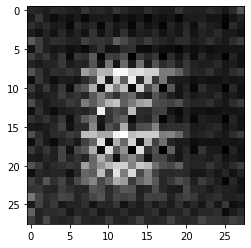

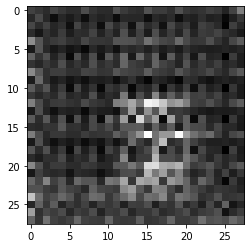

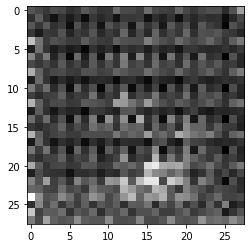

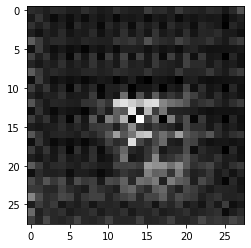

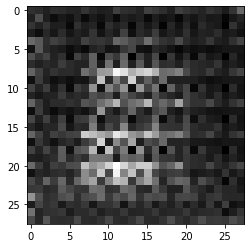

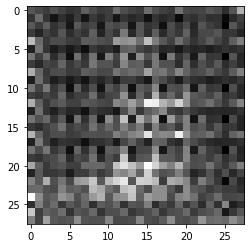

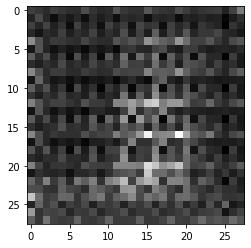

tensor(0.3809, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.2609, device='cuda:0', grad_fn=<AddBackward0>)
2th iteration gen_loss: 0.3809431791305542 dis_loss: 0.2609185576438904


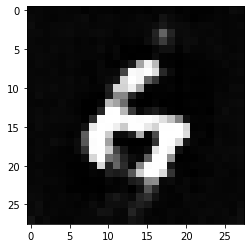

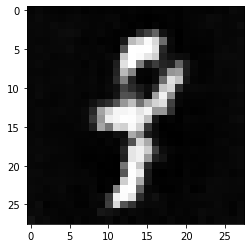

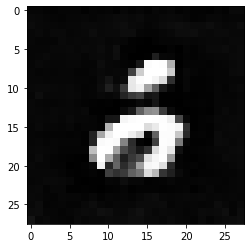

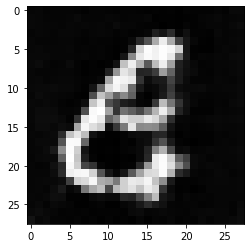

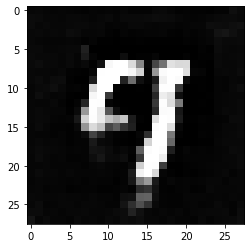

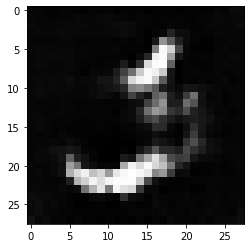

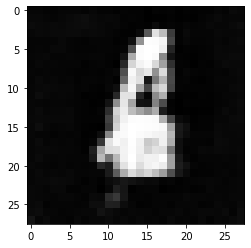

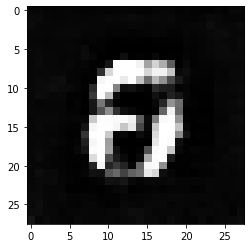

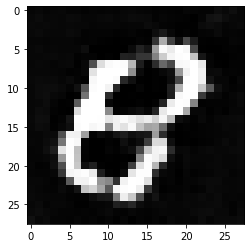

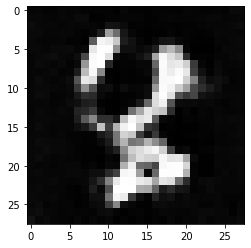

tensor(0.5876, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3160, device='cuda:0', grad_fn=<AddBackward0>)
3th iteration gen_loss: 0.5876023769378662 dis_loss: 0.3160359561443329


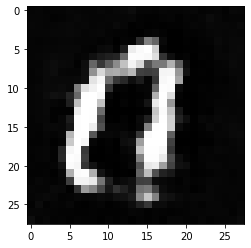

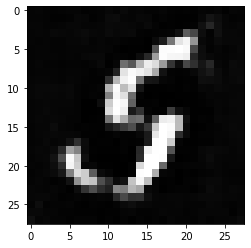

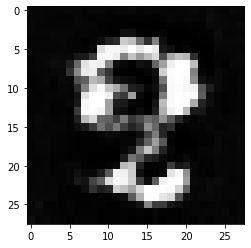

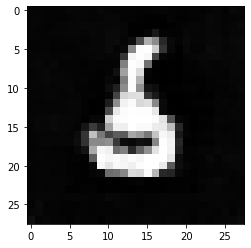

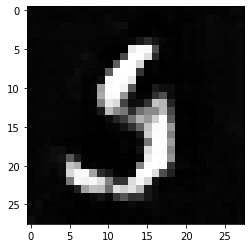

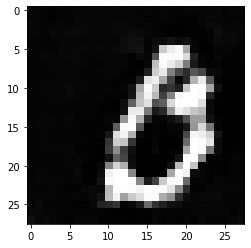

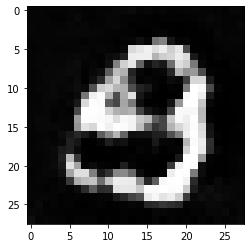

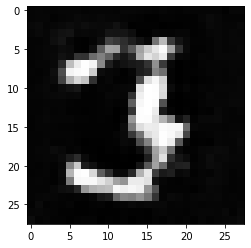

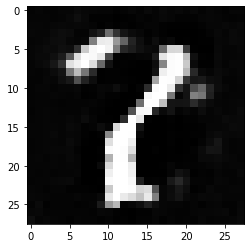

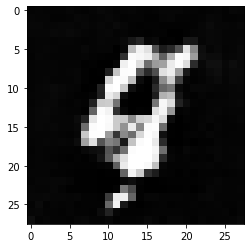

tensor(0.5201, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3680, device='cuda:0', grad_fn=<AddBackward0>)
3th iteration gen_loss: 0.5200716257095337 dis_loss: 0.36804690957069397


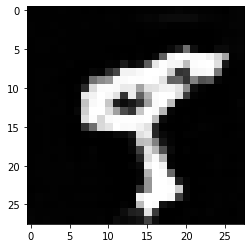

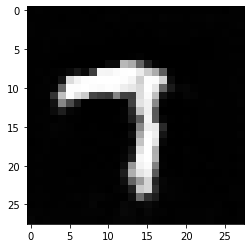

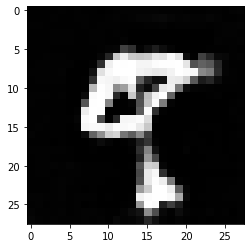

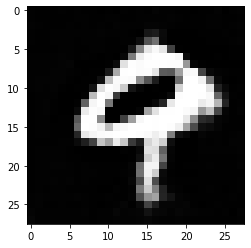

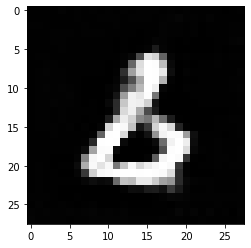

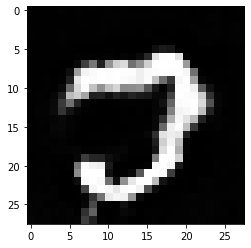

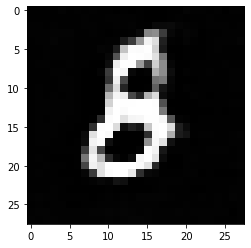

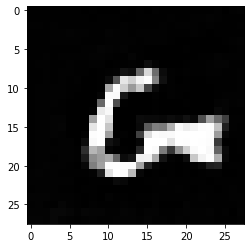

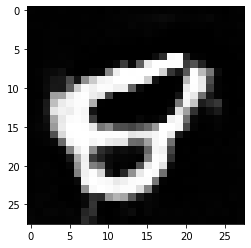

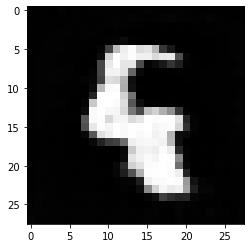

tensor(0.3209, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.3777, device='cuda:0', grad_fn=<AddBackward0>)
4th iteration gen_loss: 0.3209214210510254 dis_loss: 0.3777351379394531


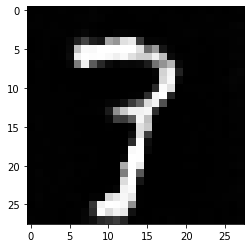

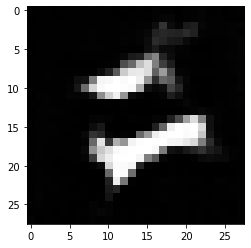

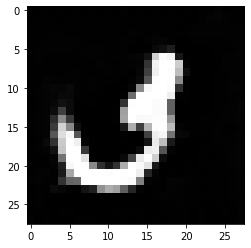

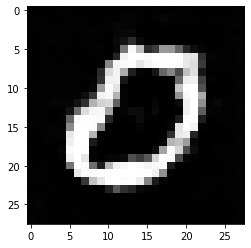

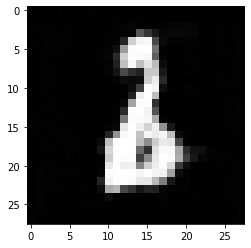

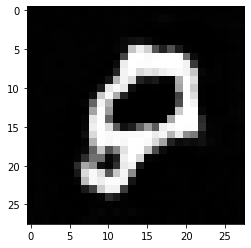

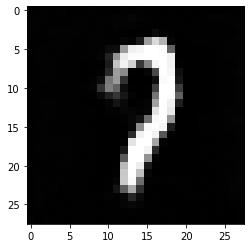

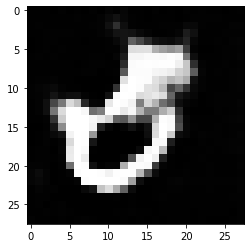

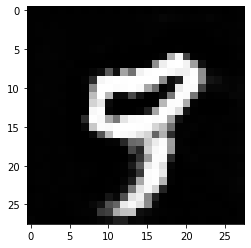

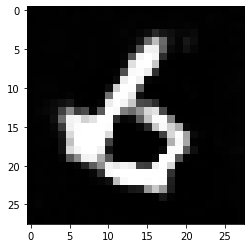

tensor(0.2645, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4145, device='cuda:0', grad_fn=<AddBackward0>)
4th iteration gen_loss: 0.2645295262336731 dis_loss: 0.41448938846588135


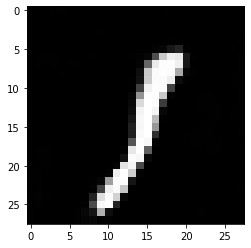

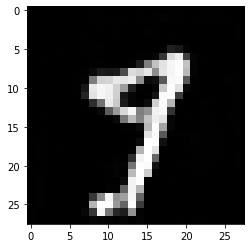

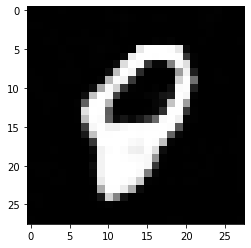

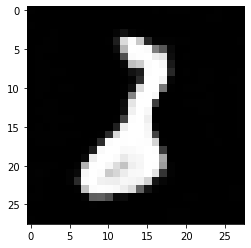

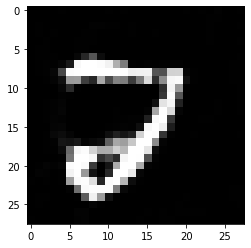

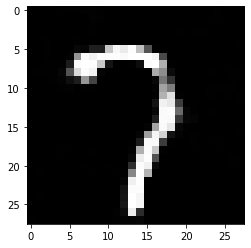

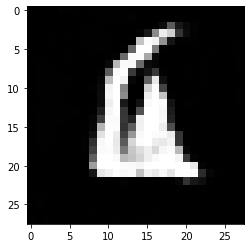

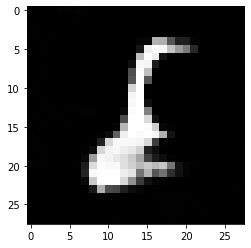

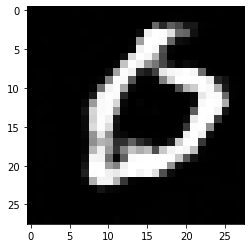

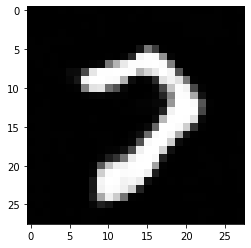

tensor(0.3688, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4098, device='cuda:0', grad_fn=<AddBackward0>)
5th iteration gen_loss: 0.36883699893951416 dis_loss: 0.40984347462654114


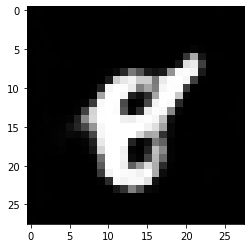

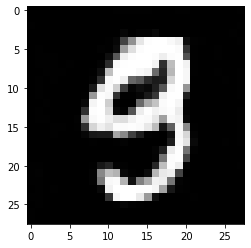

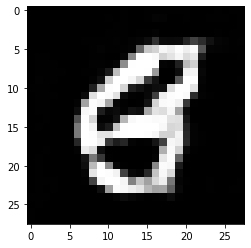

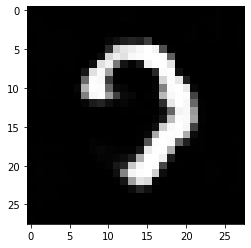

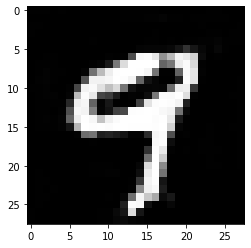

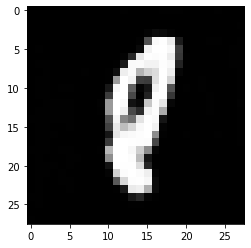

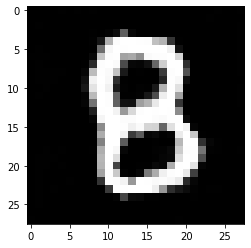

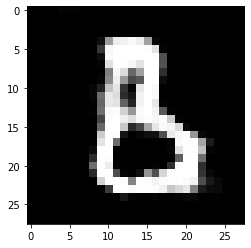

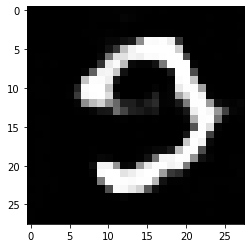

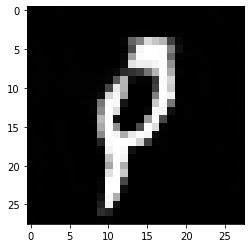

tensor(0.4171, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4235, device='cuda:0', grad_fn=<AddBackward0>)
5th iteration gen_loss: 0.4170737862586975 dis_loss: 0.42351192235946655


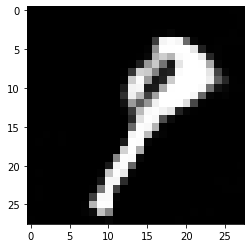

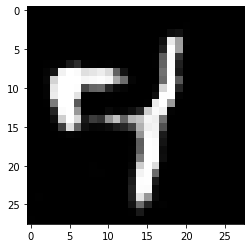

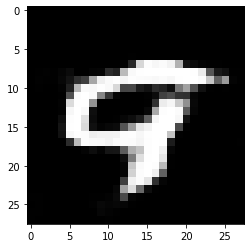

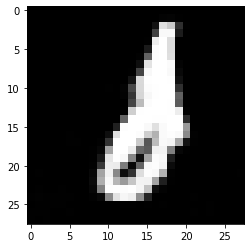

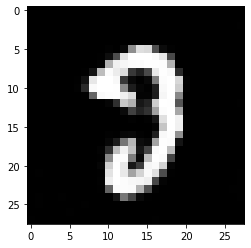

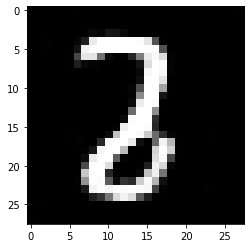

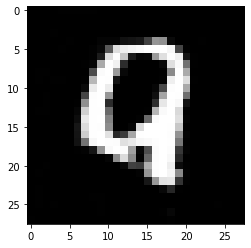

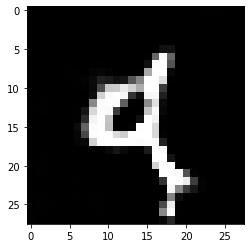

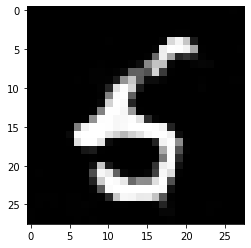

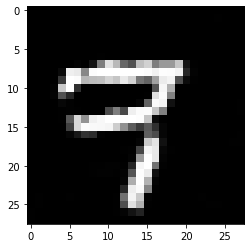

tensor(0.3078, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)
6th iteration gen_loss: 0.30781081318855286 dis_loss: 0.42195379734039307


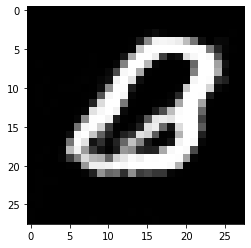

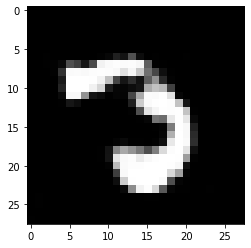

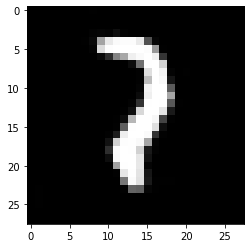

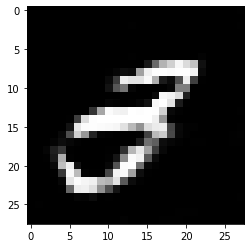

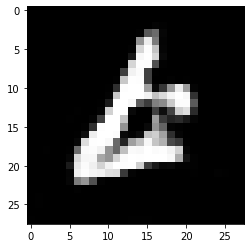

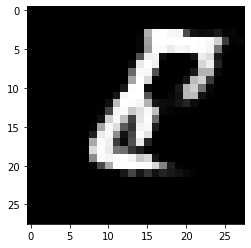

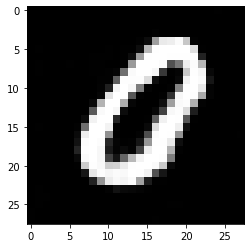

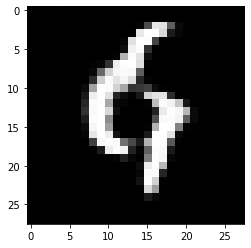

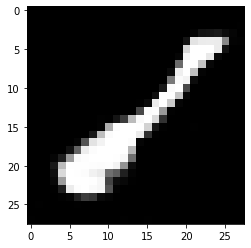

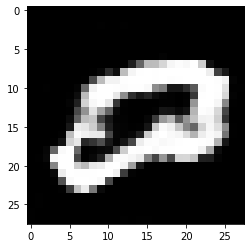

tensor(0.3311, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4220, device='cuda:0', grad_fn=<AddBackward0>)
6th iteration gen_loss: 0.3311125934123993 dis_loss: 0.42204660177230835


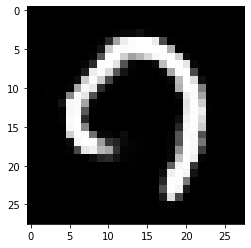

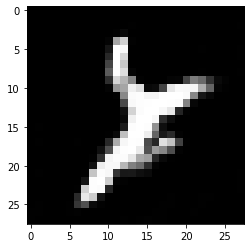

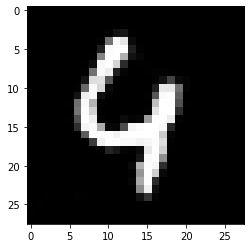

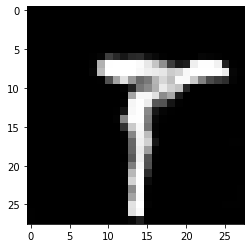

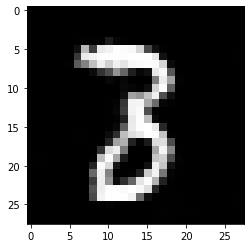

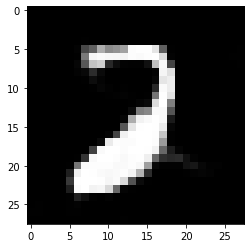

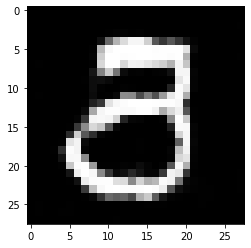

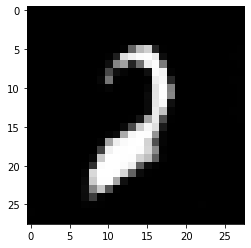

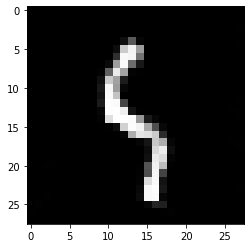

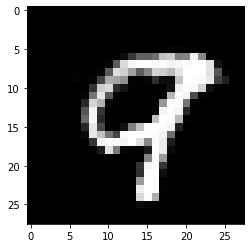

tensor(0.3152, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4211, device='cuda:0', grad_fn=<AddBackward0>)
7th iteration gen_loss: 0.31516143679618835 dis_loss: 0.42111635208129883


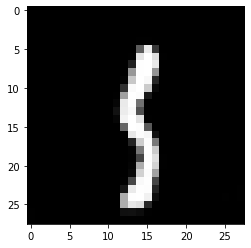

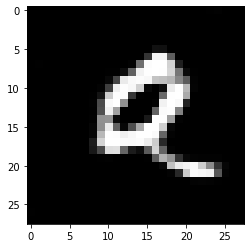

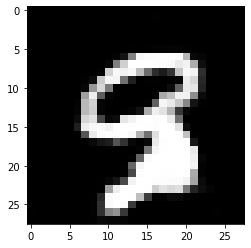

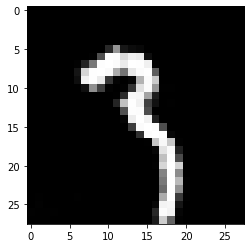

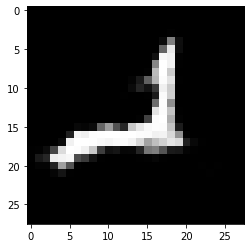

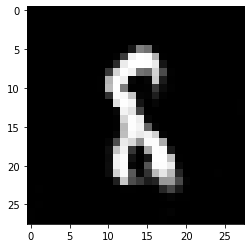

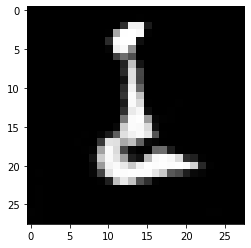

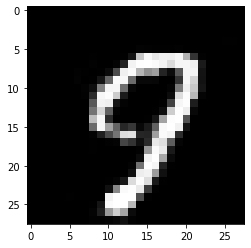

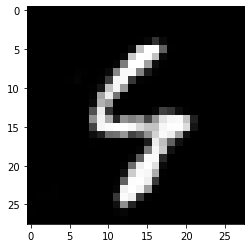

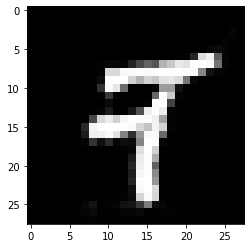

tensor(0.2534, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4333, device='cuda:0', grad_fn=<AddBackward0>)
7th iteration gen_loss: 0.25338679552078247 dis_loss: 0.4333132207393646


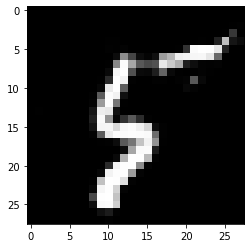

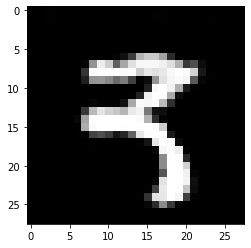

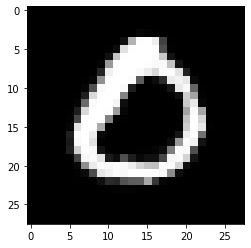

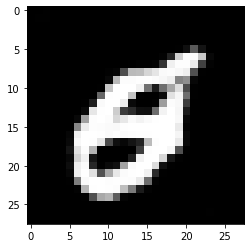

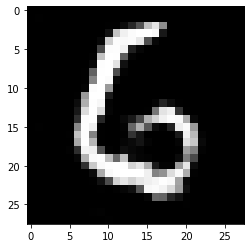

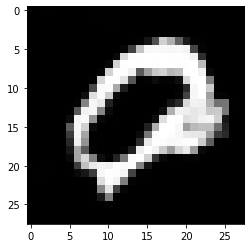

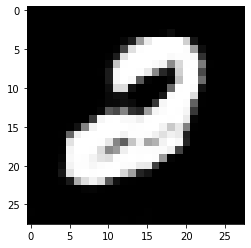

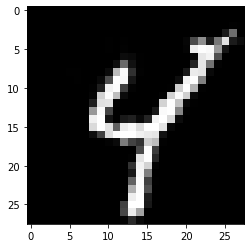

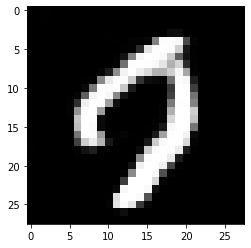

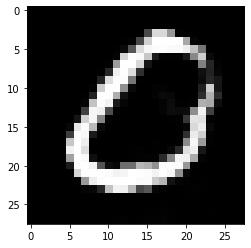

tensor(0.2821, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4301, device='cuda:0', grad_fn=<AddBackward0>)
8th iteration gen_loss: 0.2821018397808075 dis_loss: 0.4301304221153259


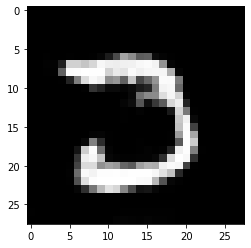

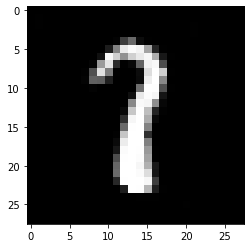

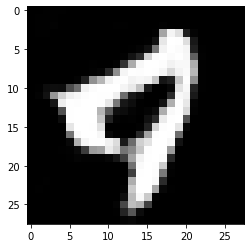

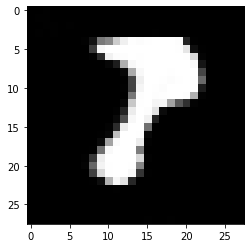

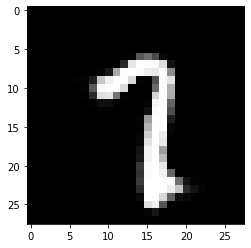

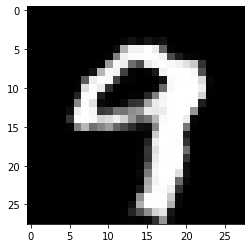

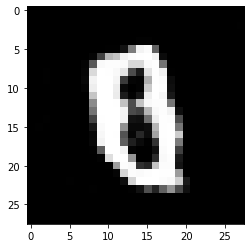

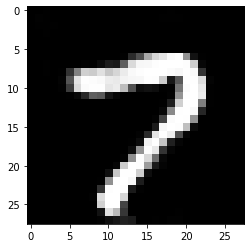

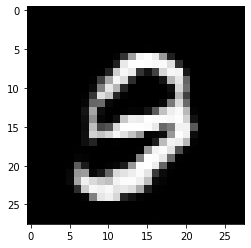

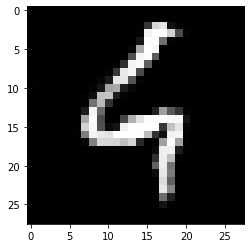

tensor(0.2471, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4376, device='cuda:0', grad_fn=<AddBackward0>)
8th iteration gen_loss: 0.2470727562904358 dis_loss: 0.4376057982444763


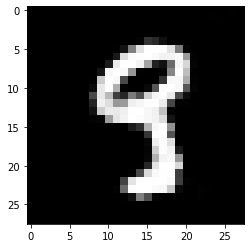

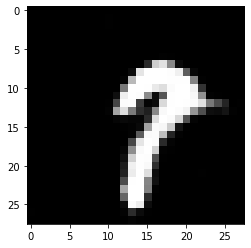

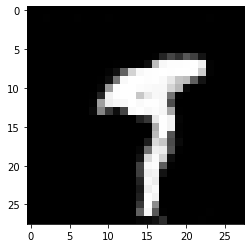

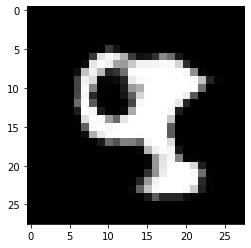

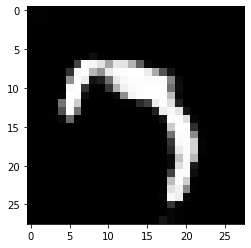

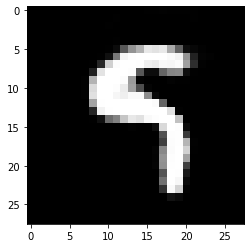

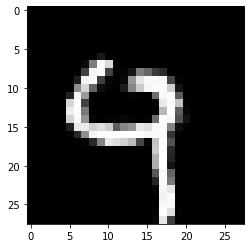

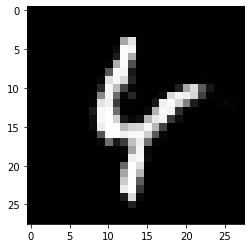

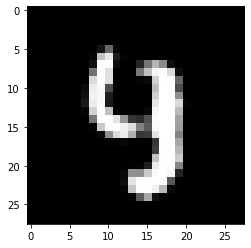

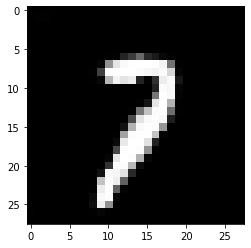

tensor(0.3632, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4378, device='cuda:0', grad_fn=<AddBackward0>)
9th iteration gen_loss: 0.36316996812820435 dis_loss: 0.4377564787864685


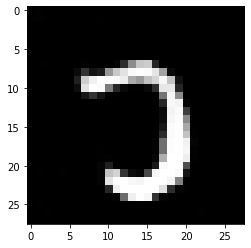

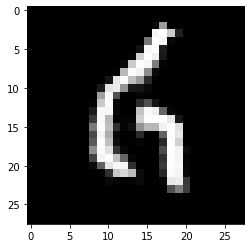

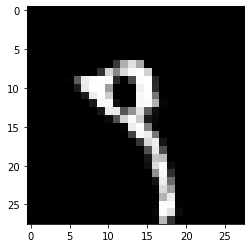

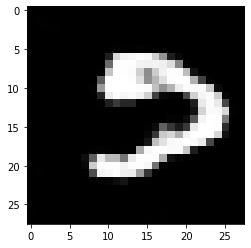

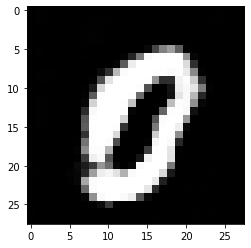

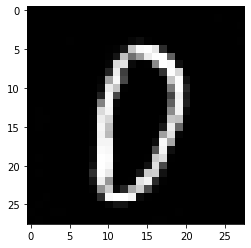

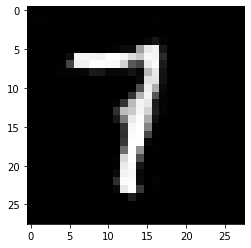

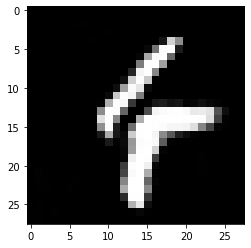

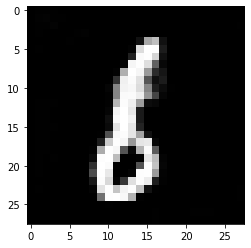

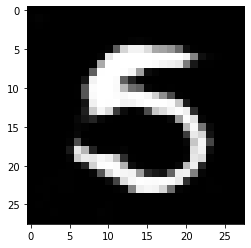

tensor(0.2739, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4284, device='cuda:0', grad_fn=<AddBackward0>)
9th iteration gen_loss: 0.27390456199645996 dis_loss: 0.4284310042858124


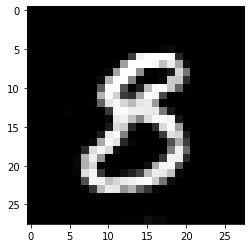

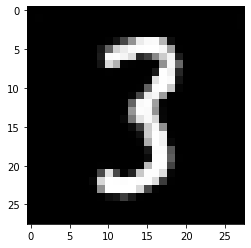

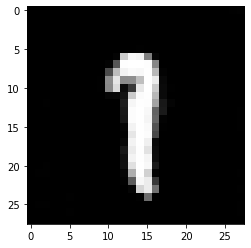

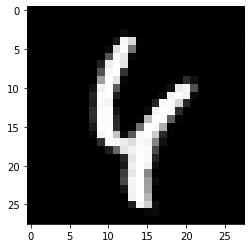

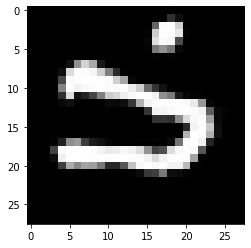

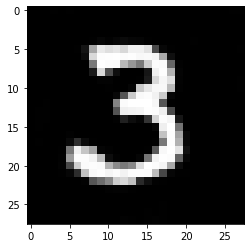

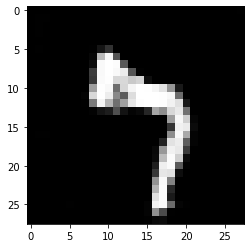

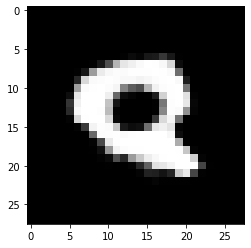

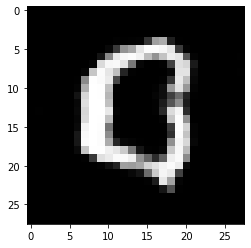

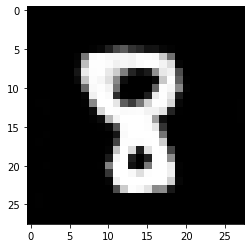

tensor(0.3498, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4429, device='cuda:0', grad_fn=<AddBackward0>)
10th iteration gen_loss: 0.34978818893432617 dis_loss: 0.4428725838661194


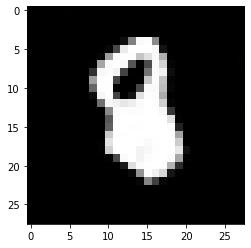

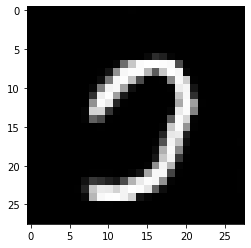

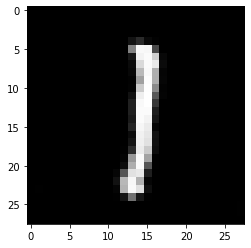

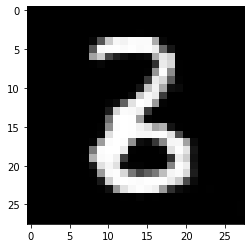

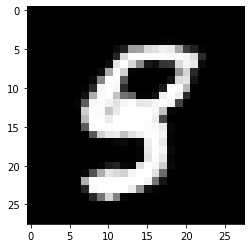

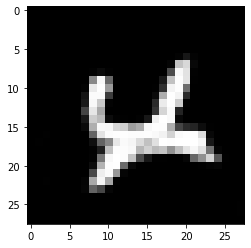

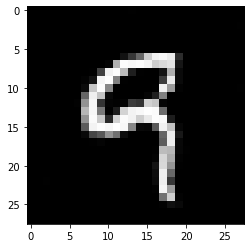

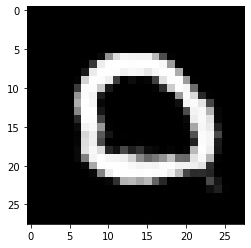

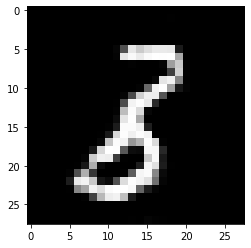

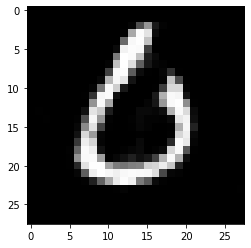

tensor(0.3850, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4435, device='cuda:0', grad_fn=<AddBackward0>)
10th iteration gen_loss: 0.3850433826446533 dis_loss: 0.4434528648853302


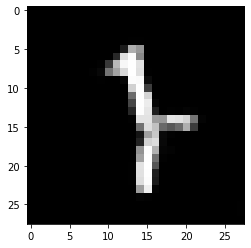

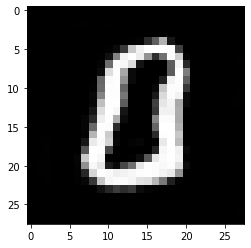

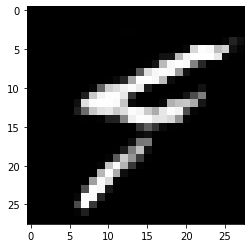

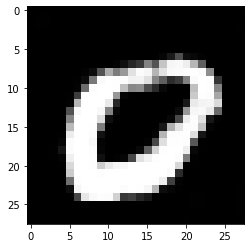

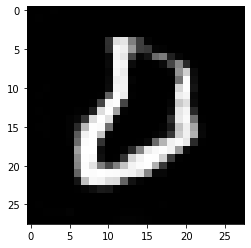

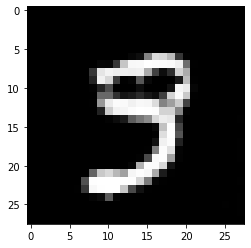

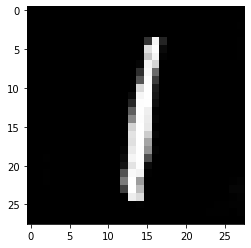

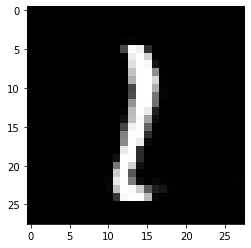

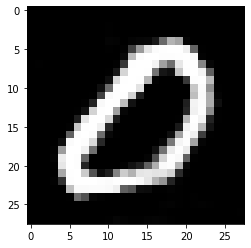

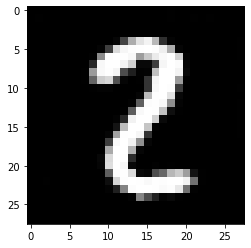

tensor(0.2379, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4449, device='cuda:0', grad_fn=<AddBackward0>)
11th iteration gen_loss: 0.23793771862983704 dis_loss: 0.4449053406715393


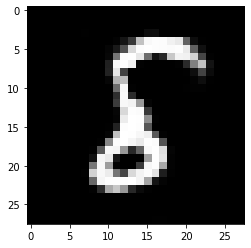

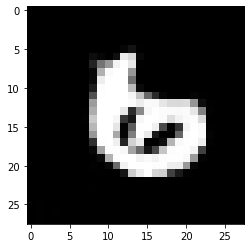

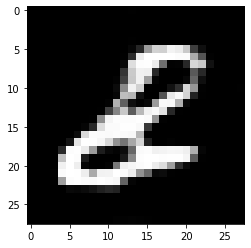

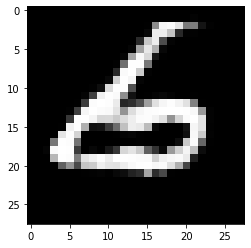

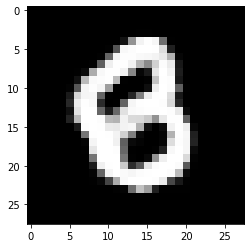

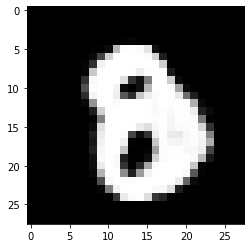

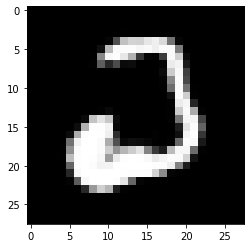

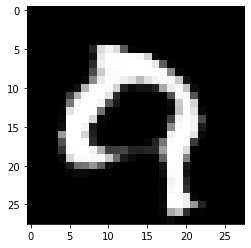

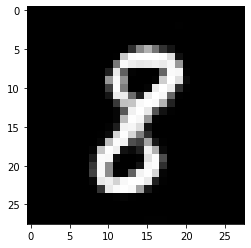

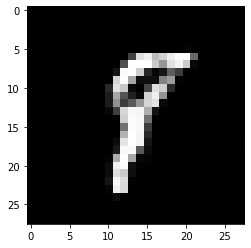

tensor(0.2546, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4424, device='cuda:0', grad_fn=<AddBackward0>)
11th iteration gen_loss: 0.2545635998249054 dis_loss: 0.44239920377731323


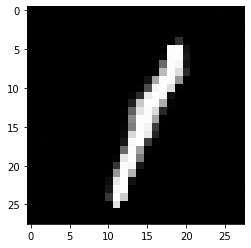

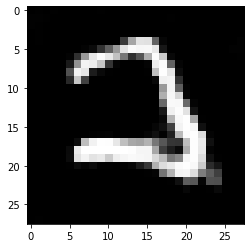

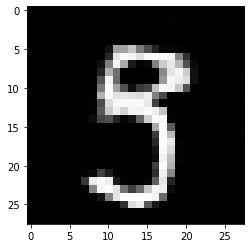

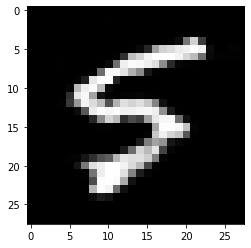

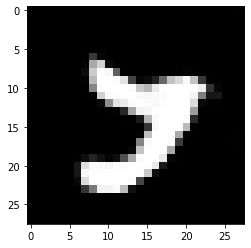

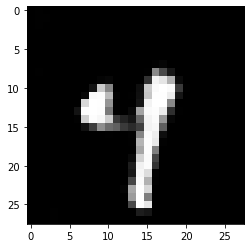

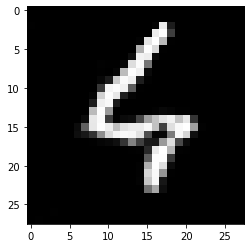

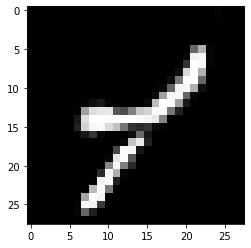

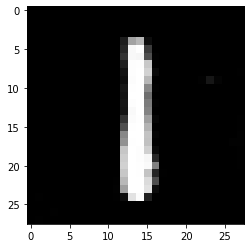

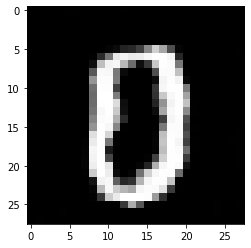

tensor(0.4111, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)
12th iteration gen_loss: 0.4110519587993622 dis_loss: 0.4535757899284363


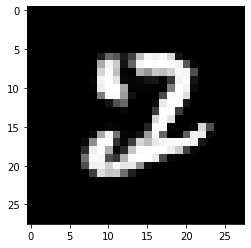

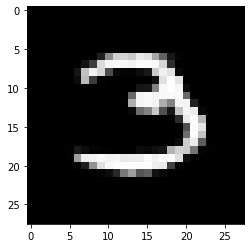

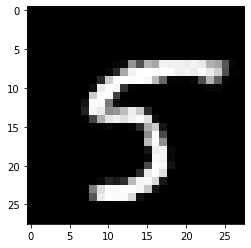

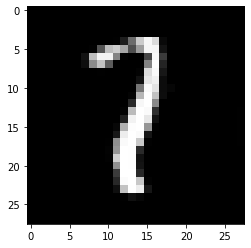

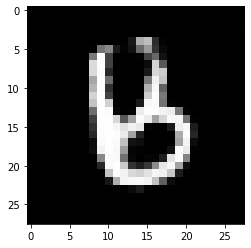

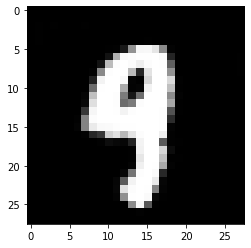

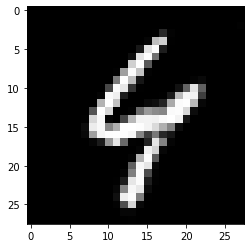

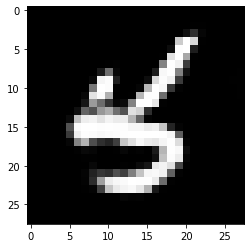

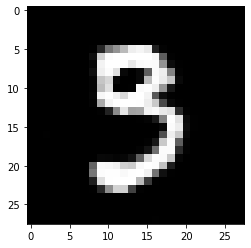

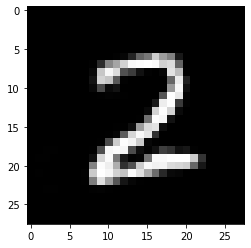

tensor(0.2535, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4291, device='cuda:0', grad_fn=<AddBackward0>)
12th iteration gen_loss: 0.25352534651756287 dis_loss: 0.4291093349456787


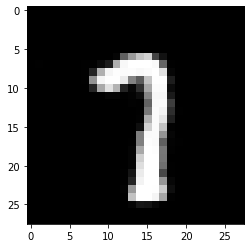

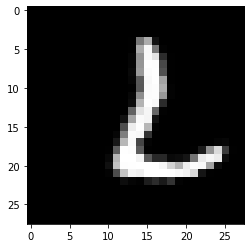

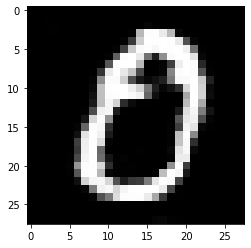

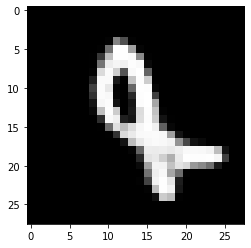

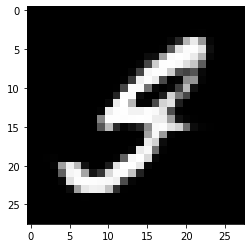

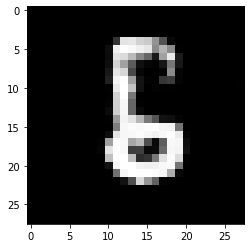

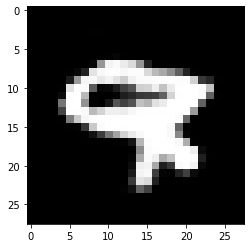

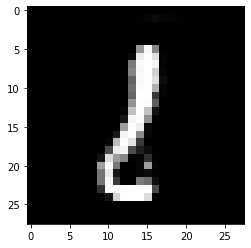

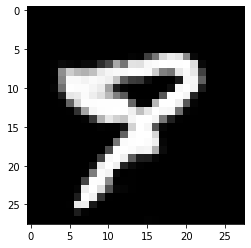

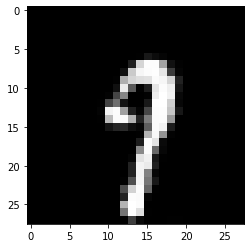

tensor(0.3862, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4485, device='cuda:0', grad_fn=<AddBackward0>)
13th iteration gen_loss: 0.3862107992172241 dis_loss: 0.448466420173645


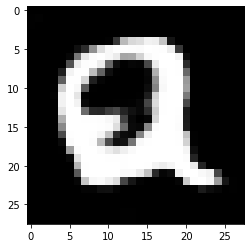

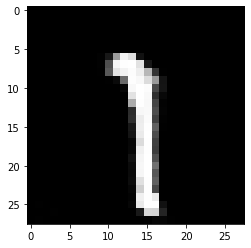

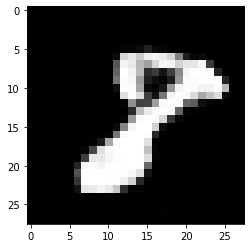

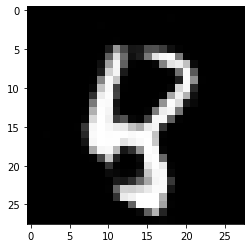

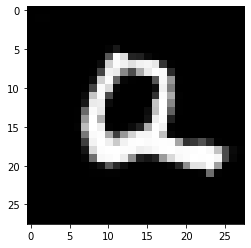

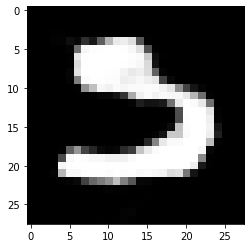

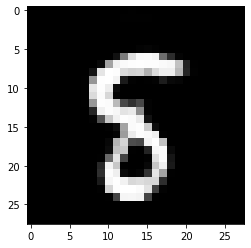

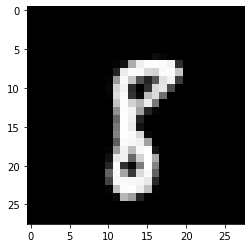

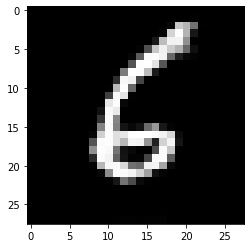

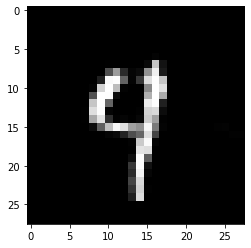

tensor(0.3731, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4428, device='cuda:0', grad_fn=<AddBackward0>)
13th iteration gen_loss: 0.3731376826763153 dis_loss: 0.44275569915771484


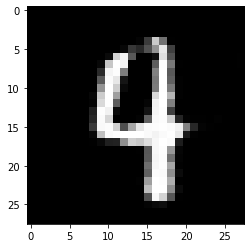

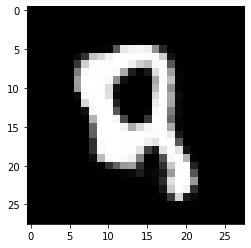

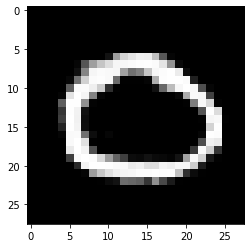

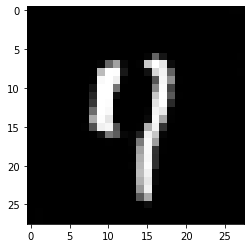

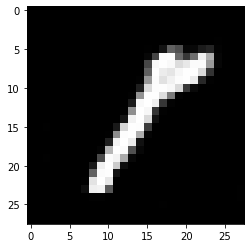

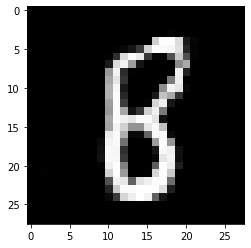

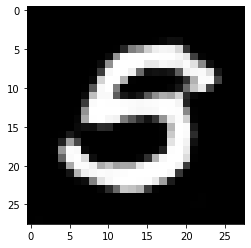

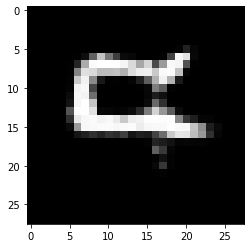

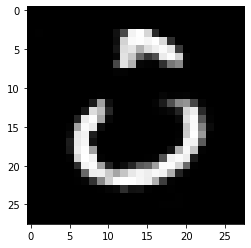

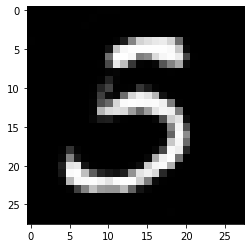

tensor(0.2298, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4491, device='cuda:0', grad_fn=<AddBackward0>)
14th iteration gen_loss: 0.22982309758663177 dis_loss: 0.4490814805030823


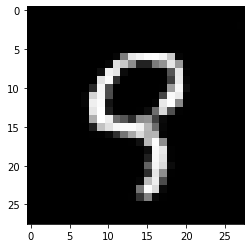

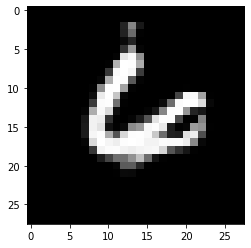

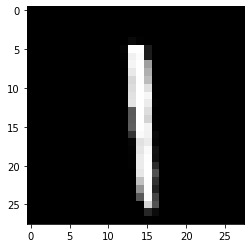

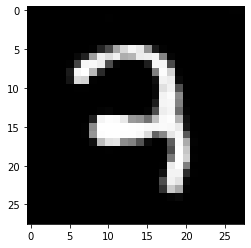

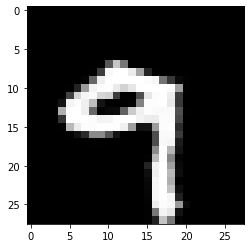

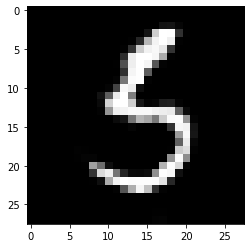

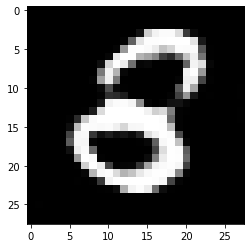

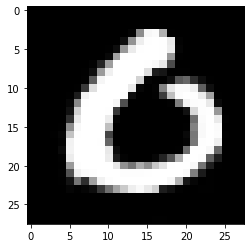

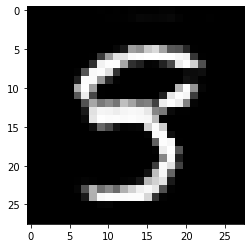

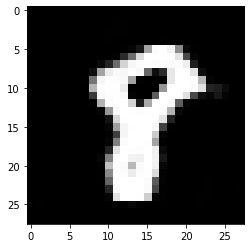

tensor(0.2562, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4379, device='cuda:0', grad_fn=<AddBackward0>)
14th iteration gen_loss: 0.2561948895454407 dis_loss: 0.4378553628921509


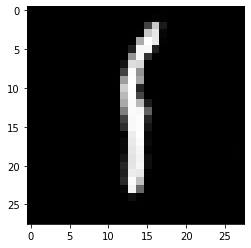

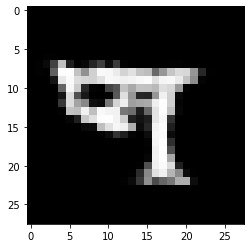

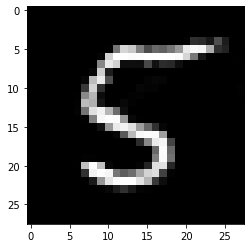

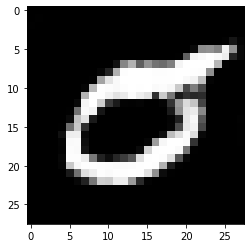

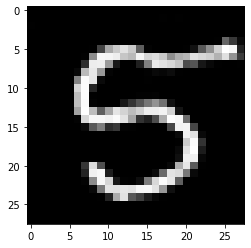

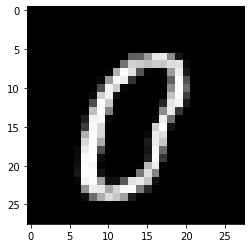

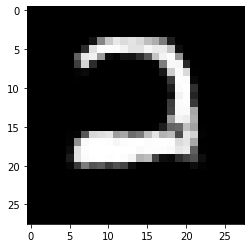

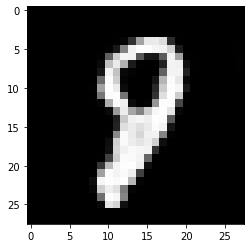

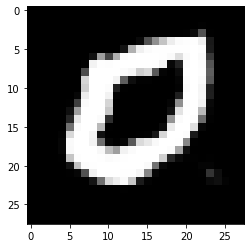

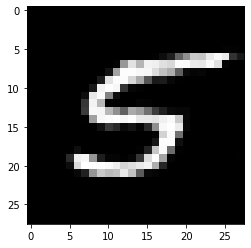

tensor(0.2246, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4334, device='cuda:0', grad_fn=<AddBackward0>)
15th iteration gen_loss: 0.22457492351531982 dis_loss: 0.43344804644584656


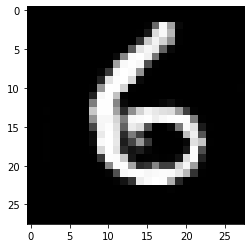

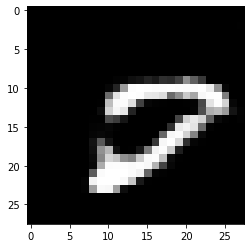

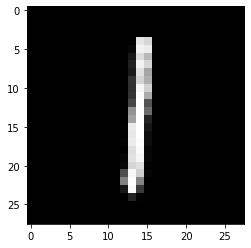

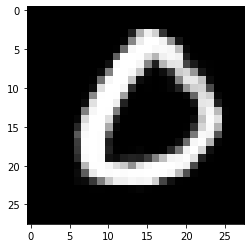

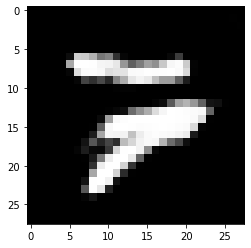

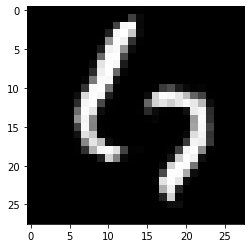

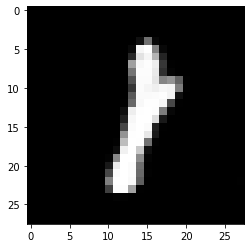

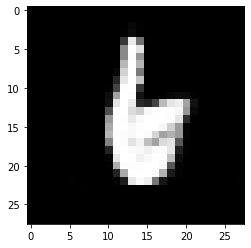

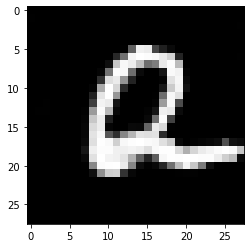

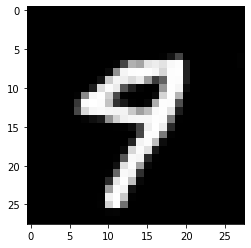

tensor(0.2616, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4390, device='cuda:0', grad_fn=<AddBackward0>)
15th iteration gen_loss: 0.261591374874115 dis_loss: 0.439012348651886


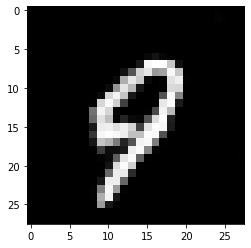

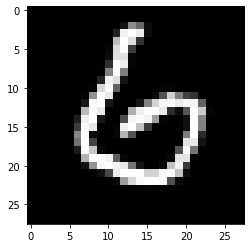

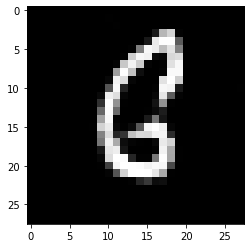

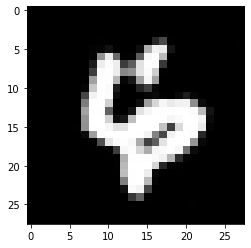

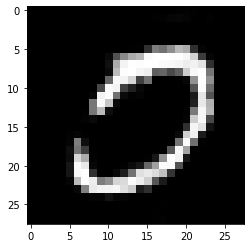

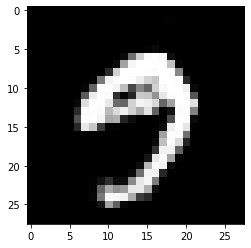

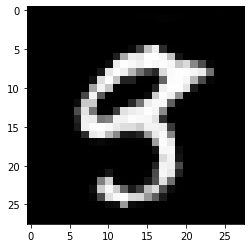

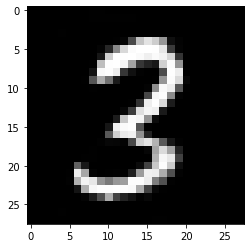

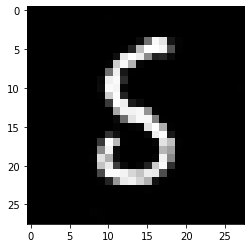

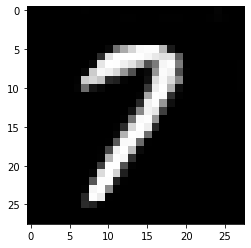

tensor(0.3853, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)
16th iteration gen_loss: 0.38531261682510376 dis_loss: 0.444515585899353


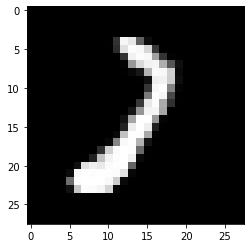

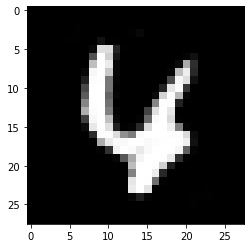

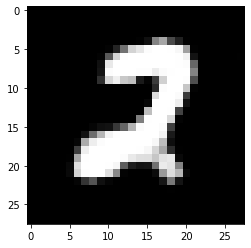

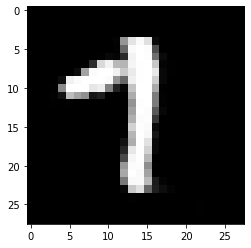

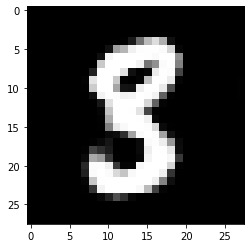

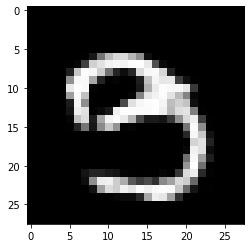

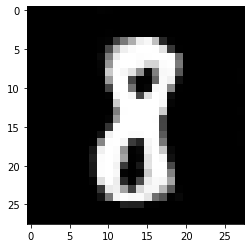

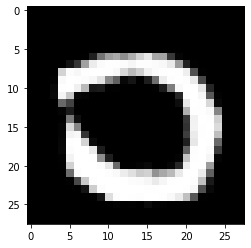

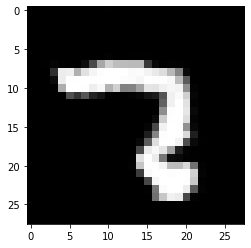

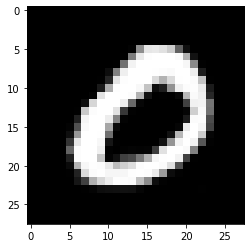

tensor(0.2959, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4462, device='cuda:0', grad_fn=<AddBackward0>)
16th iteration gen_loss: 0.29588016867637634 dis_loss: 0.44622519612312317


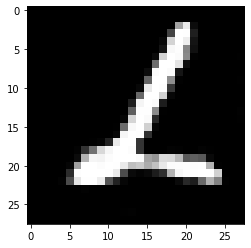

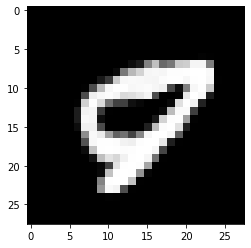

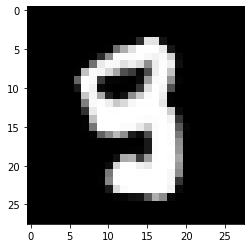

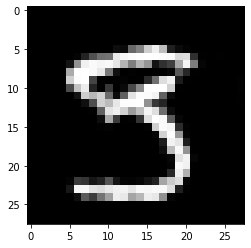

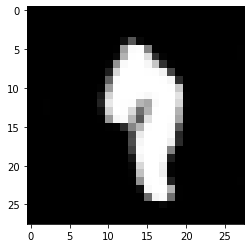

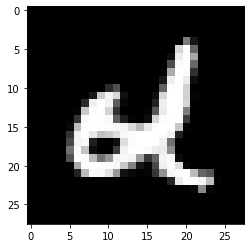

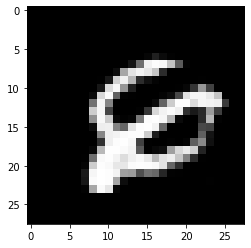

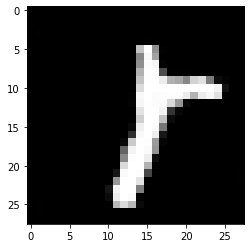

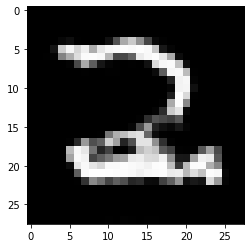

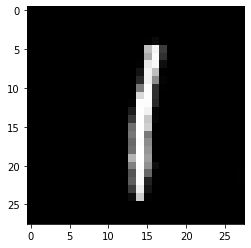

tensor(0.2662, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)
17th iteration gen_loss: 0.2661924660205841 dis_loss: 0.4474456310272217


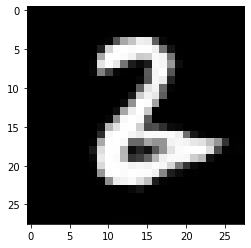

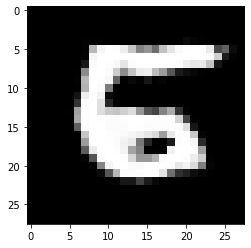

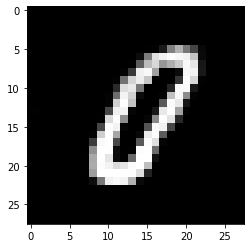

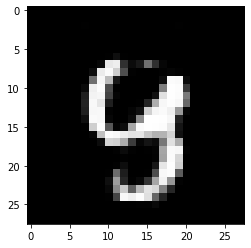

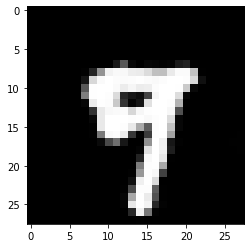

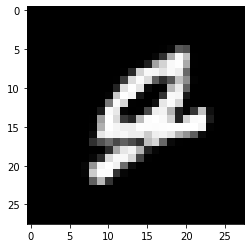

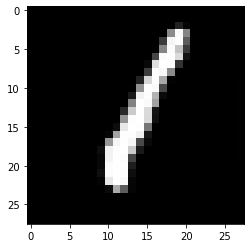

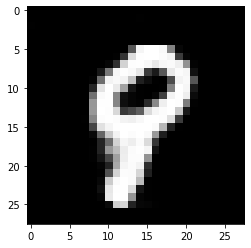

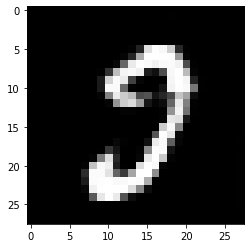

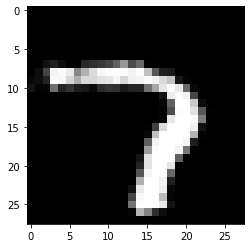

tensor(0.2954, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4316, device='cuda:0', grad_fn=<AddBackward0>)
17th iteration gen_loss: 0.2953958511352539 dis_loss: 0.4316401183605194


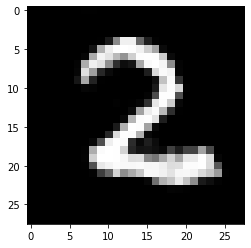

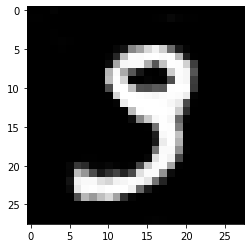

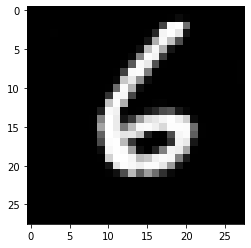

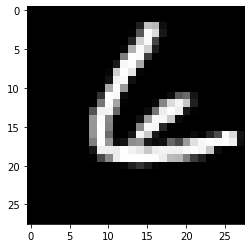

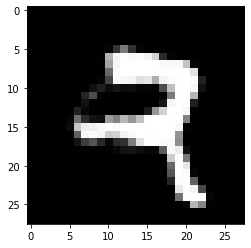

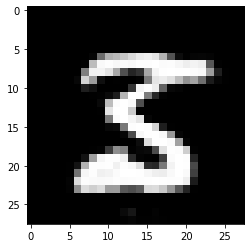

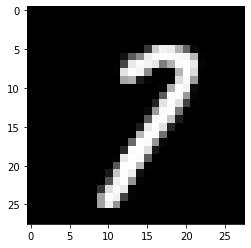

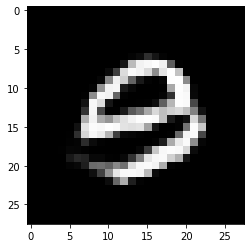

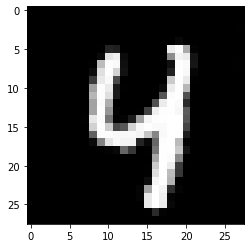

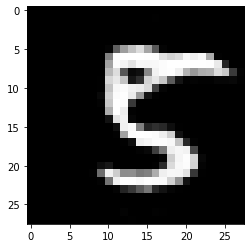

tensor(0.2858, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4349, device='cuda:0', grad_fn=<AddBackward0>)
18th iteration gen_loss: 0.28578057885169983 dis_loss: 0.4349466562271118


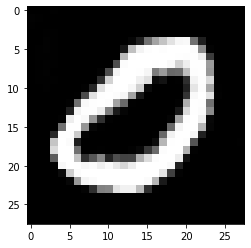

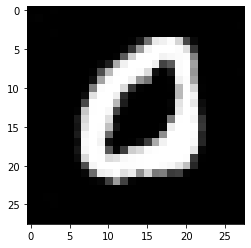

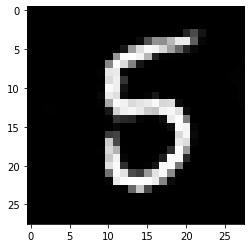

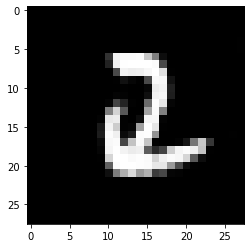

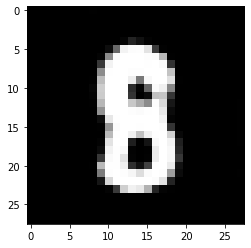

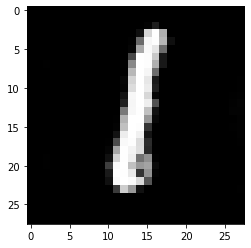

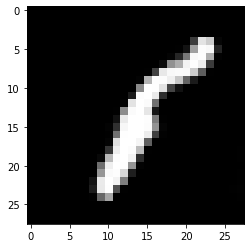

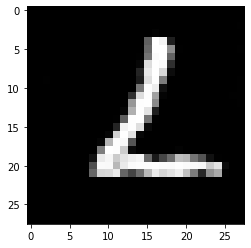

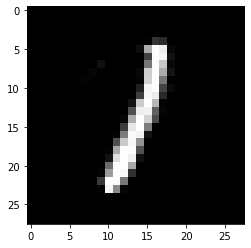

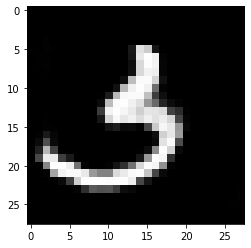

tensor(0.3548, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4511, device='cuda:0', grad_fn=<AddBackward0>)
18th iteration gen_loss: 0.3547712564468384 dis_loss: 0.45112764835357666


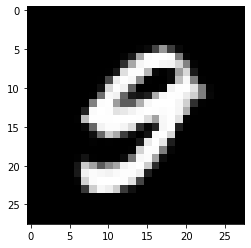

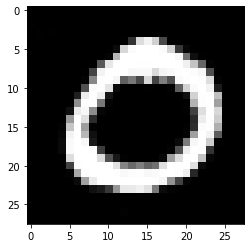

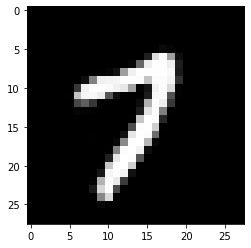

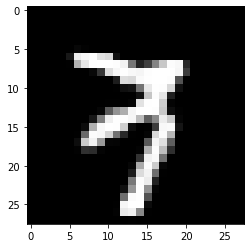

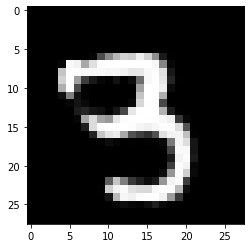

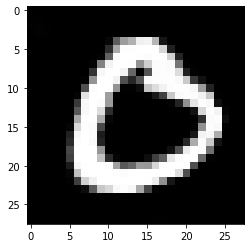

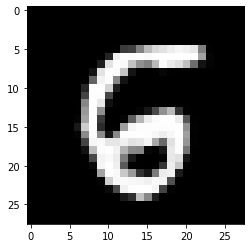

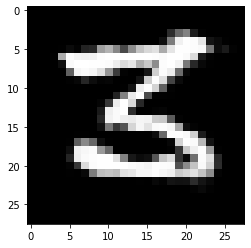

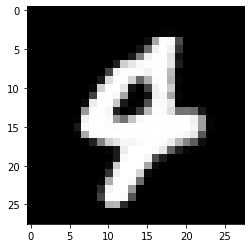

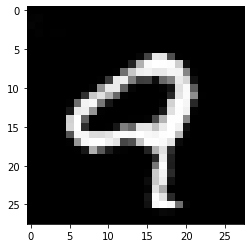

tensor(0.2607, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4473, device='cuda:0', grad_fn=<AddBackward0>)
19th iteration gen_loss: 0.2607432007789612 dis_loss: 0.4472537934780121


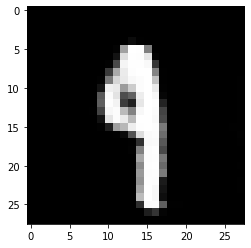

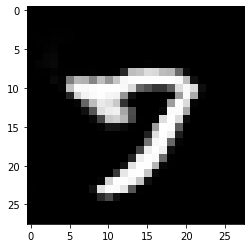

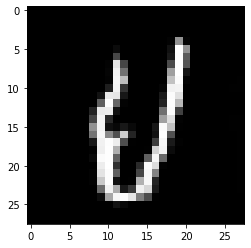

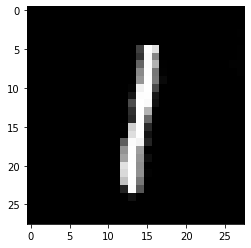

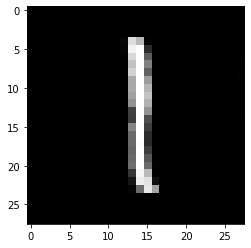

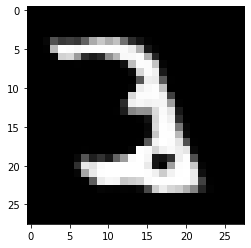

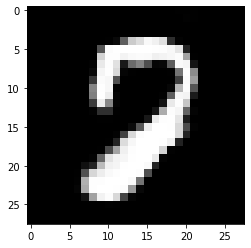

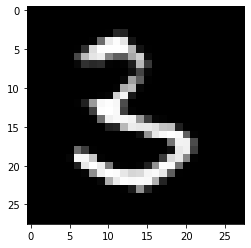

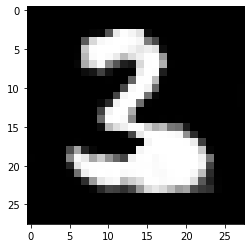

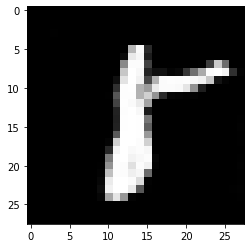

tensor(0.2462, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4445, device='cuda:0', grad_fn=<AddBackward0>)
19th iteration gen_loss: 0.24624329805374146 dis_loss: 0.4444507956504822


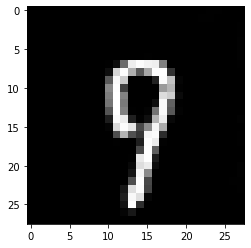

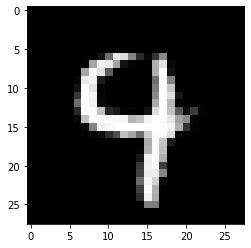

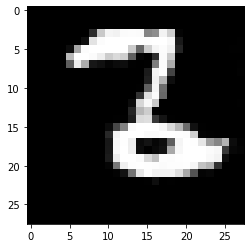

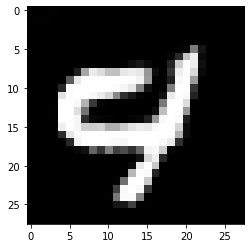

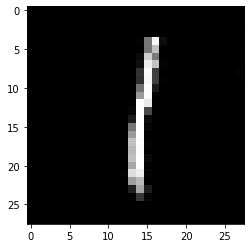

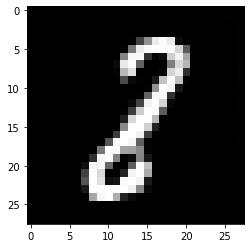

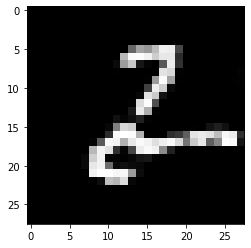

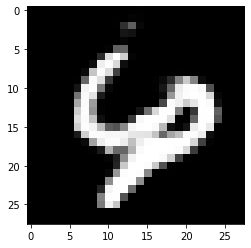

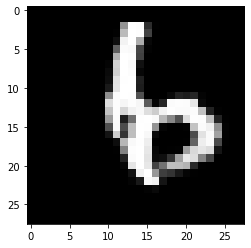

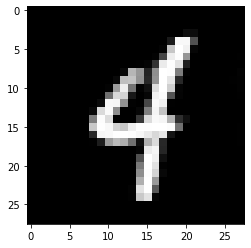

tensor(0.2971, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4465, device='cuda:0', grad_fn=<AddBackward0>)
20th iteration gen_loss: 0.2971149981021881 dis_loss: 0.4464864134788513


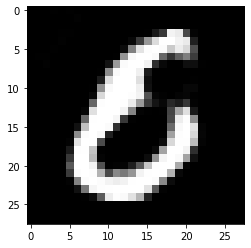

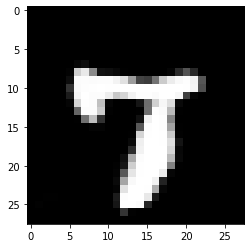

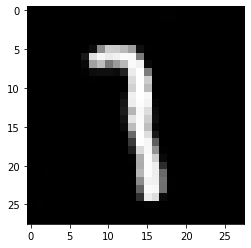

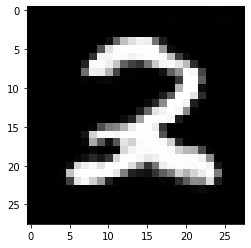

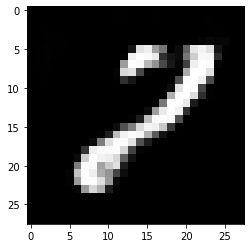

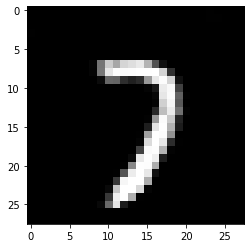

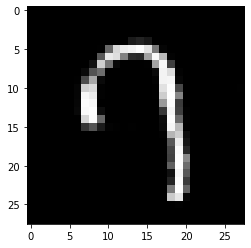

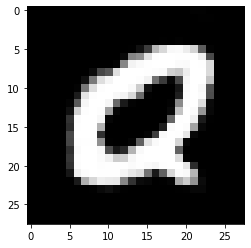

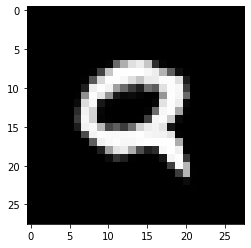

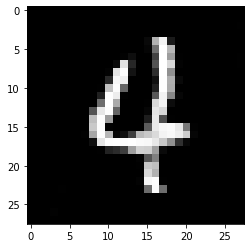

tensor(0.3894, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4504, device='cuda:0', grad_fn=<AddBackward0>)
20th iteration gen_loss: 0.38941362500190735 dis_loss: 0.45040497183799744


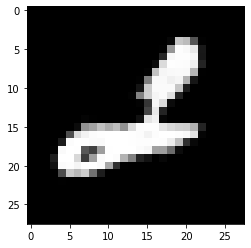

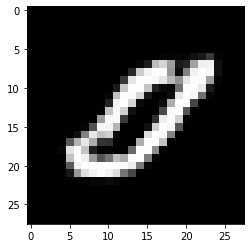

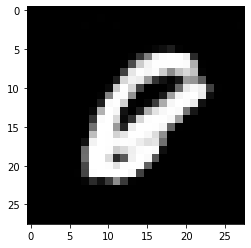

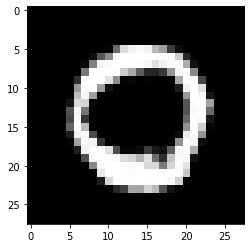

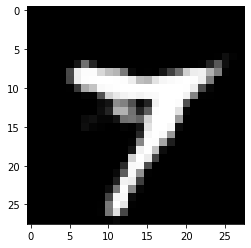

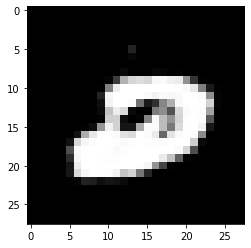

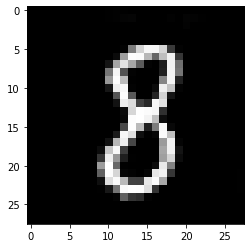

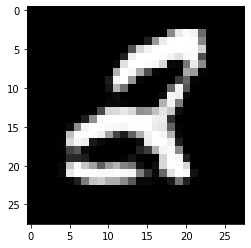

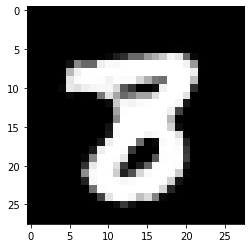

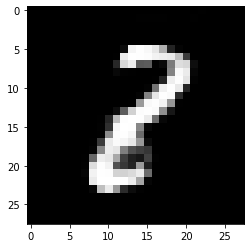

tensor(0.4502, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4644, device='cuda:0', grad_fn=<AddBackward0>)
21th iteration gen_loss: 0.4501817226409912 dis_loss: 0.4644205868244171


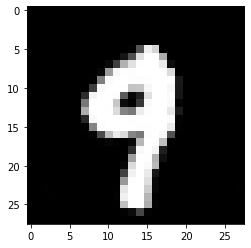

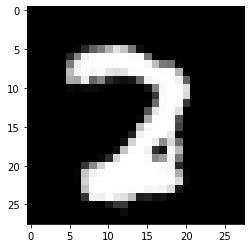

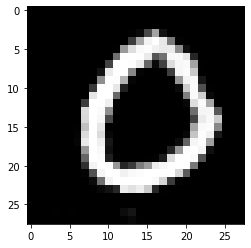

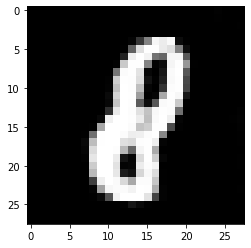

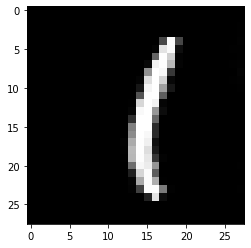

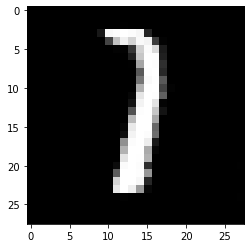

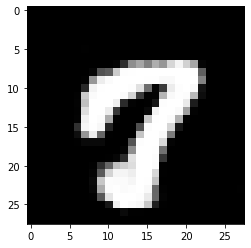

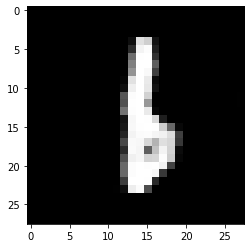

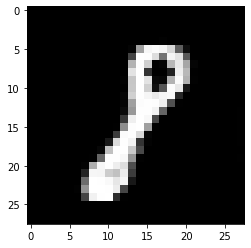

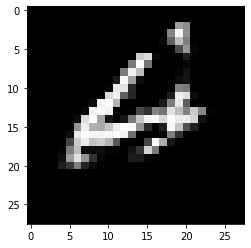

tensor(0.2454, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4510, device='cuda:0', grad_fn=<AddBackward0>)
21th iteration gen_loss: 0.2454003095626831 dis_loss: 0.45097827911376953


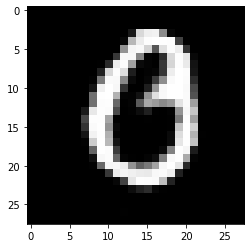

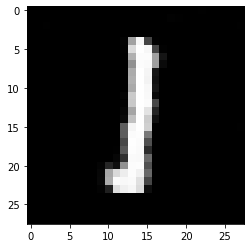

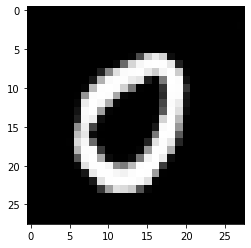

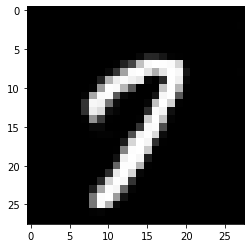

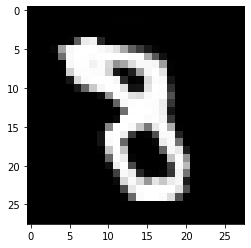

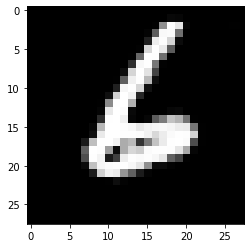

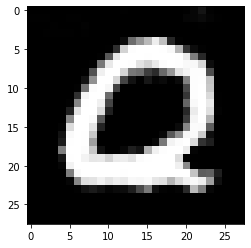

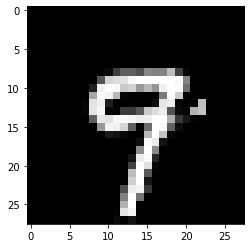

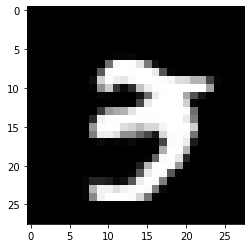

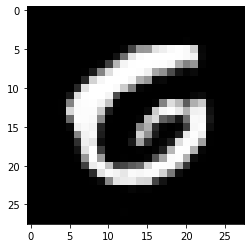

tensor(0.4325, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4608, device='cuda:0', grad_fn=<AddBackward0>)
22th iteration gen_loss: 0.43245482444763184 dis_loss: 0.4607982039451599


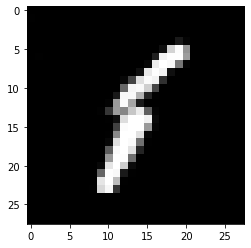

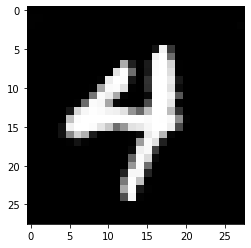

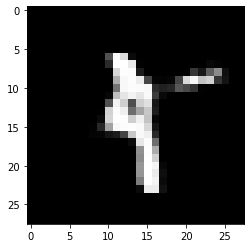

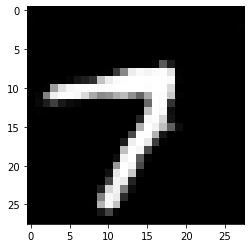

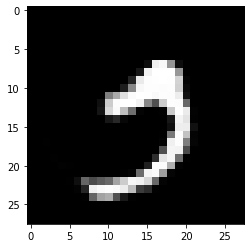

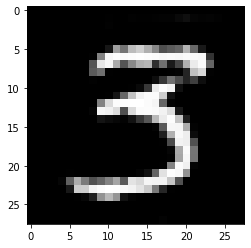

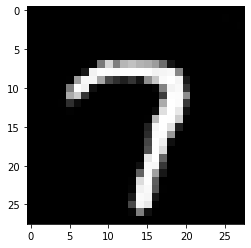

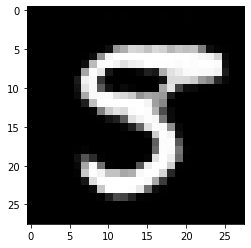

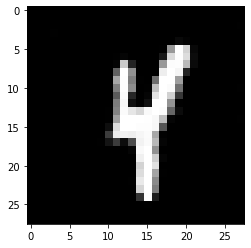

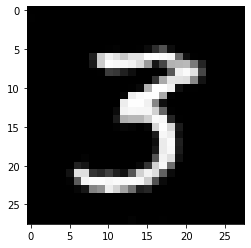

tensor(0.2331, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)
22th iteration gen_loss: 0.2331489622592926 dis_loss: 0.45060235261917114


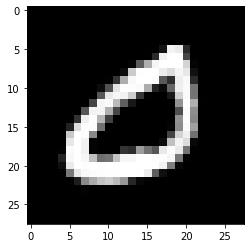

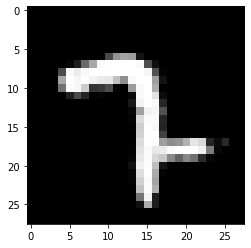

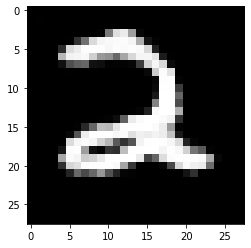

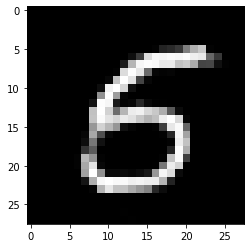

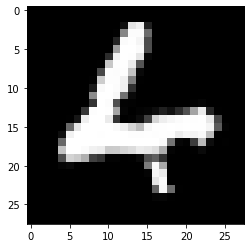

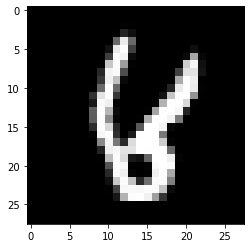

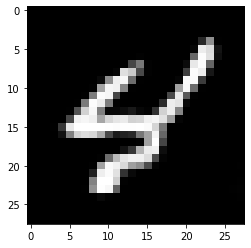

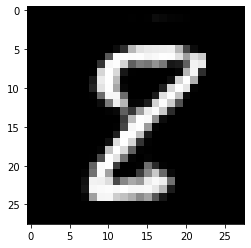

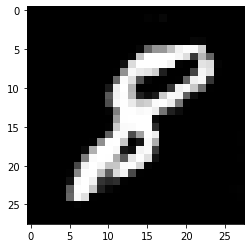

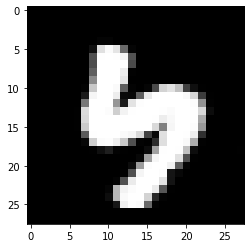

tensor(0.4064, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4500, device='cuda:0', grad_fn=<AddBackward0>)
23th iteration gen_loss: 0.4063777029514313 dis_loss: 0.44996634125709534


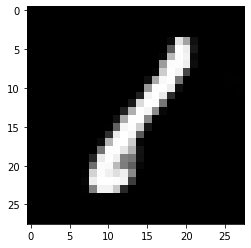

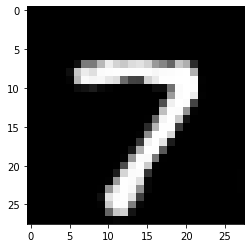

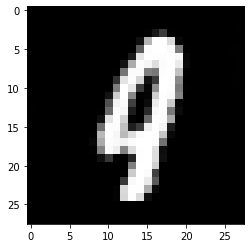

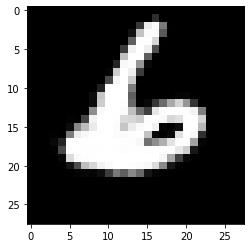

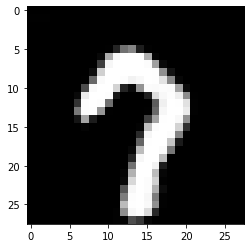

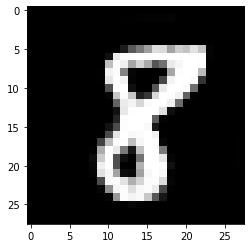

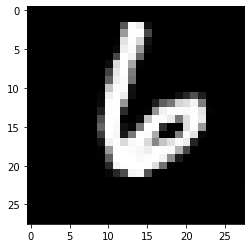

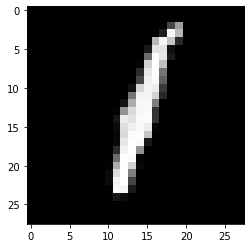

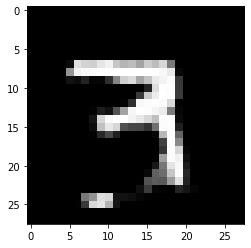

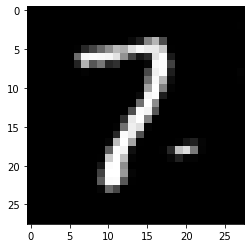

tensor(0.2356, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4597, device='cuda:0', grad_fn=<AddBackward0>)
23th iteration gen_loss: 0.23557111620903015 dis_loss: 0.4597214460372925


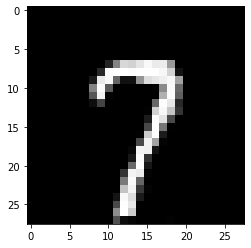

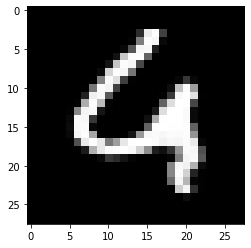

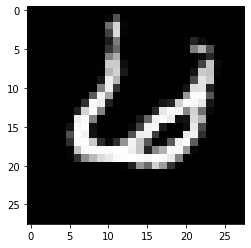

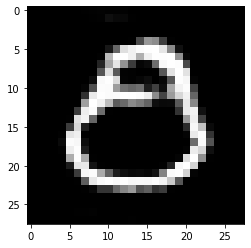

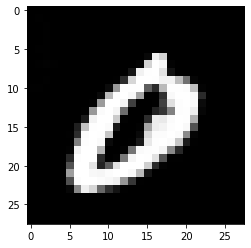

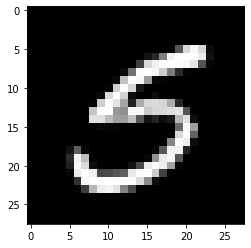

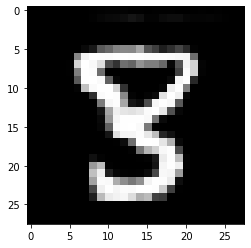

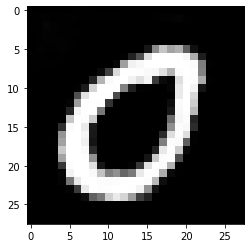

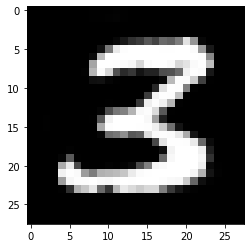

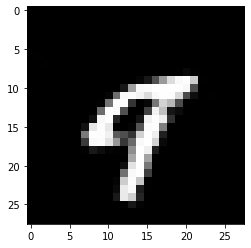

tensor(0.3126, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4265, device='cuda:0', grad_fn=<AddBackward0>)
24th iteration gen_loss: 0.3126327693462372 dis_loss: 0.4265088438987732


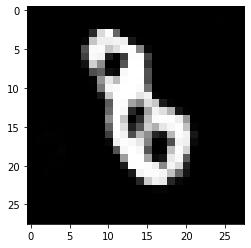

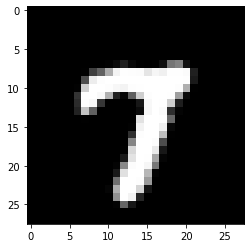

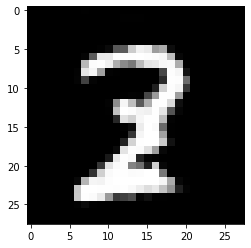

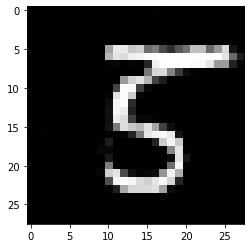

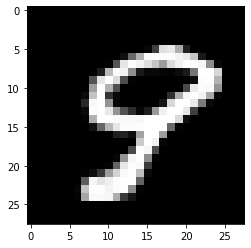

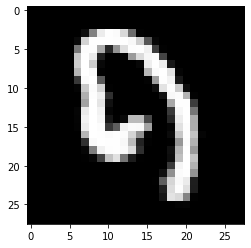

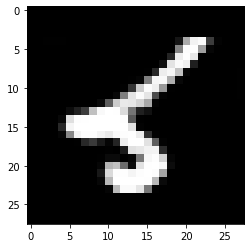

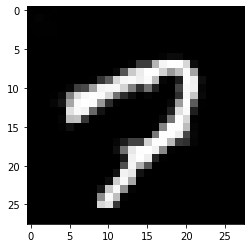

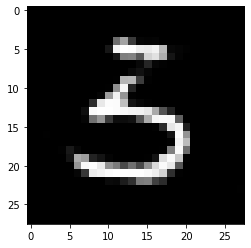

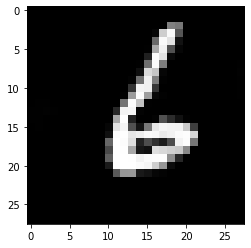

tensor(0.3230, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4304, device='cuda:0', grad_fn=<AddBackward0>)
24th iteration gen_loss: 0.32299160957336426 dis_loss: 0.4304150342941284


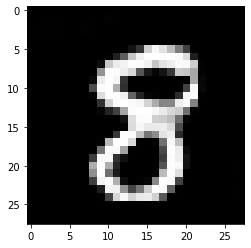

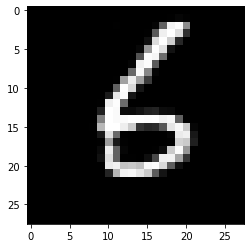

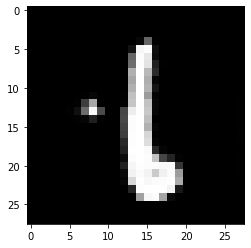

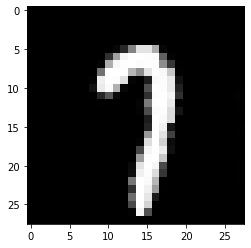

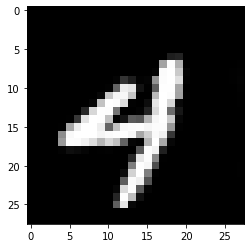

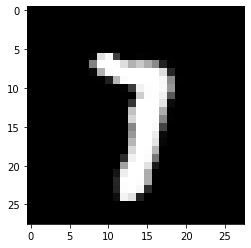

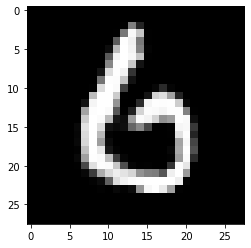

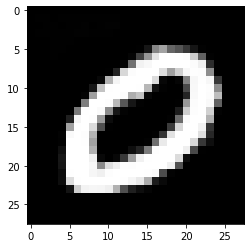

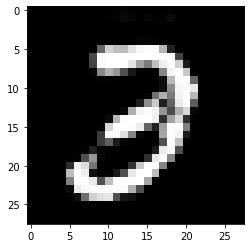

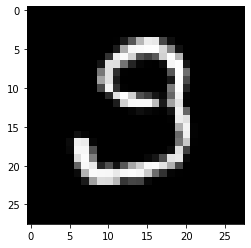

tensor(0.2329, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4553, device='cuda:0', grad_fn=<AddBackward0>)
25th iteration gen_loss: 0.23288628458976746 dis_loss: 0.45532703399658203


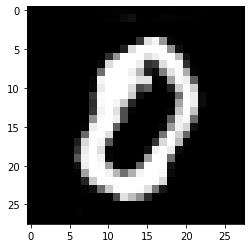

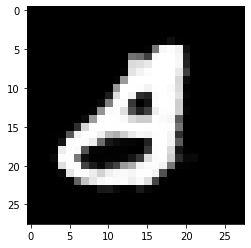

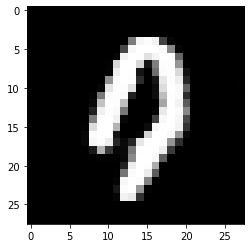

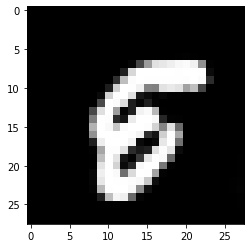

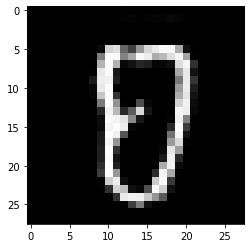

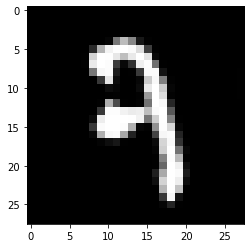

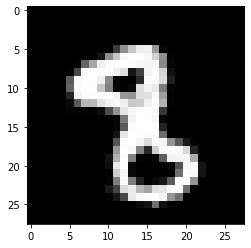

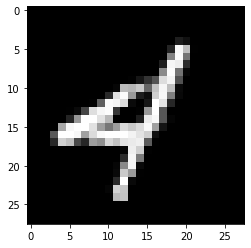

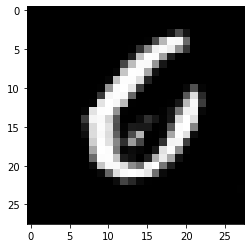

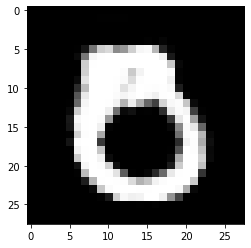

tensor(0.2025, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4656, device='cuda:0', grad_fn=<AddBackward0>)
25th iteration gen_loss: 0.2024536430835724 dis_loss: 0.46555042266845703


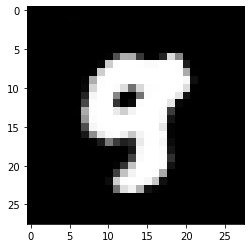

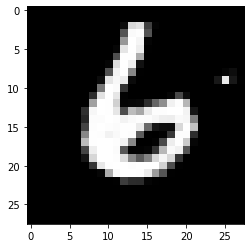

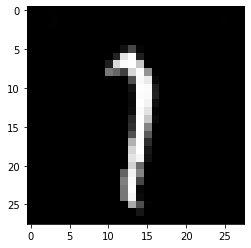

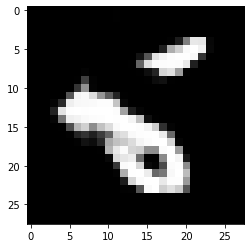

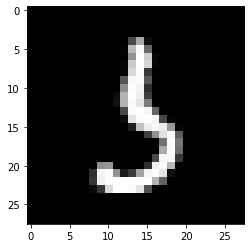

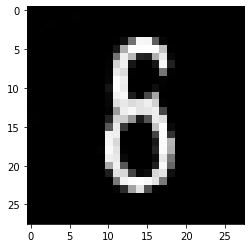

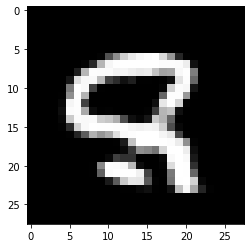

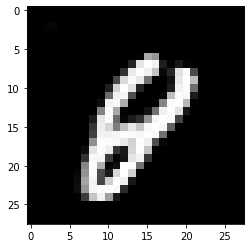

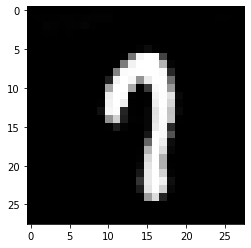

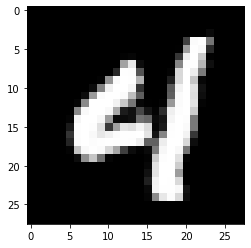

tensor(0.2816, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4506, device='cuda:0', grad_fn=<AddBackward0>)
26th iteration gen_loss: 0.28160011768341064 dis_loss: 0.4506376385688782


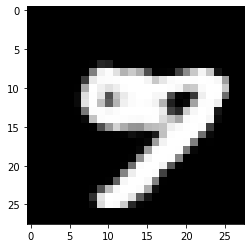

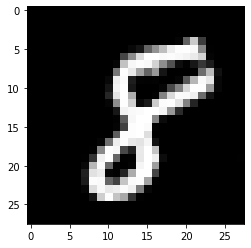

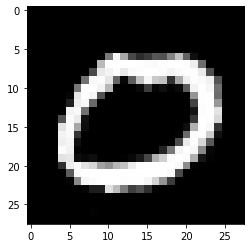

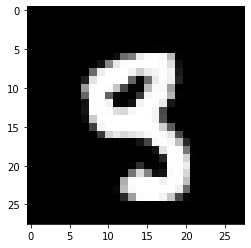

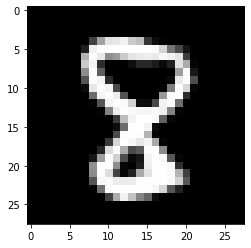

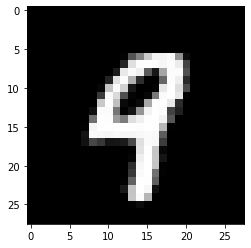

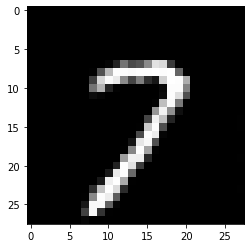

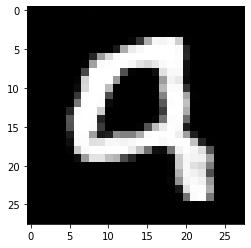

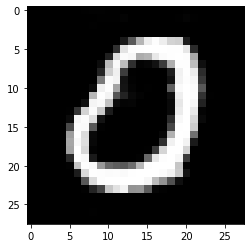

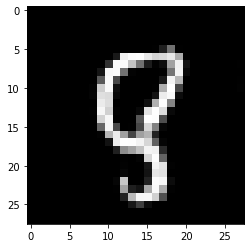

tensor(0.3308, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)
26th iteration gen_loss: 0.330755352973938 dis_loss: 0.44341838359832764


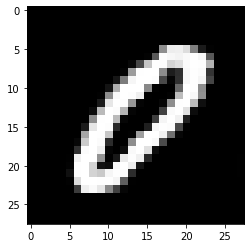

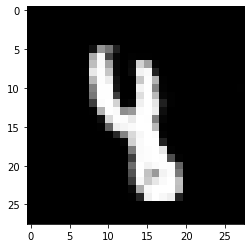

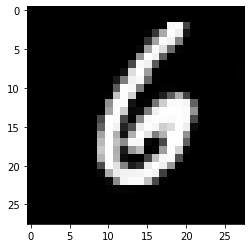

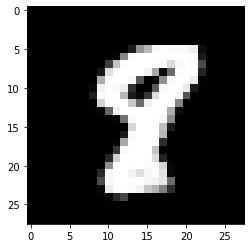

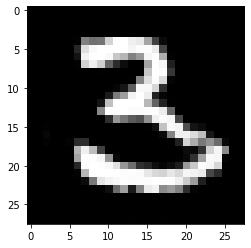

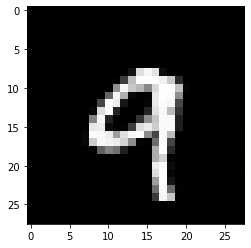

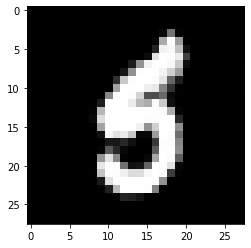

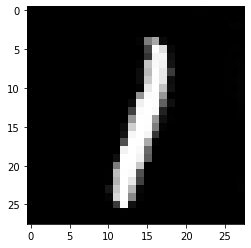

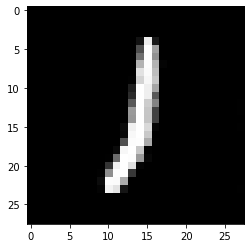

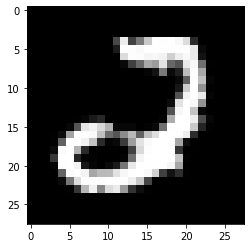

tensor(0.2772, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4434, device='cuda:0', grad_fn=<AddBackward0>)
27th iteration gen_loss: 0.27716064453125 dis_loss: 0.4433683753013611


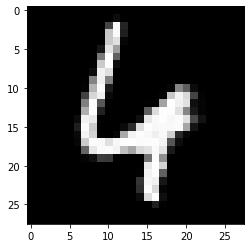

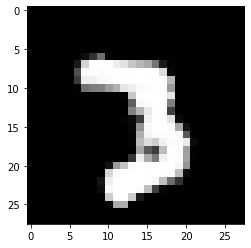

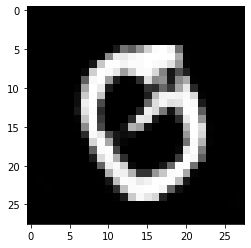

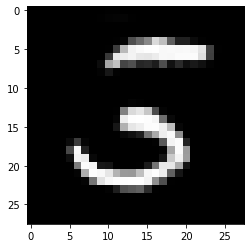

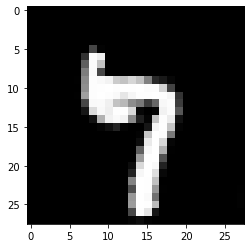

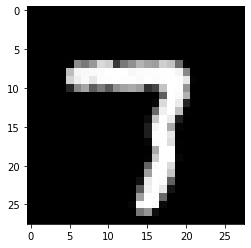

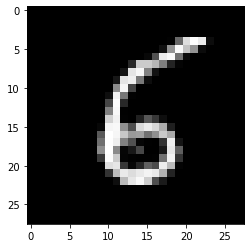

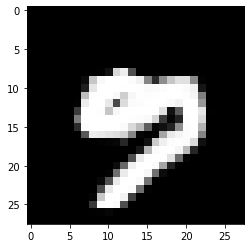

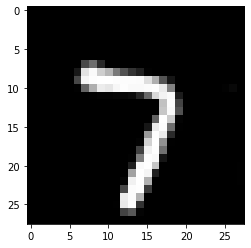

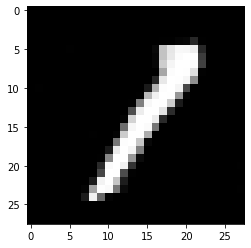

tensor(0.2446, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4603, device='cuda:0', grad_fn=<AddBackward0>)
27th iteration gen_loss: 0.2446206510066986 dis_loss: 0.46034353971481323


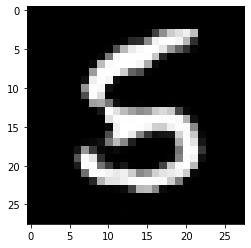

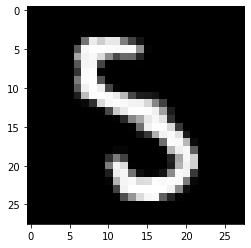

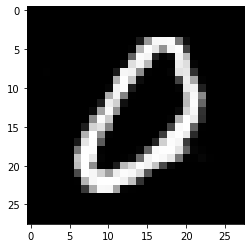

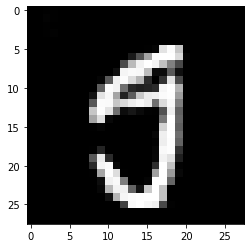

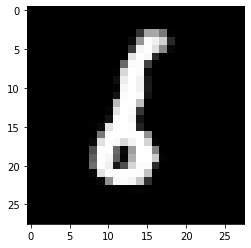

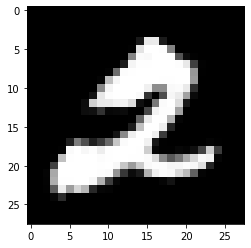

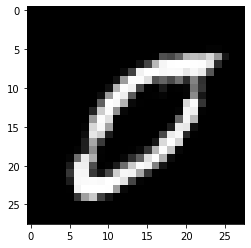

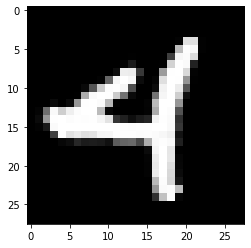

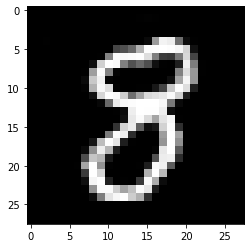

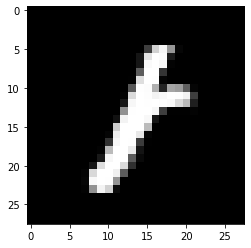

tensor(0.3922, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4645, device='cuda:0', grad_fn=<AddBackward0>)
28th iteration gen_loss: 0.39221620559692383 dis_loss: 0.46452417969703674


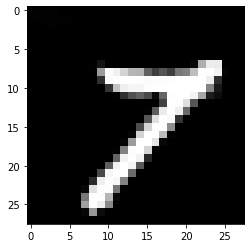

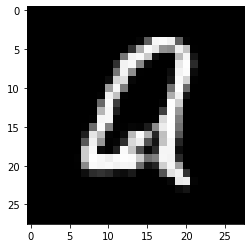

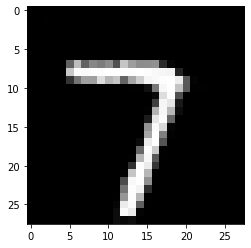

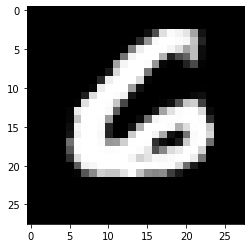

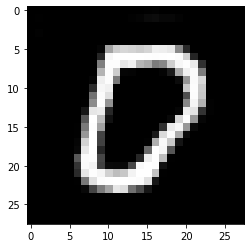

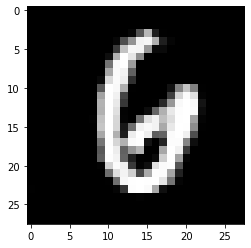

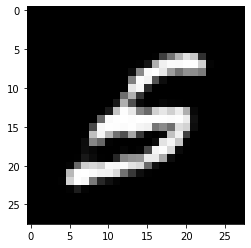

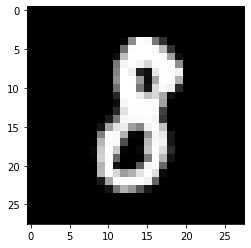

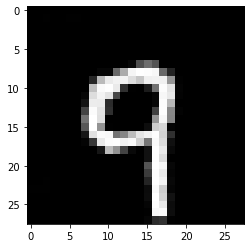

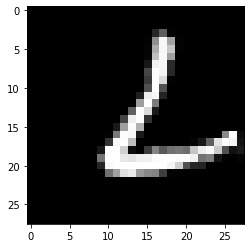

tensor(0.3344, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)
28th iteration gen_loss: 0.33441200852394104 dis_loss: 0.4438462257385254


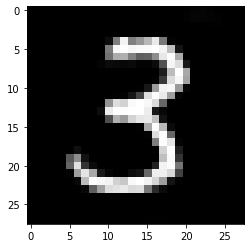

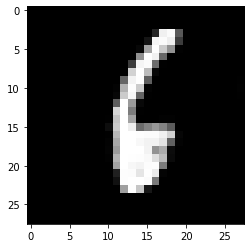

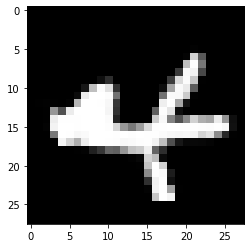

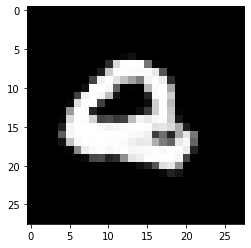

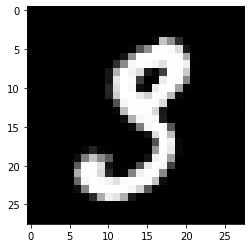

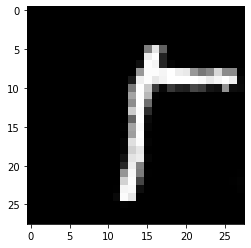

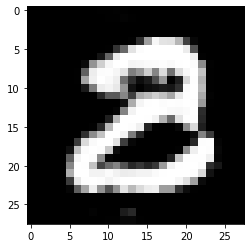

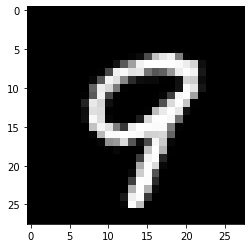

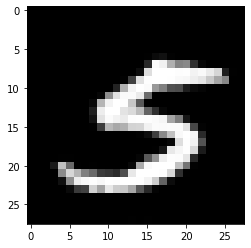

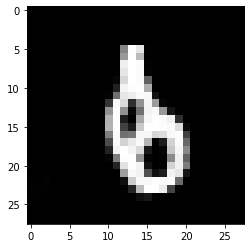

tensor(0.2469, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4474, device='cuda:0', grad_fn=<AddBackward0>)
29th iteration gen_loss: 0.24688705801963806 dis_loss: 0.44742560386657715


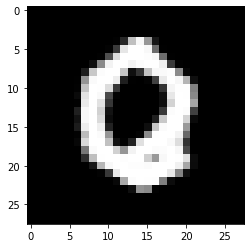

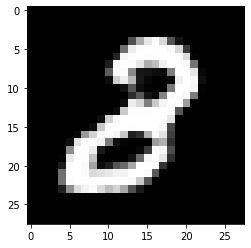

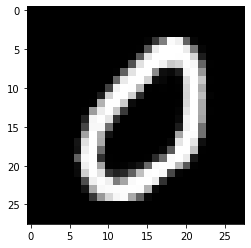

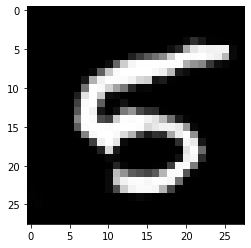

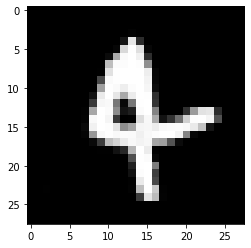

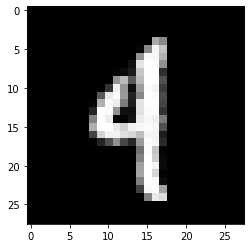

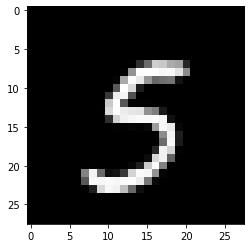

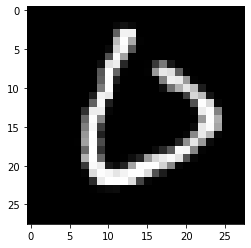

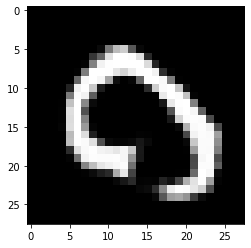

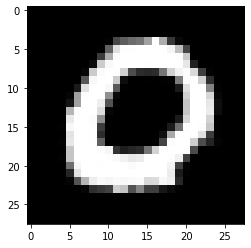

tensor(0.3074, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4409, device='cuda:0', grad_fn=<AddBackward0>)
29th iteration gen_loss: 0.3073650896549225 dis_loss: 0.4408845901489258


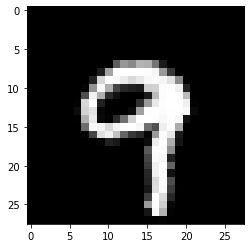

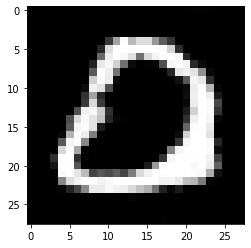

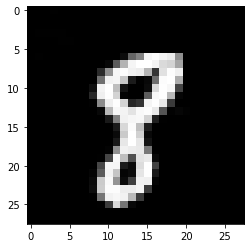

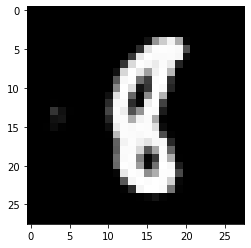

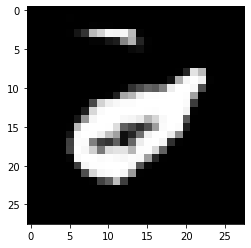

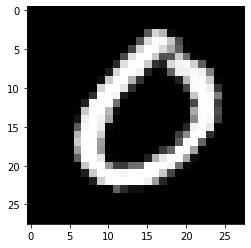

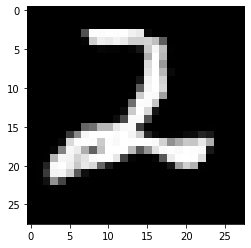

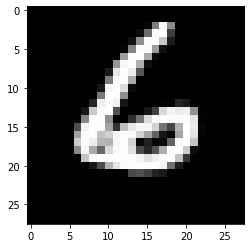

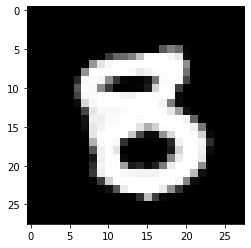

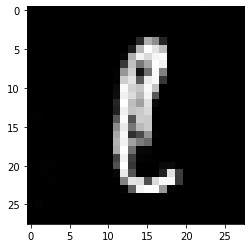

tensor(0.2488, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4395, device='cuda:0', grad_fn=<AddBackward0>)
30th iteration gen_loss: 0.2487603724002838 dis_loss: 0.4394528269767761


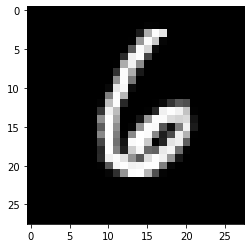

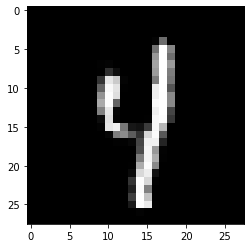

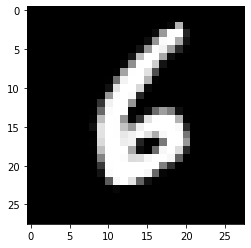

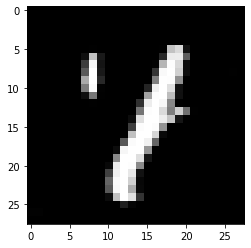

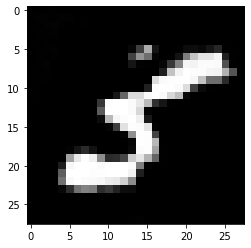

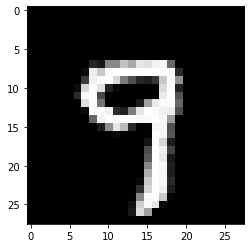

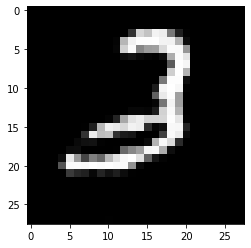

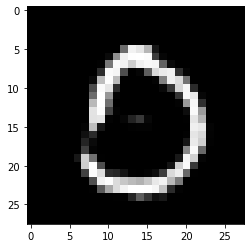

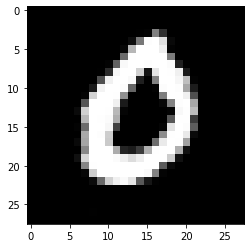

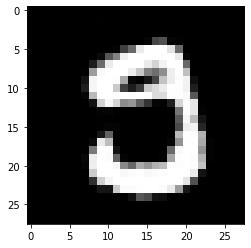

tensor(0.3069, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4386, device='cuda:0', grad_fn=<AddBackward0>)
30th iteration gen_loss: 0.3069338798522949 dis_loss: 0.4386495351791382


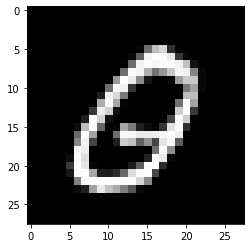

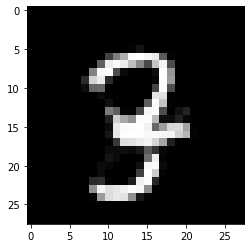

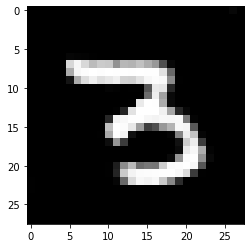

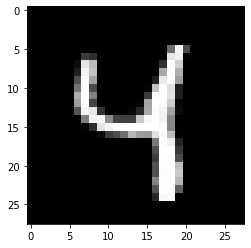

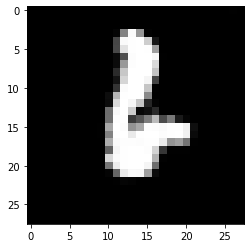

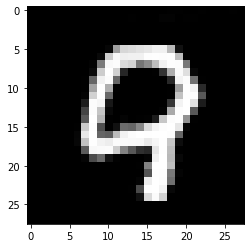

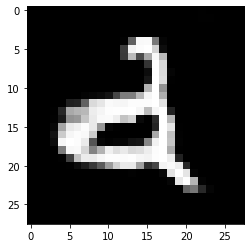

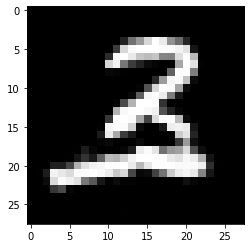

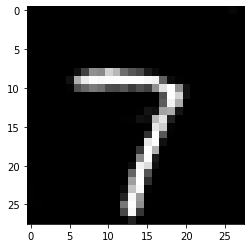

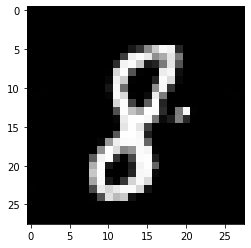

tensor(0.3764, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4508, device='cuda:0', grad_fn=<AddBackward0>)
31th iteration gen_loss: 0.3763829469680786 dis_loss: 0.4508199095726013


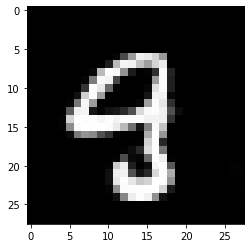

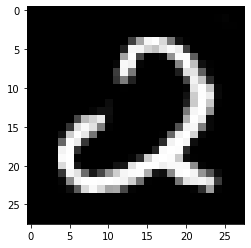

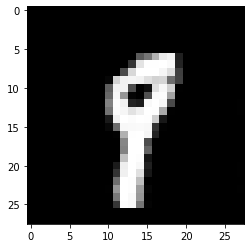

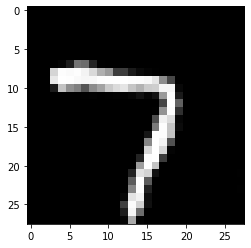

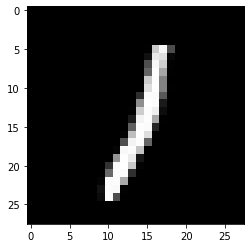

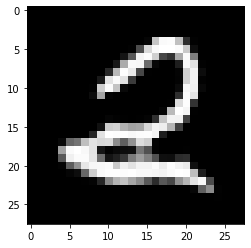

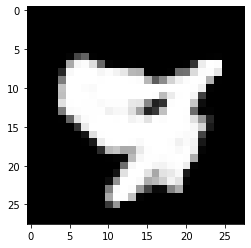

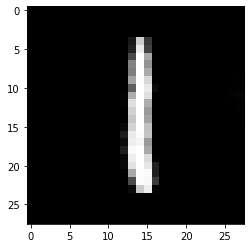

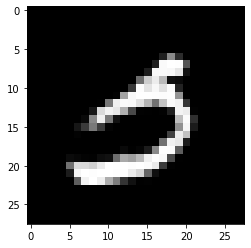

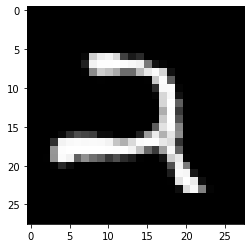

tensor(0.2050, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4617, device='cuda:0', grad_fn=<AddBackward0>)
31th iteration gen_loss: 0.2049933671951294 dis_loss: 0.4616653323173523


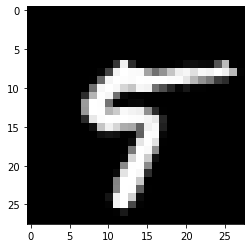

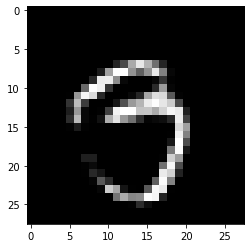

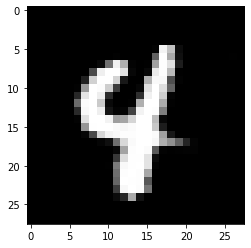

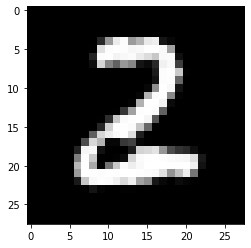

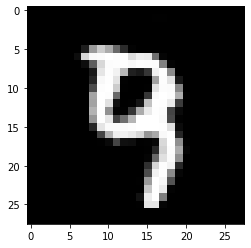

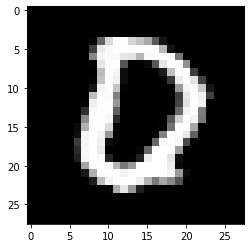

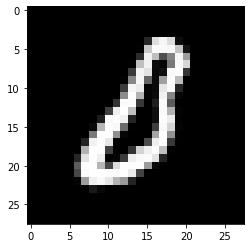

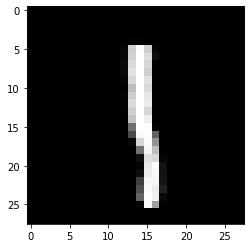

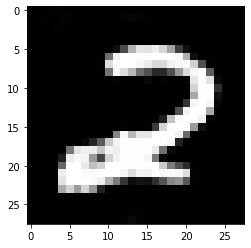

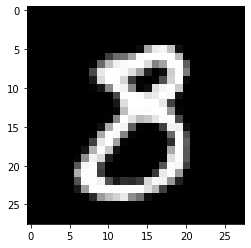

tensor(0.2869, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4489, device='cuda:0', grad_fn=<AddBackward0>)
32th iteration gen_loss: 0.2868536412715912 dis_loss: 0.44888752698898315


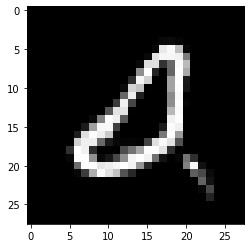

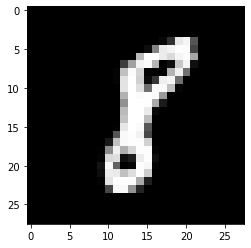

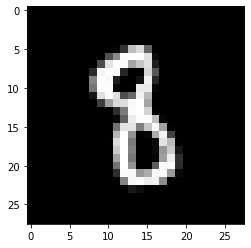

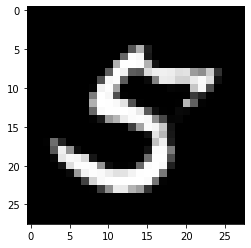

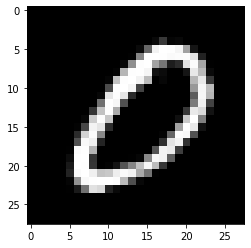

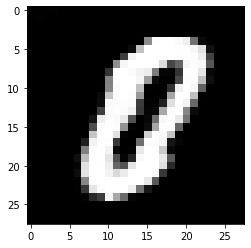

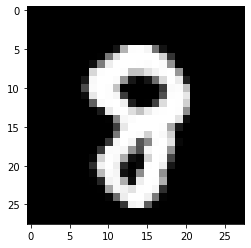

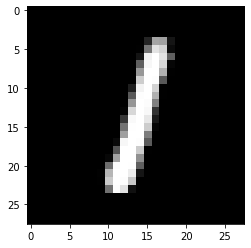

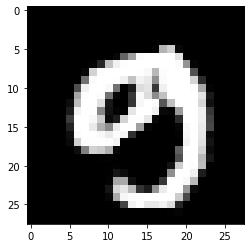

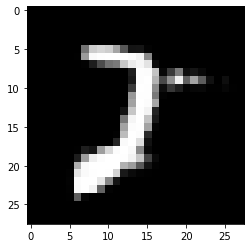

tensor(0.2686, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4460, device='cuda:0', grad_fn=<AddBackward0>)
32th iteration gen_loss: 0.2686043083667755 dis_loss: 0.4460498094558716


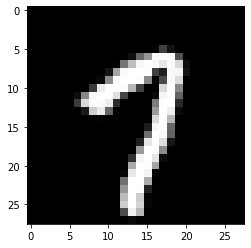

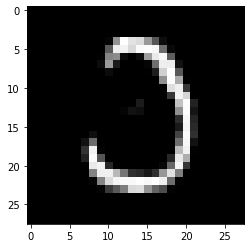

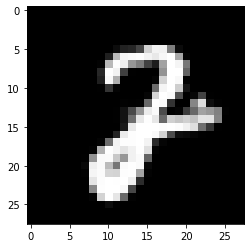

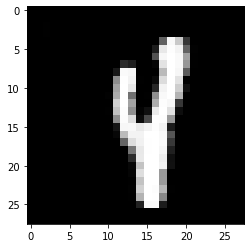

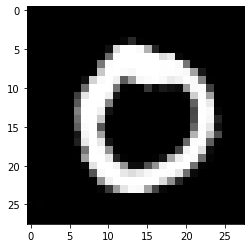

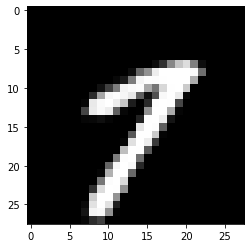

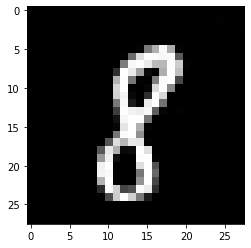

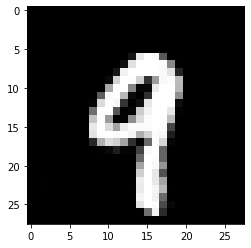

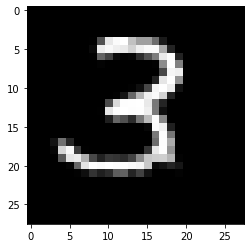

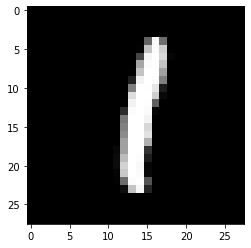

tensor(0.2381, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4400, device='cuda:0', grad_fn=<AddBackward0>)
33th iteration gen_loss: 0.23807230591773987 dis_loss: 0.4400084614753723


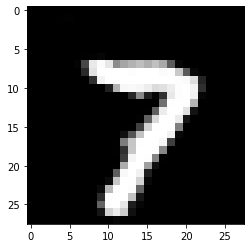

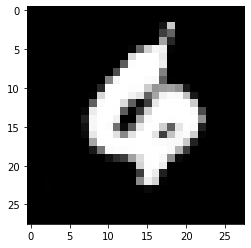

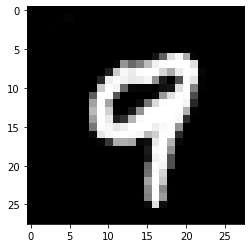

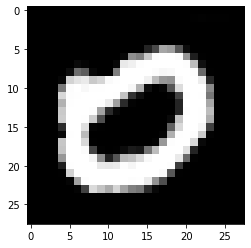

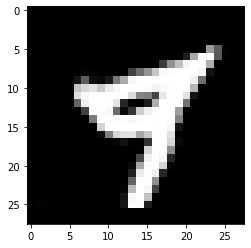

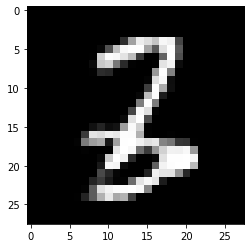

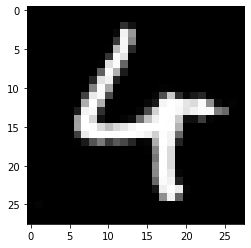

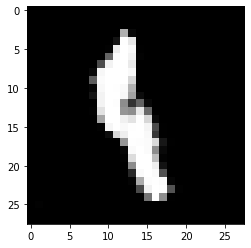

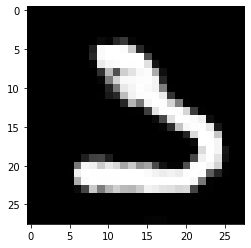

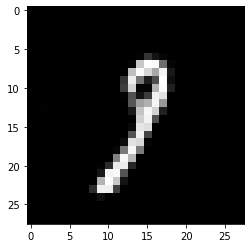

tensor(0.3632, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4480, device='cuda:0', grad_fn=<AddBackward0>)
33th iteration gen_loss: 0.36320069432258606 dis_loss: 0.4480113983154297


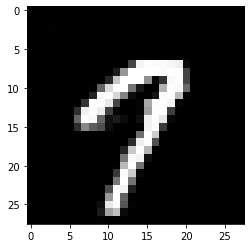

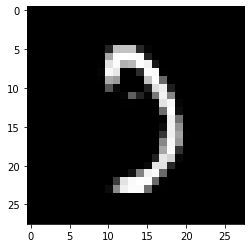

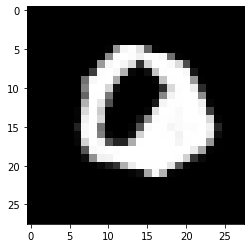

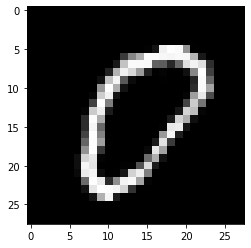

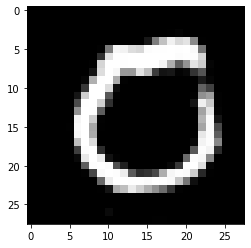

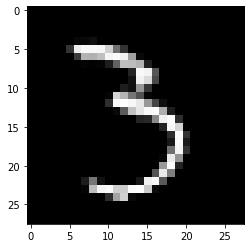

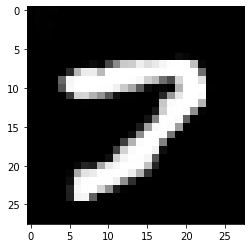

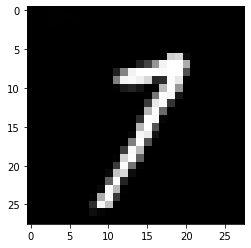

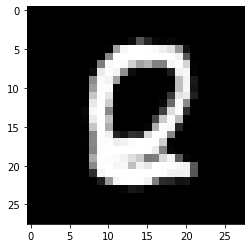

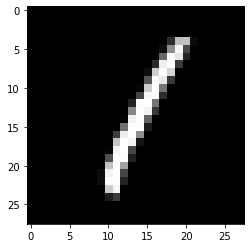

tensor(0.2165, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4666, device='cuda:0', grad_fn=<AddBackward0>)
34th iteration gen_loss: 0.21653316915035248 dis_loss: 0.46659401059150696


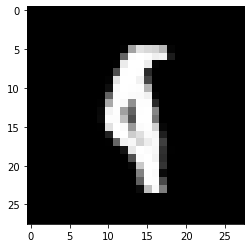

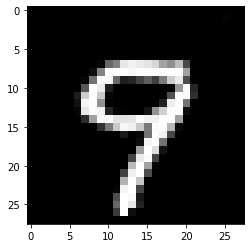

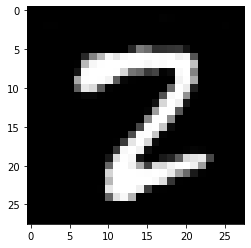

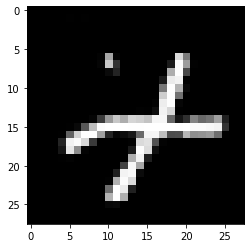

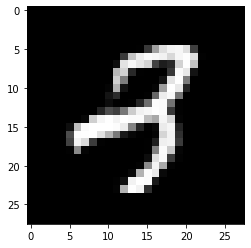

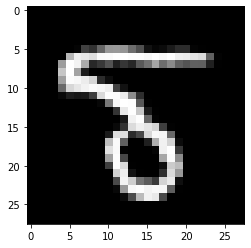

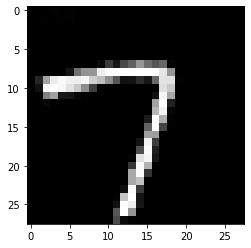

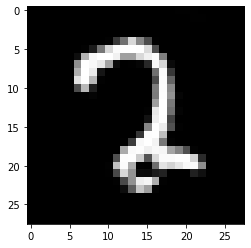

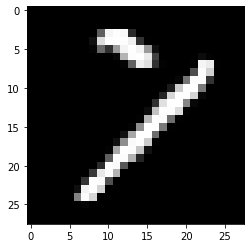

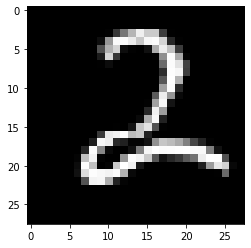

tensor(0.2510, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4523, device='cuda:0', grad_fn=<AddBackward0>)
34th iteration gen_loss: 0.2509995698928833 dis_loss: 0.45228004455566406


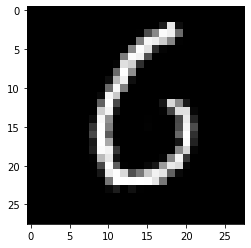

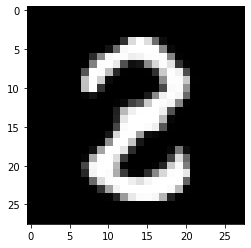

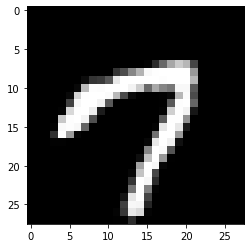

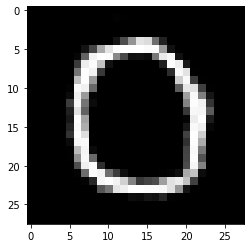

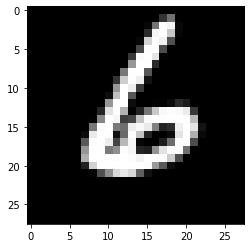

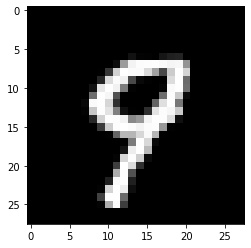

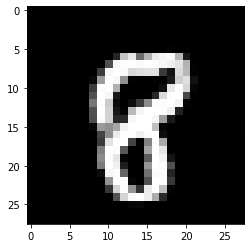

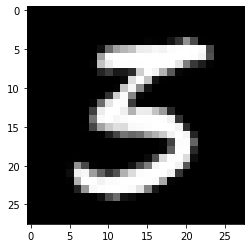

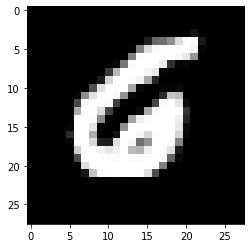

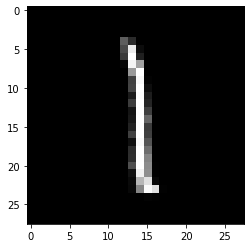

tensor(0.3621, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4635, device='cuda:0', grad_fn=<AddBackward0>)
35th iteration gen_loss: 0.36209237575531006 dis_loss: 0.463459312915802


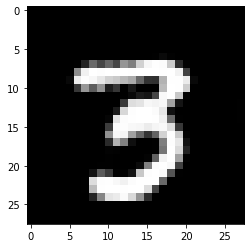

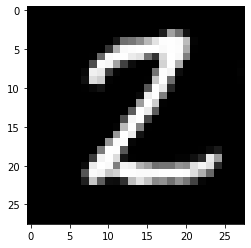

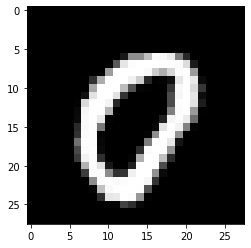

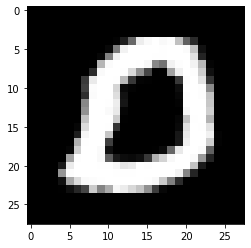

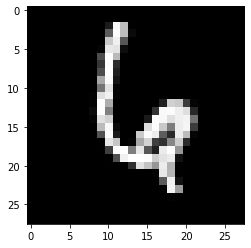

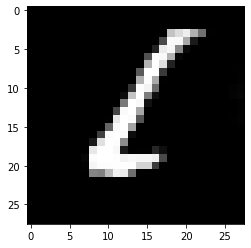

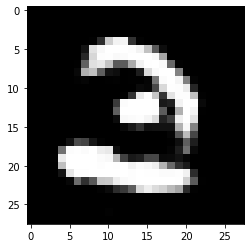

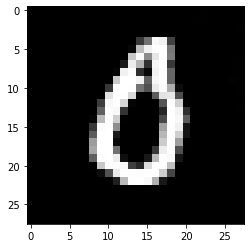

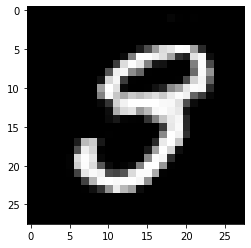

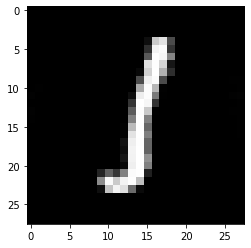

tensor(0.3612, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4534, device='cuda:0', grad_fn=<AddBackward0>)
35th iteration gen_loss: 0.3612176179885864 dis_loss: 0.4534403681755066


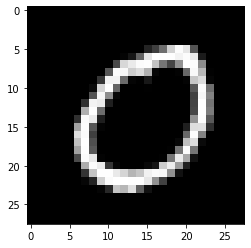

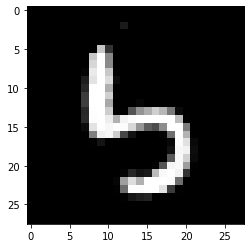

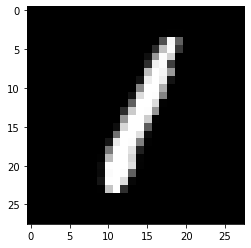

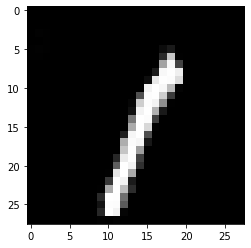

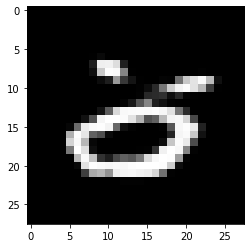

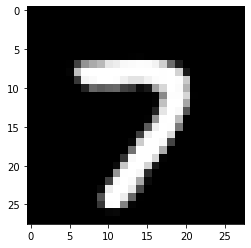

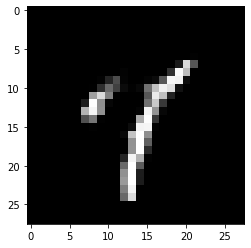

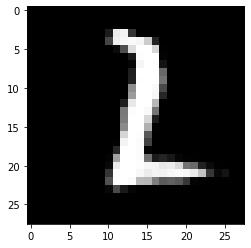

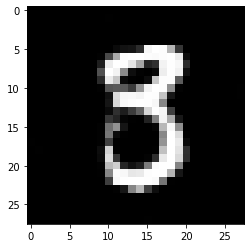

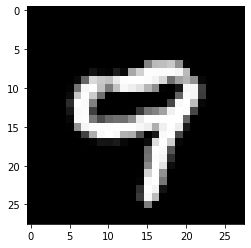

tensor(0.3955, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4441, device='cuda:0', grad_fn=<AddBackward0>)
36th iteration gen_loss: 0.3955068588256836 dis_loss: 0.44405215978622437


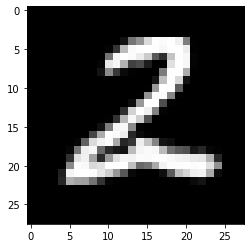

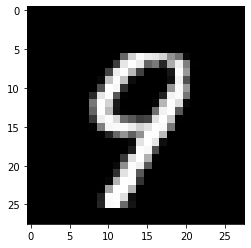

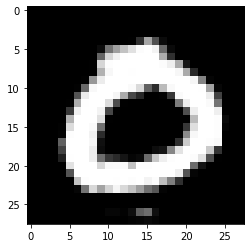

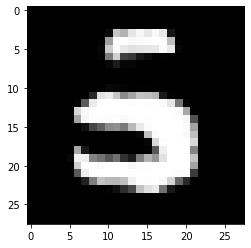

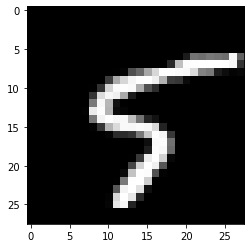

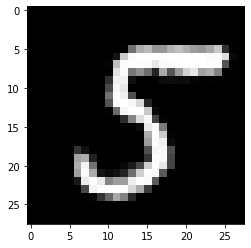

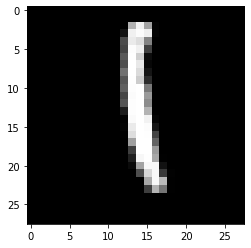

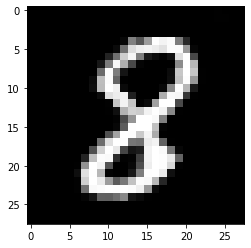

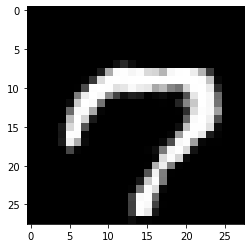

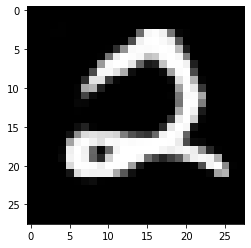

tensor(0.3160, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4438, device='cuda:0', grad_fn=<AddBackward0>)
36th iteration gen_loss: 0.3159946799278259 dis_loss: 0.44382989406585693


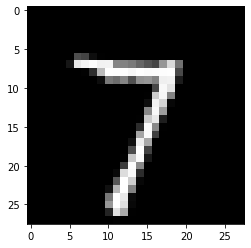

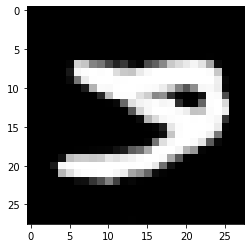

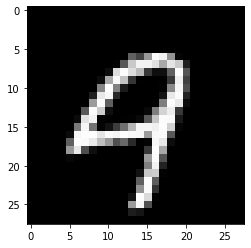

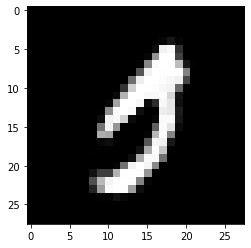

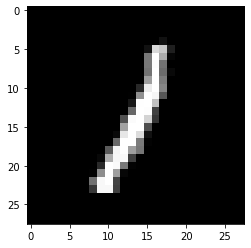

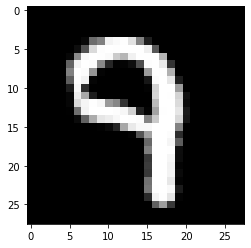

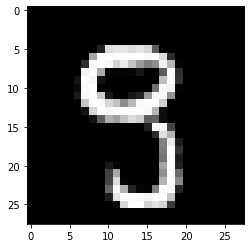

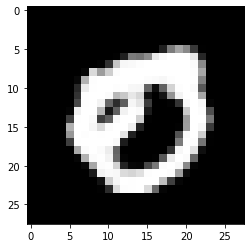

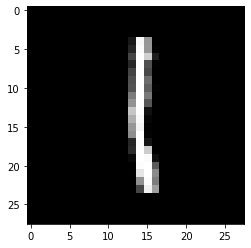

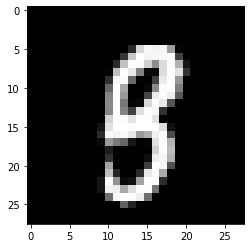

tensor(0.3050, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4566, device='cuda:0', grad_fn=<AddBackward0>)
37th iteration gen_loss: 0.3049865961074829 dis_loss: 0.45664191246032715


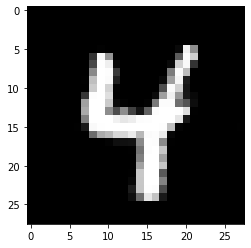

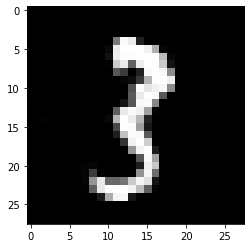

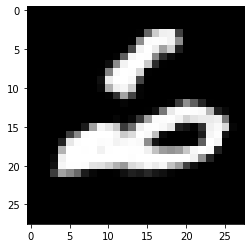

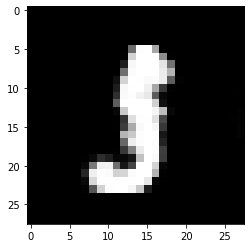

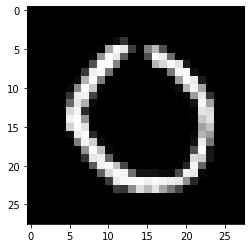

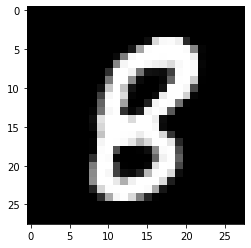

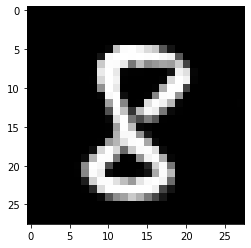

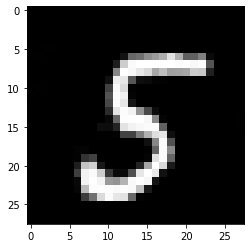

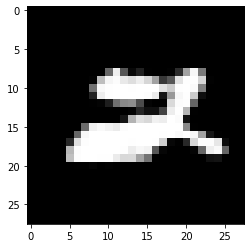

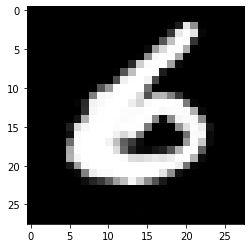

tensor(0.3645, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)
37th iteration gen_loss: 0.36453112959861755 dis_loss: 0.4550042450428009


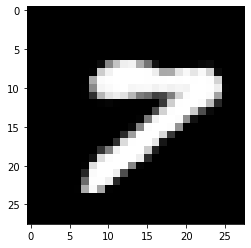

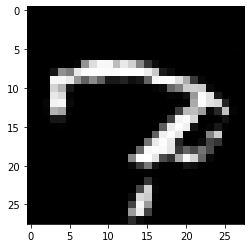

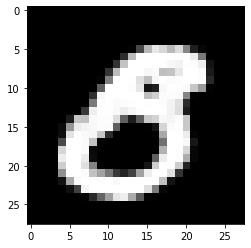

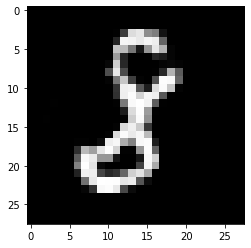

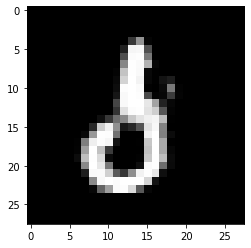

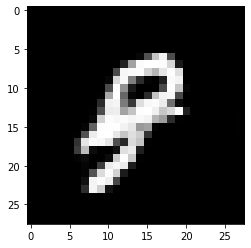

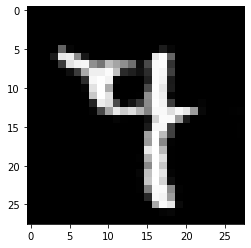

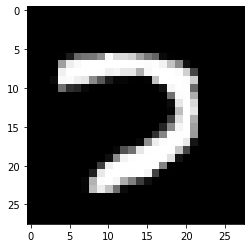

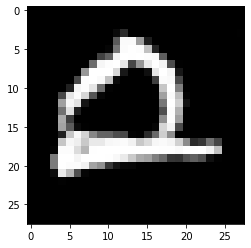

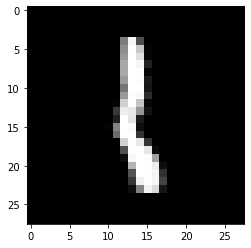

tensor(0.2697, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4536, device='cuda:0', grad_fn=<AddBackward0>)
38th iteration gen_loss: 0.26971372961997986 dis_loss: 0.4535769820213318


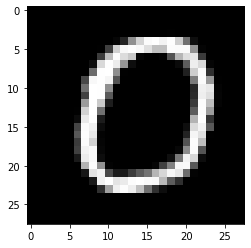

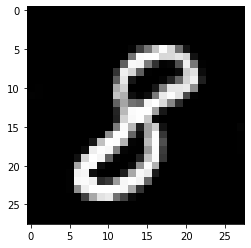

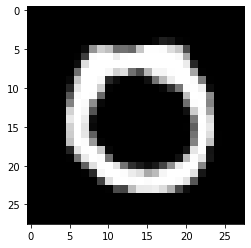

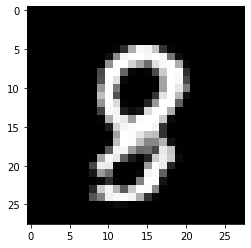

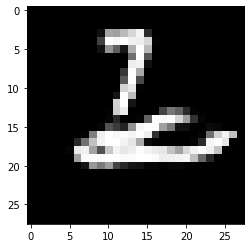

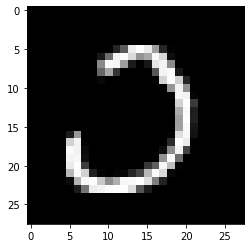

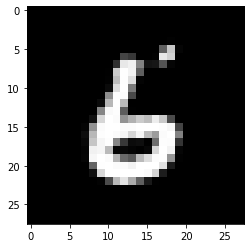

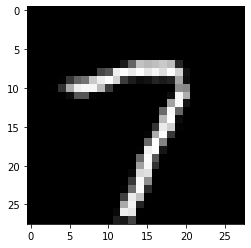

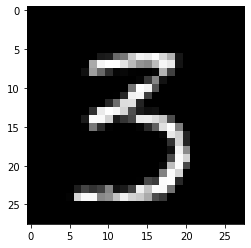

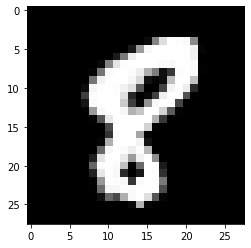

tensor(0.3576, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4515, device='cuda:0', grad_fn=<AddBackward0>)
38th iteration gen_loss: 0.3576072156429291 dis_loss: 0.4514923691749573


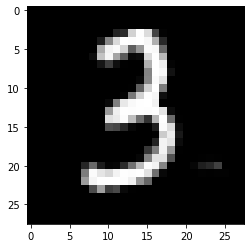

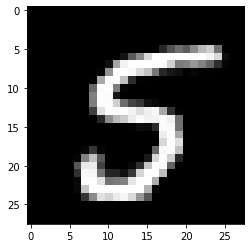

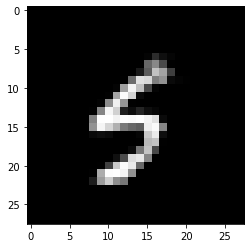

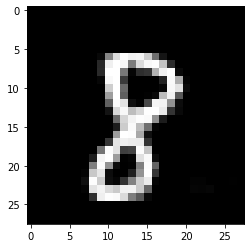

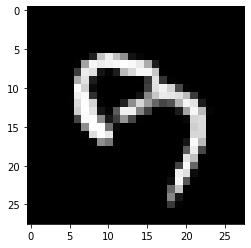

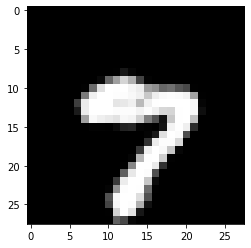

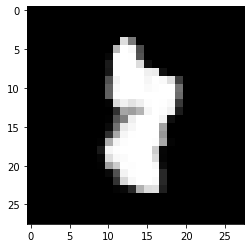

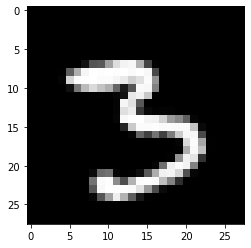

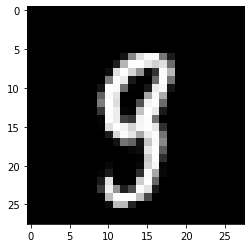

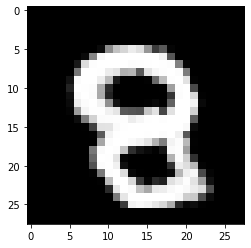

tensor(0.2314, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4593, device='cuda:0', grad_fn=<AddBackward0>)
39th iteration gen_loss: 0.2313833385705948 dis_loss: 0.4592684805393219


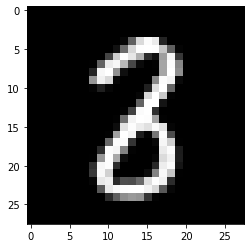

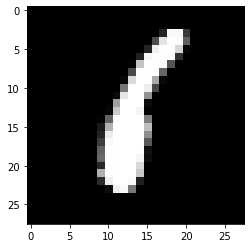

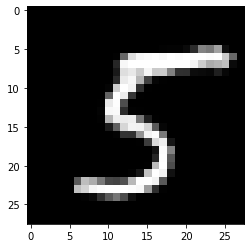

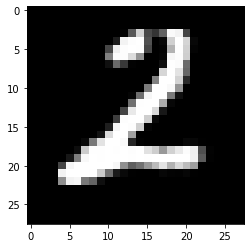

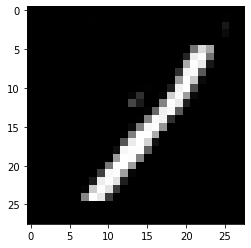

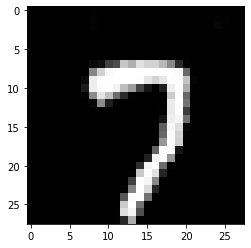

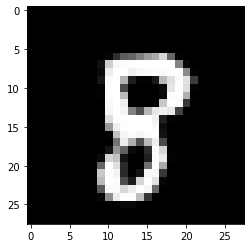

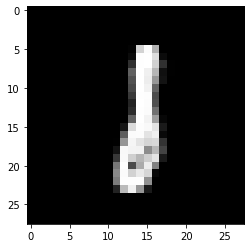

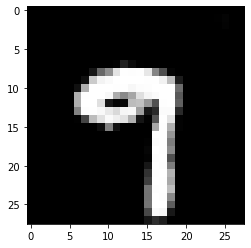

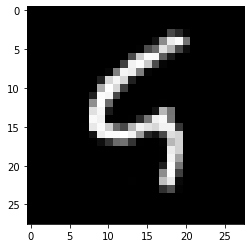

tensor(0.2748, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4367, device='cuda:0', grad_fn=<AddBackward0>)
39th iteration gen_loss: 0.2747876048088074 dis_loss: 0.4367462992668152


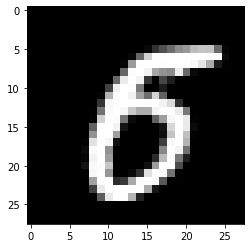

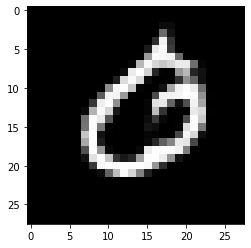

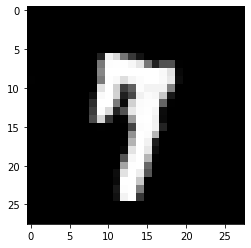

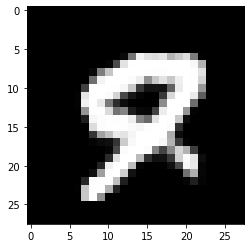

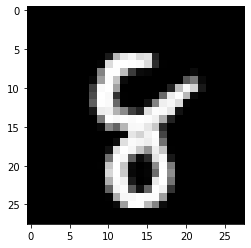

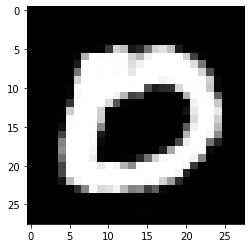

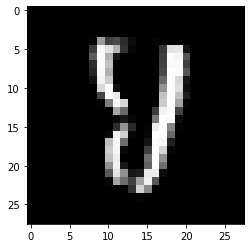

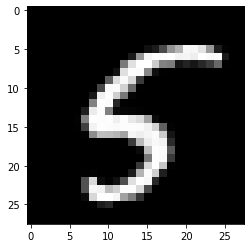

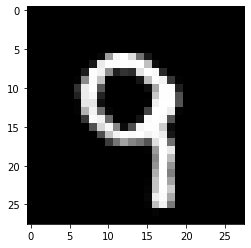

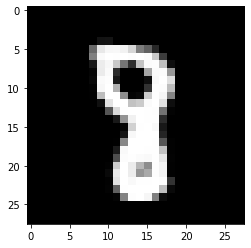

tensor(0.1927, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4789, device='cuda:0', grad_fn=<AddBackward0>)
40th iteration gen_loss: 0.19270634651184082 dis_loss: 0.47891461849212646


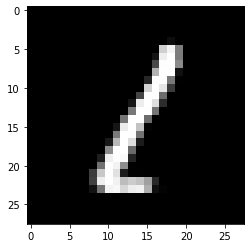

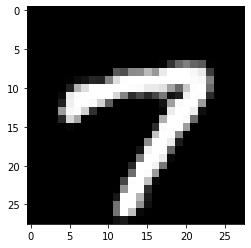

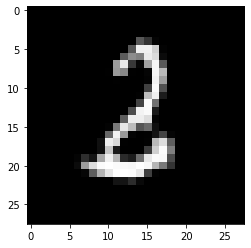

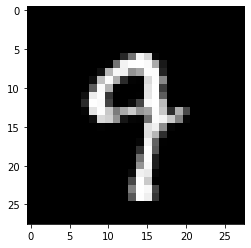

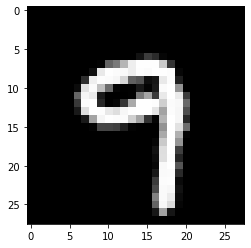

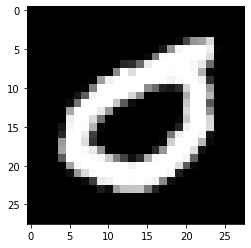

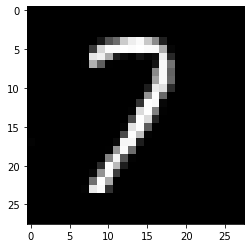

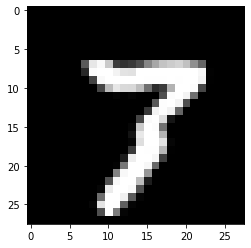

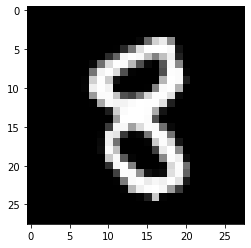

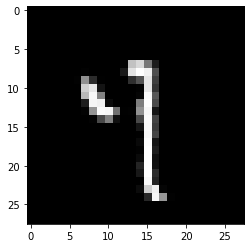

tensor(0.2562, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4558, device='cuda:0', grad_fn=<AddBackward0>)
40th iteration gen_loss: 0.25622624158859253 dis_loss: 0.45576027035713196


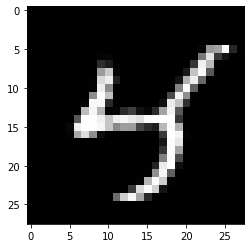

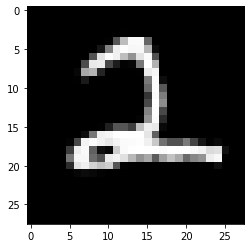

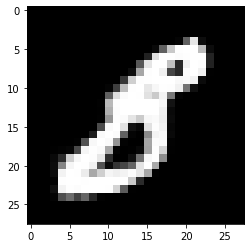

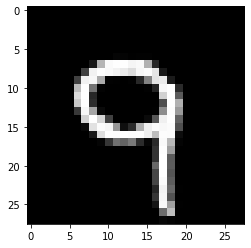

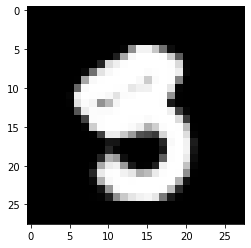

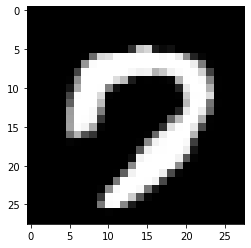

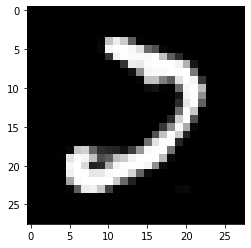

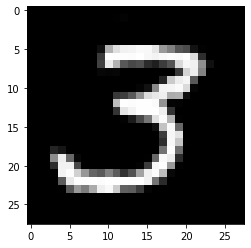

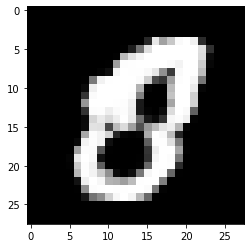

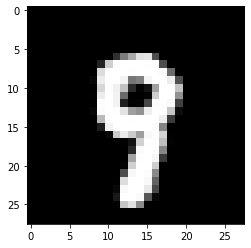

tensor(0.3169, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4587, device='cuda:0', grad_fn=<AddBackward0>)
41th iteration gen_loss: 0.3169257342815399 dis_loss: 0.45873427391052246


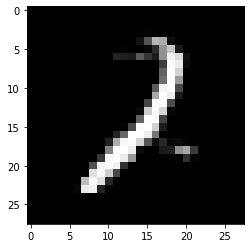

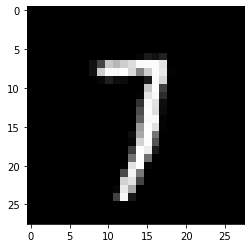

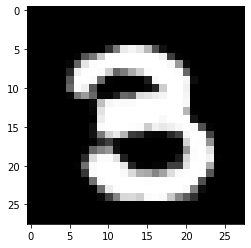

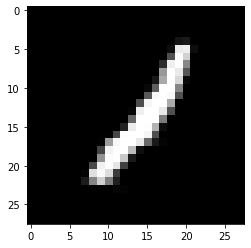

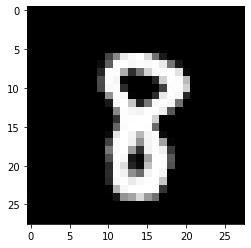

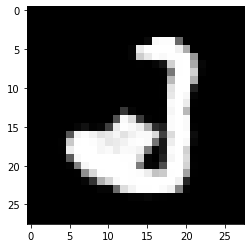

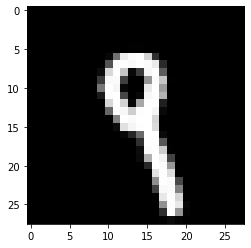

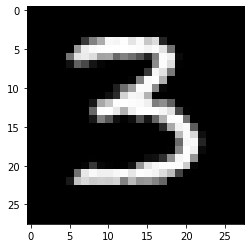

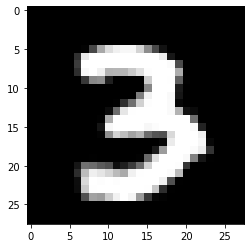

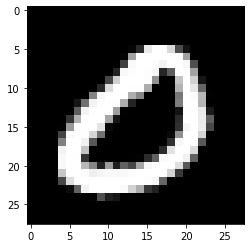

tensor(0.2354, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4554, device='cuda:0', grad_fn=<AddBackward0>)
41th iteration gen_loss: 0.23535765707492828 dis_loss: 0.4553821086883545


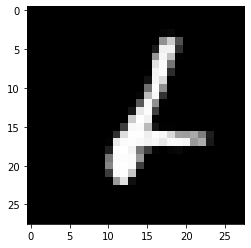

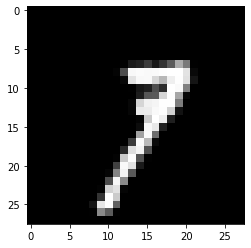

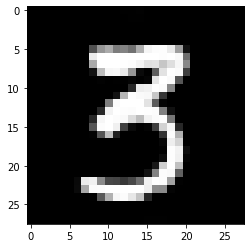

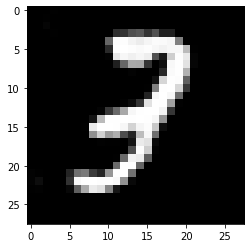

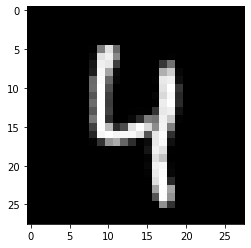

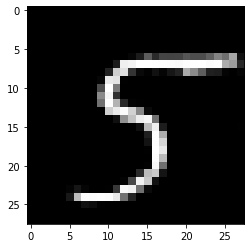

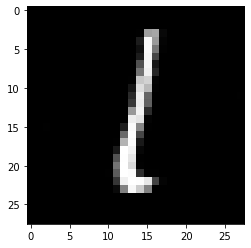

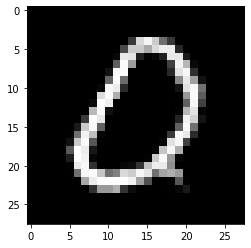

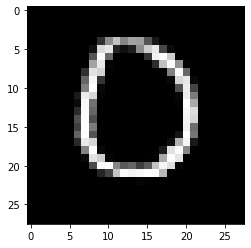

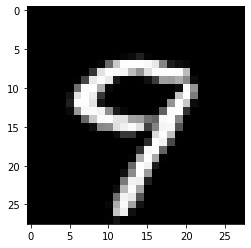

tensor(0.2493, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4575, device='cuda:0', grad_fn=<AddBackward0>)
42th iteration gen_loss: 0.24933382868766785 dis_loss: 0.4574846625328064


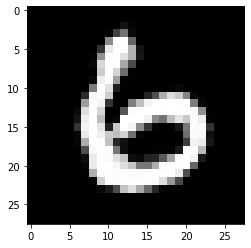

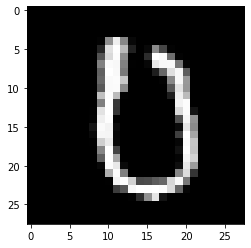

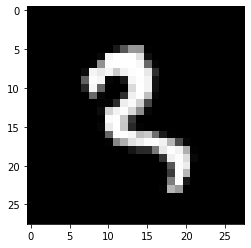

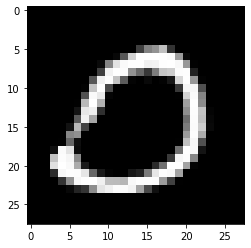

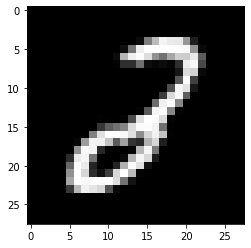

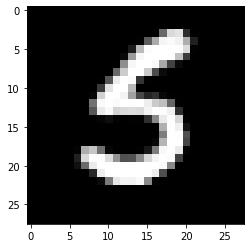

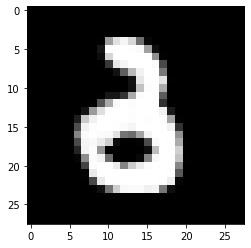

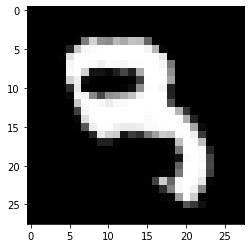

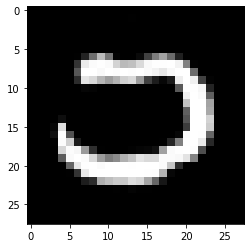

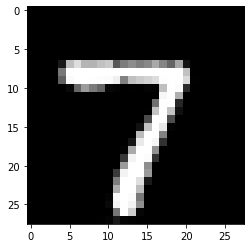

tensor(0.3116, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4455, device='cuda:0', grad_fn=<AddBackward0>)
42th iteration gen_loss: 0.31160643696784973 dis_loss: 0.445528119802475


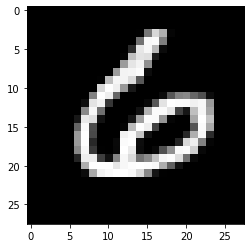

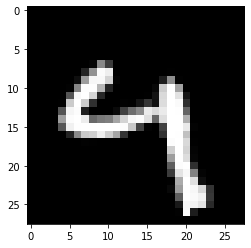

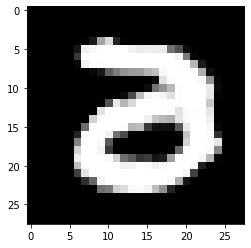

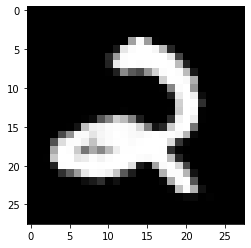

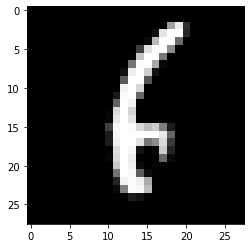

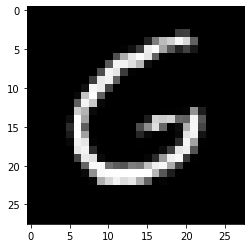

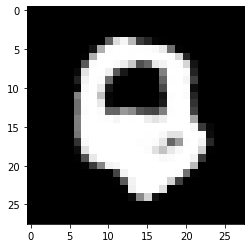

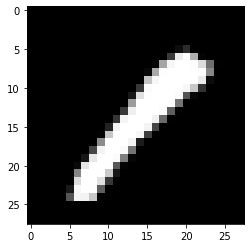

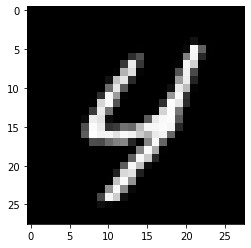

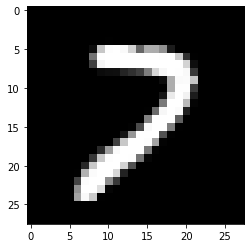

tensor(0.4139, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4804, device='cuda:0', grad_fn=<AddBackward0>)
43th iteration gen_loss: 0.4138748049736023 dis_loss: 0.48042622208595276


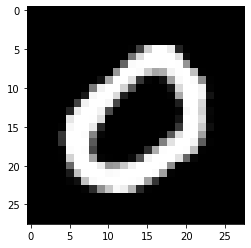

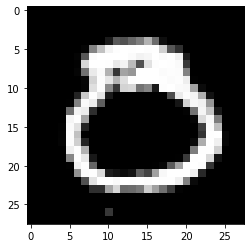

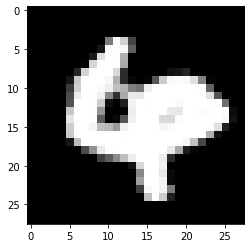

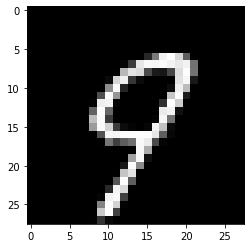

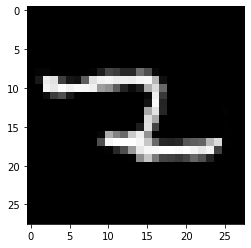

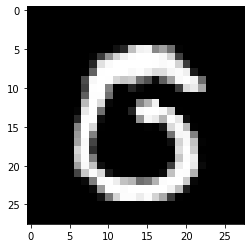

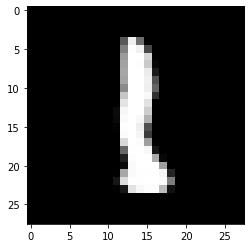

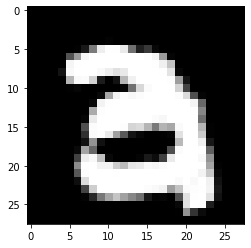

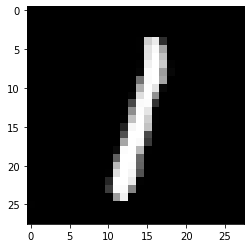

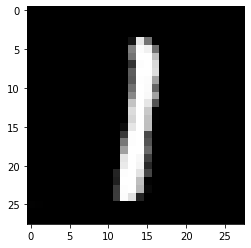

tensor(0.2660, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4544, device='cuda:0', grad_fn=<AddBackward0>)
43th iteration gen_loss: 0.26596975326538086 dis_loss: 0.4544293284416199


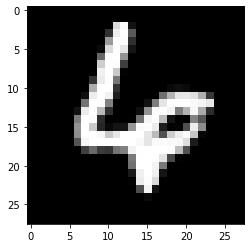

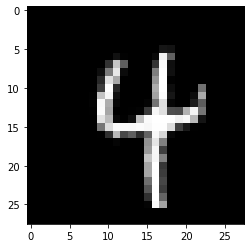

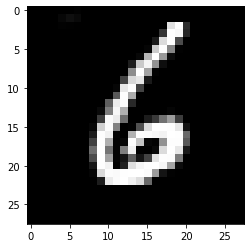

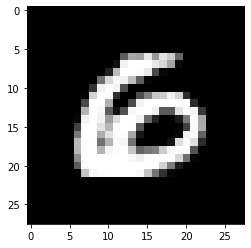

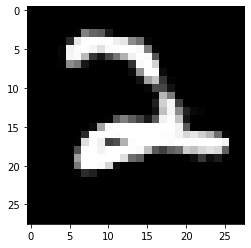

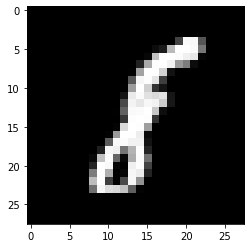

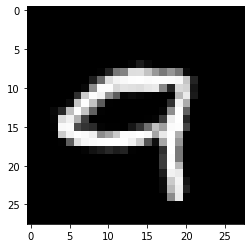

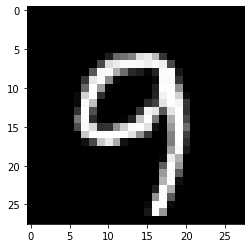

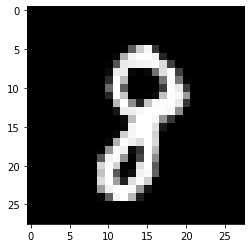

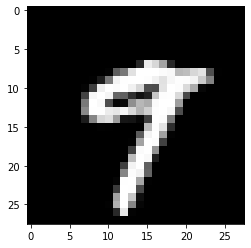

tensor(0.2969, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4550, device='cuda:0', grad_fn=<AddBackward0>)
44th iteration gen_loss: 0.29694610834121704 dis_loss: 0.4549510180950165


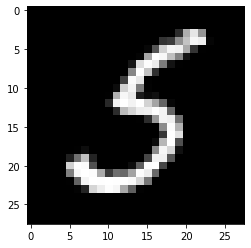

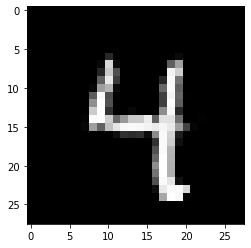

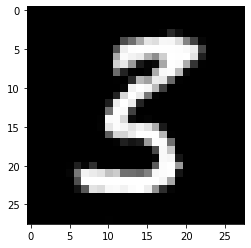

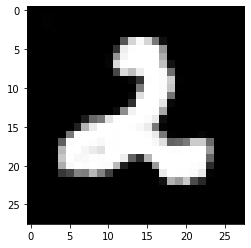

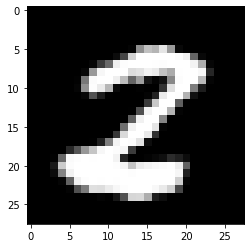

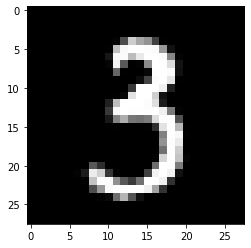

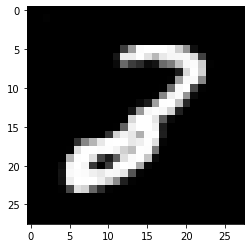

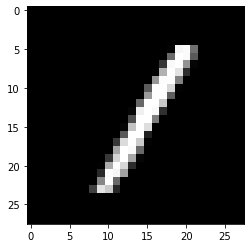

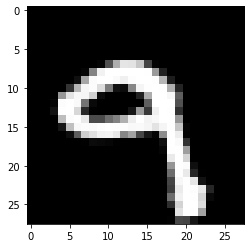

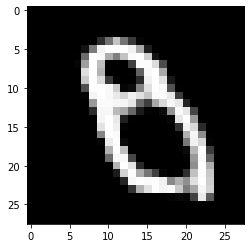

tensor(0.3252, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4585, device='cuda:0', grad_fn=<AddBackward0>)
44th iteration gen_loss: 0.325175404548645 dis_loss: 0.4585112929344177


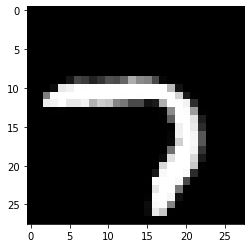

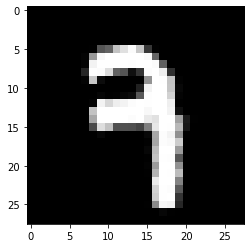

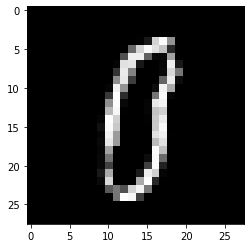

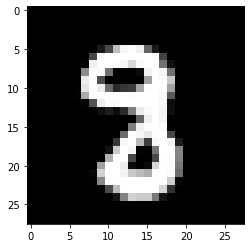

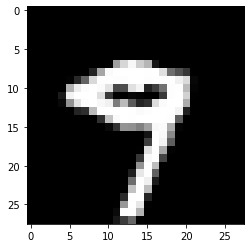

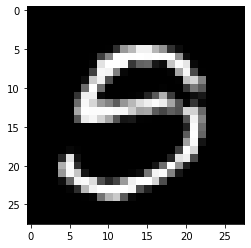

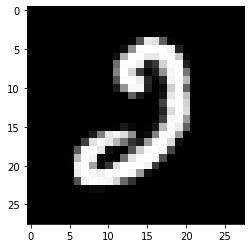

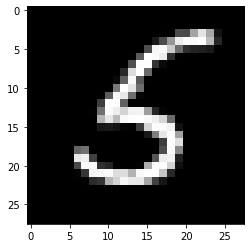

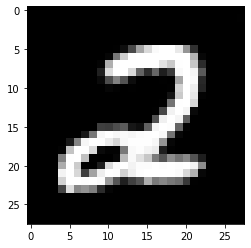

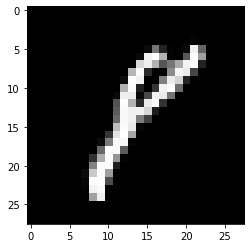

tensor(0.2476, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4615, device='cuda:0', grad_fn=<AddBackward0>)
45th iteration gen_loss: 0.2476469874382019 dis_loss: 0.46150997281074524


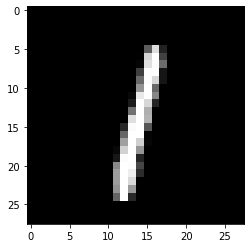

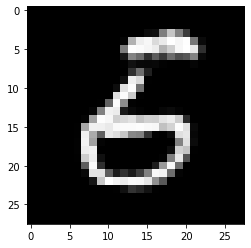

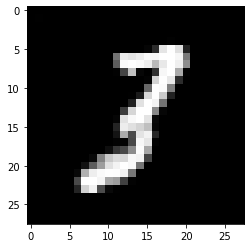

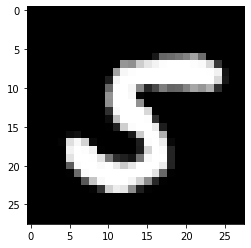

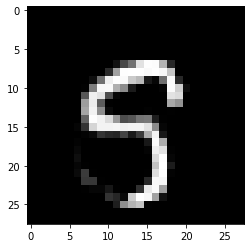

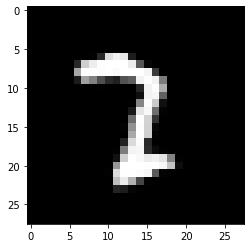

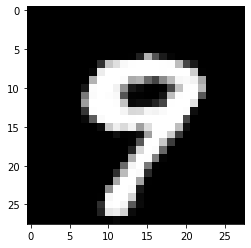

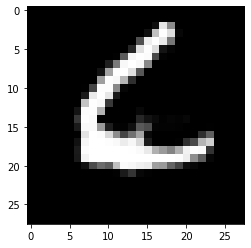

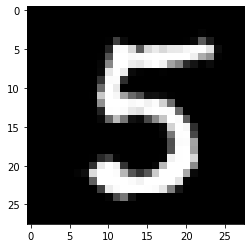

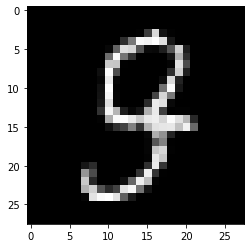

tensor(0.3175, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4526, device='cuda:0', grad_fn=<AddBackward0>)
45th iteration gen_loss: 0.31750717759132385 dis_loss: 0.45259445905685425


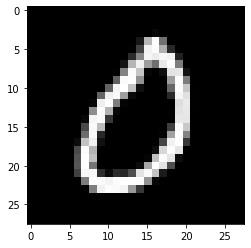

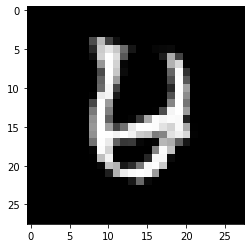

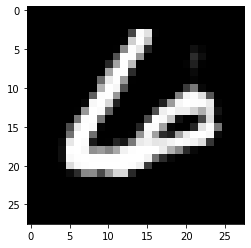

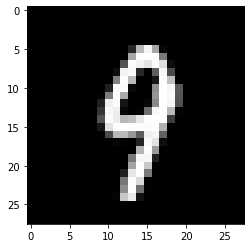

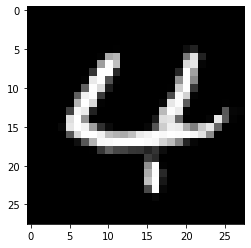

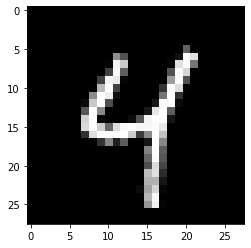

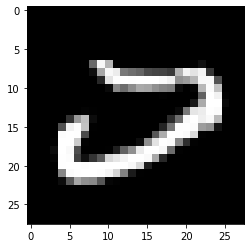

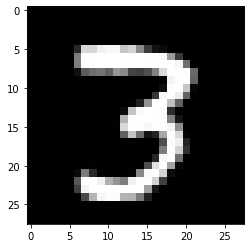

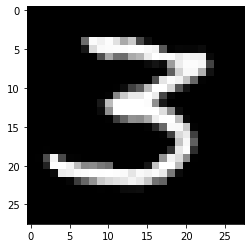

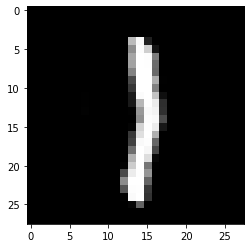

tensor(0.3677, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4640, device='cuda:0', grad_fn=<AddBackward0>)
46th iteration gen_loss: 0.36768221855163574 dis_loss: 0.46403589844703674


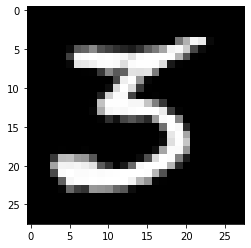

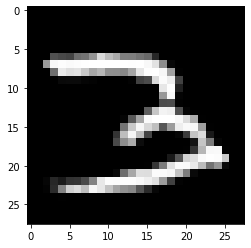

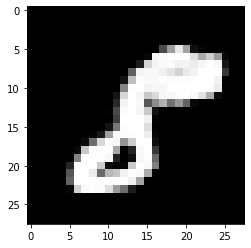

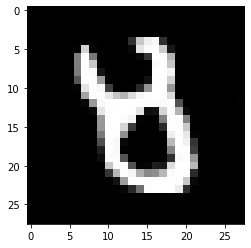

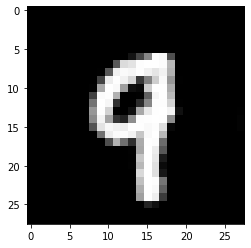

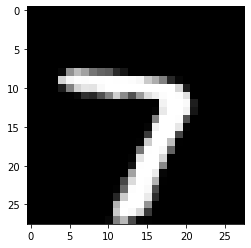

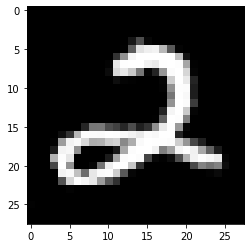

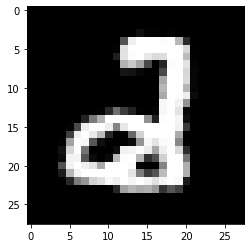

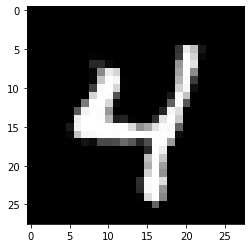

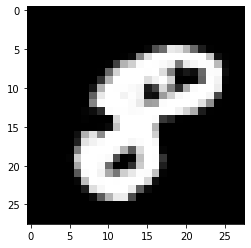

tensor(0.2935, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4483, device='cuda:0', grad_fn=<AddBackward0>)
46th iteration gen_loss: 0.29350167512893677 dis_loss: 0.4482777714729309


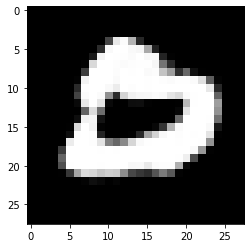

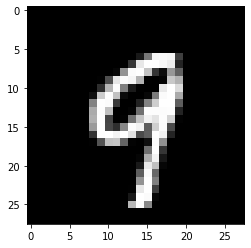

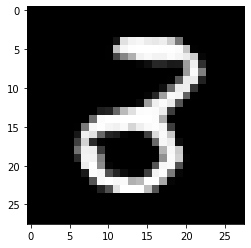

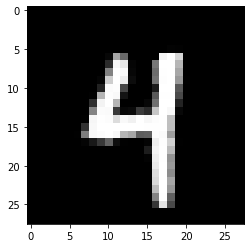

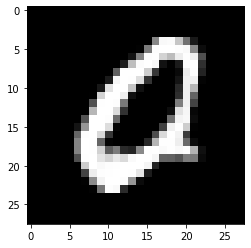

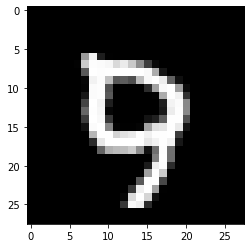

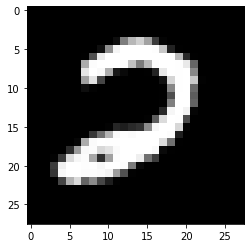

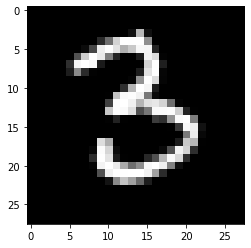

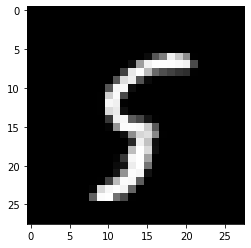

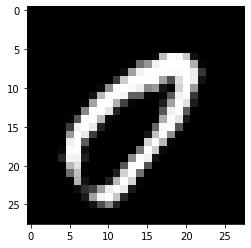

tensor(0.2092, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4507, device='cuda:0', grad_fn=<AddBackward0>)
47th iteration gen_loss: 0.2092074304819107 dis_loss: 0.450732946395874


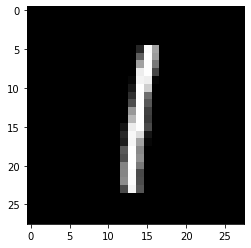

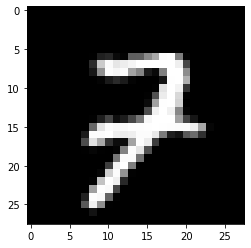

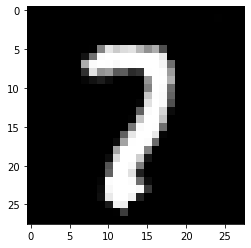

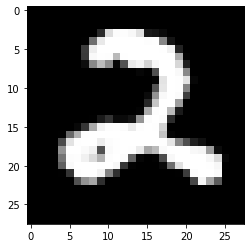

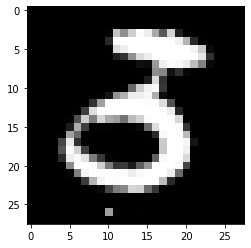

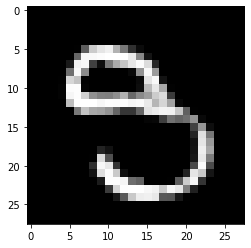

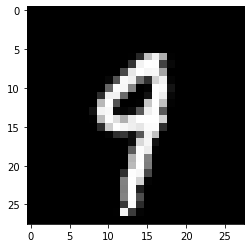

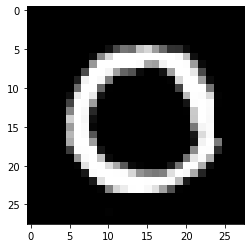

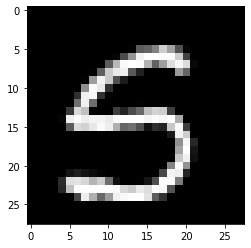

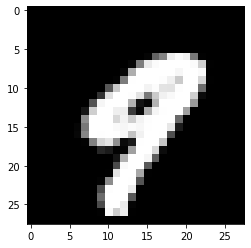

tensor(0.2097, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4716, device='cuda:0', grad_fn=<AddBackward0>)
47th iteration gen_loss: 0.20974552631378174 dis_loss: 0.47159722447395325


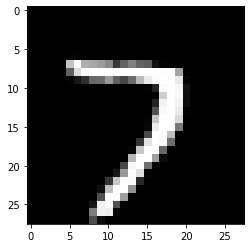

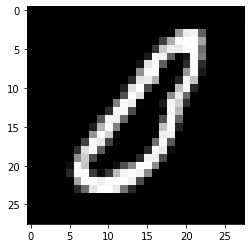

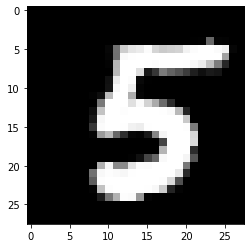

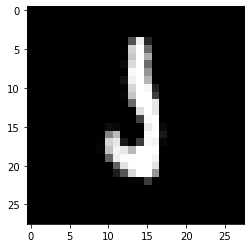

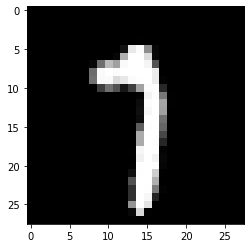

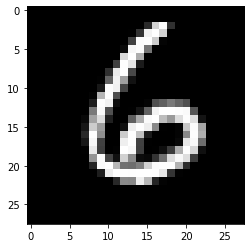

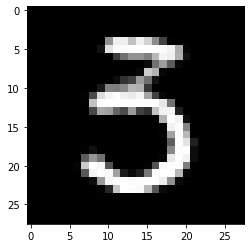

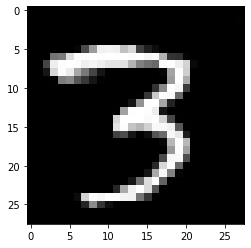

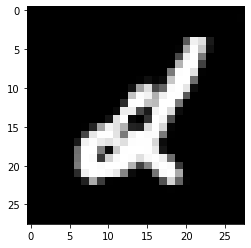

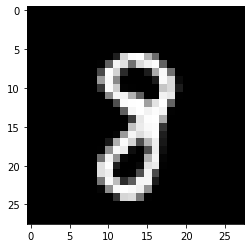

tensor(0.2523, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4520, device='cuda:0', grad_fn=<AddBackward0>)
48th iteration gen_loss: 0.2522769272327423 dis_loss: 0.45200836658477783


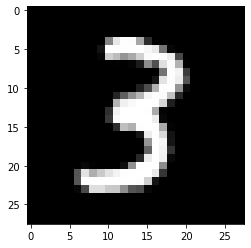

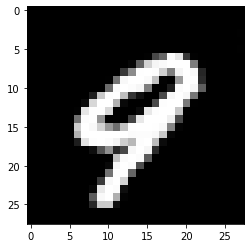

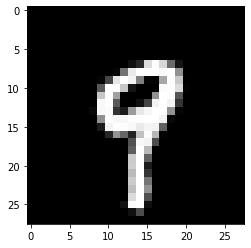

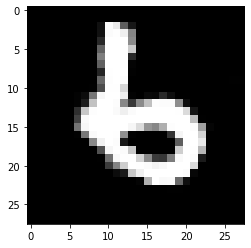

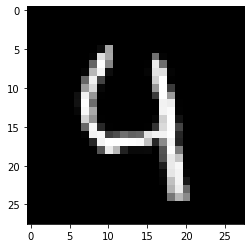

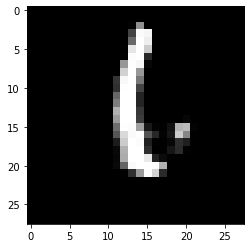

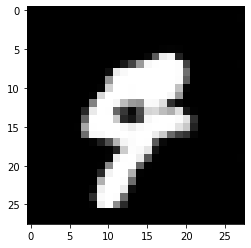

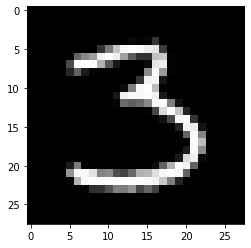

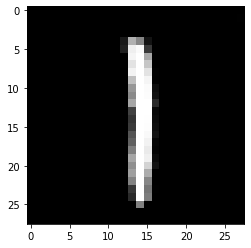

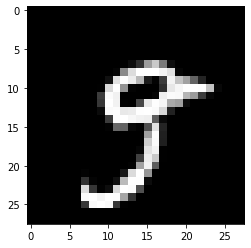

tensor(0.2420, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4576, device='cuda:0', grad_fn=<AddBackward0>)
48th iteration gen_loss: 0.2419886589050293 dis_loss: 0.4576292634010315


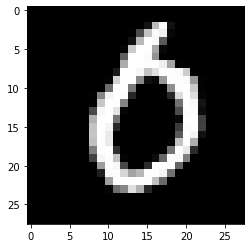

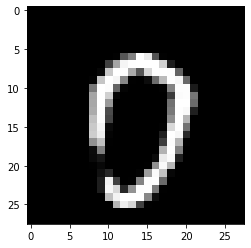

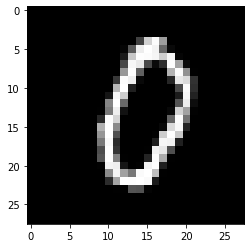

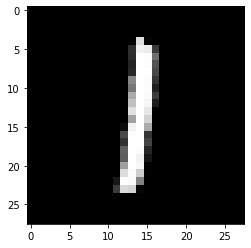

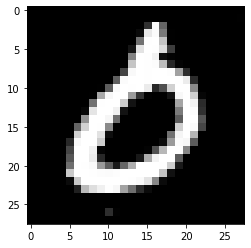

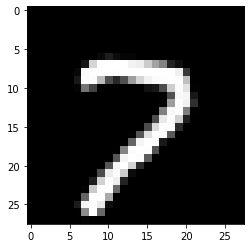

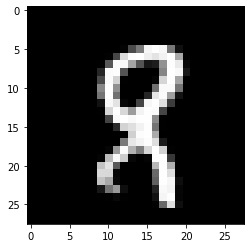

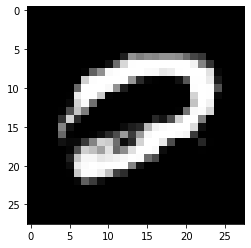

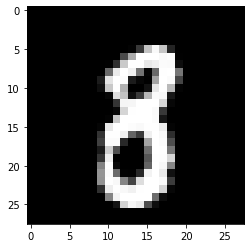

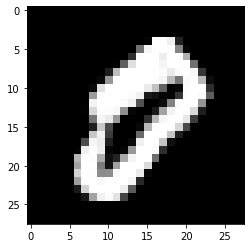

tensor(0.2913, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4343, device='cuda:0', grad_fn=<AddBackward0>)
49th iteration gen_loss: 0.29131123423576355 dis_loss: 0.4342518448829651


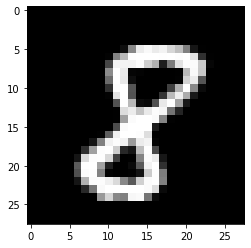

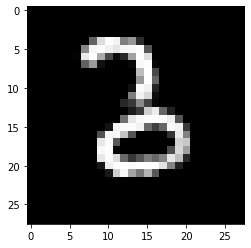

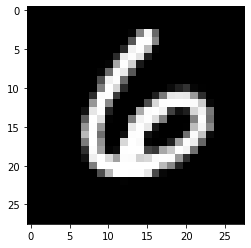

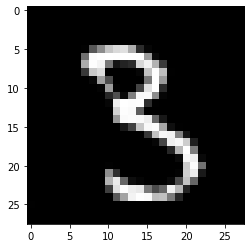

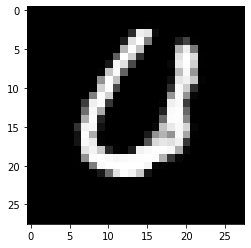

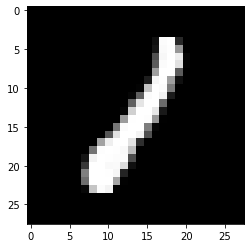

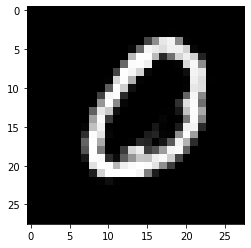

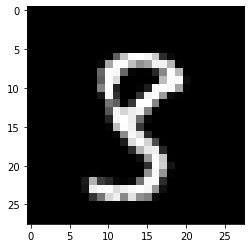

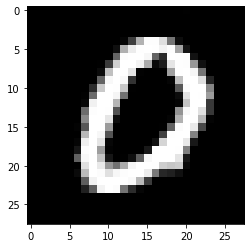

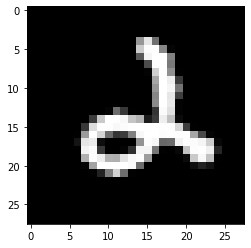

tensor(0.3157, device='cuda:0', grad_fn=<SumBackward0>) tensor(0.4476, device='cuda:0', grad_fn=<AddBackward0>)
49th iteration gen_loss: 0.3156551122665405 dis_loss: 0.4476433992385864


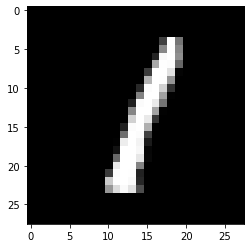

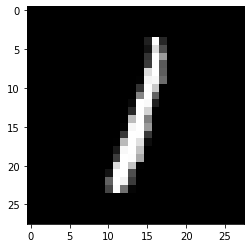

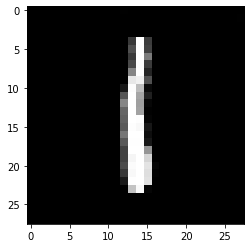

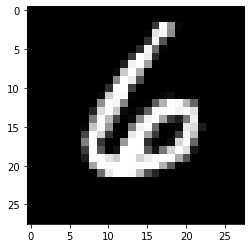

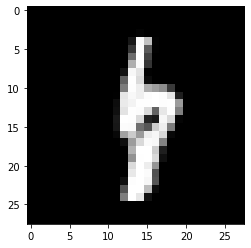

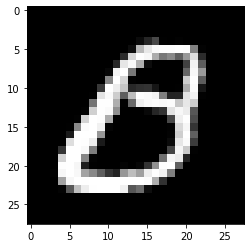

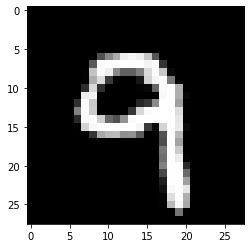

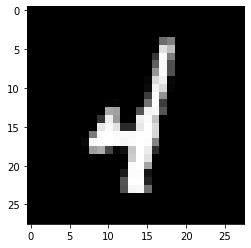

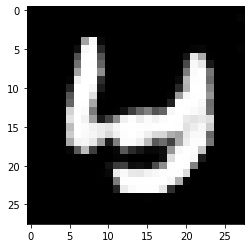

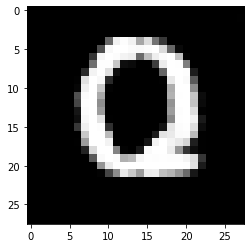

In [13]:
# train

for i in range(epoch):
    for j ,(image,label) in enumerate(train_loader):
        image = Variable(image).cuda()
        
        #generator
        gen_optim.zero_grad()
        
        z = Variable(init.normal_(torch.Tensor(batch_size,100), mean = 0, std = 0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        gen_loss = torch.sum(loss_func(dis_fake,ones_label))
        # fake classified as real
        gen_loss.backward(retain_graph=True)
        gen_optim.step()
        
        #discriminator
        dis_optim.zero_grad()
        
        z = Variable(init.normal_(torch.Tensor(batch_size,100), mean = 0, std = 0.1)).cuda()
        gen_fake = generator.forward(z)
        dis_fake = discriminator.forward(gen_fake)
        
        dis_real = discriminator.forward(image)
        dis_loss = torch.sum(loss_func(dis_fake,zeros_label)) + torch.sum(loss_func(dis_real, ones_label))
        dis_loss.backward()
        dis_optim.step()
        
        # model save
        if j % 100 == 0:
            print(gen_loss, dis_loss)
            torch.save({'generator': generator.state_dict()}, './vanilla_generator.pkl')
            torch.save({'discriminator':discriminator.state_dict()}, './vanilla_discriminator.pkl')
            
            print("{}th iteration gen_loss: {} dis_loss: {}".format(i,gen_loss.data,dis_loss.data))
            v_utils.save_image(gen_fake.data[0:25],"./gen_{}_{}.png".format(i,j), nrow=5)
            
            image_check(gen_fake.cpu())